In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pickle
from xgboost import XGBClassifier
import shap

# Reading Data and droping the unnamed column

In [57]:
df = pd.read_csv("cs-training.csv", usecols= lambda col:col not in["Unnamed: 0"])
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Separating variables from dataframe

In [58]:
training_variable =['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

objective_variable = ['SeriousDlqin2yrs']

# Dropping Dupicates

In [59]:
df["duplicates"] = df.duplicated()

df.duplicates.value_counts()

False    149391
True        609
Name: duplicates, dtype: int64

In [60]:
df = df.drop_duplicates()

df=df.drop(columns="duplicates")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Substituting 98 and 96 with median

In [61]:
median_90 = df.NumberOfTimes90DaysLate.median()
median_30 = df["NumberOfTime30-59DaysPastDueNotWorse"].median()
median_60 = df["NumberOfTime60-89DaysPastDueNotWorse"].median()
print(median_30,median_90,median_60)

0.0 0.0 0.0


In [62]:
df["NumberOfTime30-59DaysPastDueNotWorse"]= df["NumberOfTime30-59DaysPastDueNotWorse"].replace(98,median_30)
df["NumberOfTime60-89DaysPastDueNotWorse"] = df["NumberOfTime60-89DaysPastDueNotWorse"].replace(98,median_60)
df["NumberOfTimes90DaysLate"] = df["NumberOfTimes90DaysLate"].replace(98,median_90)
df["NumberOfTime30-59DaysPastDueNotWorse"]= df["NumberOfTime30-59DaysPastDueNotWorse"].replace(96,median_30)
df["NumberOfTime60-89DaysPastDueNotWorse"] = df["NumberOfTime60-89DaysPastDueNotWorse"].replace(96,median_60)
df["NumberOfTimes90DaysLate"] = df["NumberOfTimes90DaysLate"].replace(96,median_90)
df["age"]= df["age"].replace(0,df["age"].median())

# Substituting NaNs with median in dependants

In [63]:
df["NumberOfDependents"] =df["NumberOfDependents"].fillna(round(df["NumberOfDependents"].median()))

## Using a linear regresion in order tu fill NaNs of Monthly income

In [64]:
train = df[df.MonthlyIncome.isnull() == False]
test = df[df.MonthlyIncome.isnull() == True]


In [65]:
X_train = train.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)
y_train = train.MonthlyIncome
X_test = test.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

In [66]:
from sklearn.linear_model import LinearRegression

In [67]:
lmMod = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)

In [68]:
pred = lmMod.predict(X_test)
pred

array([2565.02351156, 3203.7116041 , 6172.47595393, ..., 5509.70997141,
       4035.97469594, 3223.36989092])

In [69]:
predNoZero = []
for val in pred:
    if val >= 0:
        predNoZero.append(val)
    else:
        predNoZero.append(0.)

In [70]:
testFull = df[df.MonthlyIncome.isnull() == True]

In [71]:
testFull["MonthlyIncome"] = predNoZero

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
monNew = []
for index in df.index:
    if df.MonthlyIncome[index].is_integer() == True:
        monNew.append(df.MonthlyIncome[index])
    else:
        monNew.append(testFull.MonthlyIncome[index])

In [73]:
df.MonthlyIncome = monNew

## ML clasification model start here

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X = df[training_variable]
y = df[objective_variable]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size =0.5)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(104819, 10) (104819, 1)
(52410, 10) (52410, 1)
(52409, 10) (52409, 1)


In [37]:
clfArr = []
yscoresArr = []

roc_auc_scoreDict = {}
#test array is 
#arr = [1,2,3]
#final test array is 
tree_num = [1,10,25,50,75,100,125,150,200,300]
var_num = [1,3,10]
#arr = [1,10,25,50, 75, 100]
ind = 0
for t in tree_num:
#    print(t)
    roc_auc_scoreDict[t] = {}
    for v in var_num:
        print("%d, %d" % (t, v))
        clf = RandomForestClassifier(n_estimators=t
                                     , n_jobs=-1, verbose=1, max_features=v)
        clf.fit(X_train,y_train)
        y_pred = clf.predict_proba(X_val[:])[:, 1]
        roc_auc_scoreDict[t][v] = roc_auc_score(y_val, y_pred)
print(roc_auc_scoreDict)

1, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


1, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


1, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


10, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


10, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


10, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


25, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


25, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


25, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


50, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


50, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


50, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


75, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.4s finished


75, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.3s finished


75, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   19.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.3s finished


100, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


100, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


100, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


125, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished


125, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished


125, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   32.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished


150, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished


150, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished


150, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   45.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.8s finished


200, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


200, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.2s finished


200, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished


300, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.6s finished


300, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.5s finished


300, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.4s finished


{1: {1: 0.850421734327249, 3: 0.8576896556574901, 10: 0.8578019104662882}, 10: {1: 0.9995993143333897, 3: 0.999634617905004, 10: 0.999588043474411}, 25: {1: 0.9999757639699085, 3: 0.9999617055991404, 10: 0.999947611868815}, 50: {1: 0.9999859946685684, 3: 0.9999897516215612, 10: 0.9999822789683928}, 75: {1: 0.999994168619629, 3: 0.9999943336308977, 10: 0.9999881103487636}, 100: {1: 0.999992094192251, 3: 0.999991056978562, 10: 0.9999861302135392}, 125: {1: 0.9999958717716525, 3: 0.999994345417417, 10: 0.9999908625009952}, 150: {1: 0.9999953944176251, 3: 0.9999915637988874, 10: 0.9999935910801886}, 200: {1: 0.9999945104286856, 3: 0.9999943984567533, 10: 0.9999875622756211}, 300: {1: 0.9999948286647039, 3: 0.9999921118720299, 10: 0.9999919940068378}}


# Hyperparameter tuning

In [38]:
from pprint import pprint
pprint(roc_auc_scoreDict)

{1: {1: 0.850421734327249, 3: 0.8576896556574901, 10: 0.8578019104662882},
 10: {1: 0.9995993143333897, 3: 0.999634617905004, 10: 0.999588043474411},
 25: {1: 0.9999757639699085, 3: 0.9999617055991404, 10: 0.999947611868815},
 50: {1: 0.9999859946685684, 3: 0.9999897516215612, 10: 0.9999822789683928},
 75: {1: 0.999994168619629, 3: 0.9999943336308977, 10: 0.9999881103487636},
 100: {1: 0.999992094192251, 3: 0.999991056978562, 10: 0.9999861302135392},
 125: {1: 0.9999958717716525, 3: 0.999994345417417, 10: 0.9999908625009952},
 150: {1: 0.9999953944176251, 3: 0.9999915637988874, 10: 0.9999935910801886},
 200: {1: 0.9999945104286856, 3: 0.9999943984567533, 10: 0.9999875622756211},
 300: {1: 0.9999948286647039, 3: 0.9999921118720299, 10: 0.9999919940068378}}


In [39]:
dfauc = pd.DataFrame(roc_auc_scoreDict)
dfauc

,1,10,25,50,75,100,125,150,200,300
1,0.850422,0.999599,0.999976,0.999986,0.999994,0.999992,0.999996,0.999995,0.999995,0.999995
3,0.857690,0.999635,0.999962,0.999990,0.999994,0.999991,0.999994,0.999992,0.999994,0.999992
10,0.857802,0.999588,0.999948,0.999982,0.999988,0.999986,0.999991,0.999994,0.999988,0.999992


Text(0.5, 1.0, 'Random Forest Performance')

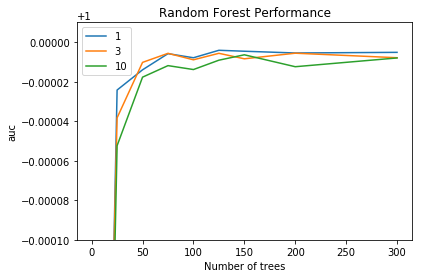

In [40]:
for v in var_num:
    plt.plot(tree_num, dfauc.loc[v], label=v )
plt.ylim([.9999,1.00001])
plt.legend()
plt.xlabel("Number of trees")
plt.ylabel("auc")
plt.title("Random Forest Performance")

## Best clasification model is with 150 Tres and 1 feature(based over prediction on validation set)

In [42]:
best_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, verbose=1, max_features=1)
best_clf.fit(X_train,y_train)

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

## Saving model in binary file using Pickle

In [43]:
with open ('rft.p', 'wb') as f:
    pickle.dump(best_clf, f)
    

In [3]:
with open('rft.p', 'rb') as f:
    model = pickle.load(f)

## Testing

In [45]:
New_client = X_test.reset_index(drop=True).loc[[2456]]
print(New_client)

      RevolvingUtilizationOfUnsecuredLines  age  \
2456                              0.003251   76   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
2456                                     0   0.103112         2666.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
2456                                7                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
2456                             0                                     0   

      NumberOfDependents  
2456                 0.0  


In [47]:
model.predict_proba(New_client)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


array([[1., 0.]])

In [50]:
ypred_test = model.predict(X_test)
ypred_test

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Score

In [52]:
score = roc_auc_score(y_test, ypred_test)
score

0.9976684839224583

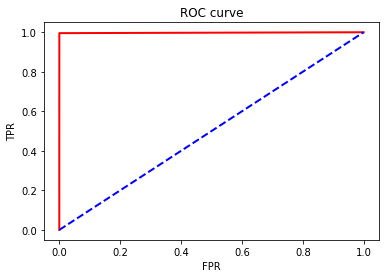

In [57]:
fpr, tpr,_= roc_curve(y_test, ypred_test)
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# Trying with XGBOOST

In [22]:
from xgboost import XGBClassifier

In [97]:

roc_auc_scoreDict1 = {}
max_depth = [1, 3, 5]
learning_rate= [0.5, 0.1, 0.01]
subsample = [0.1, 0.5, 1]
ind = 0
for d in max_depth:
    
    roc_auc_scoreDict1[d] = {}
    for l in learning_rate:
        roc_auc_scoreDict1[d][l] = {}
        for s in subsample:
            print("%d, %f, %f " % (d, l, s))
            clf2 = XGBClassifier(max_depth= d, learning_rate=l,n_estimators=5000, subsample=s, n_jobs=-1)
            clf2.fit(X_train, y_train, verbose=100, early_stopping_rounds=100, eval_set=[(X_train,y_train),(X_val,y_val)])
            y_pred = clf2.predict_proba(X_val[:])[:, 1]
            
            roc_auc_scoreDict1[d][l][s] = roc_auc_score(y_val, y_pred)
print(roc_auc_scoreDict1)
    

1, 0.500000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.065017	validation_1-error:0.066743
[5]	validation_0-error:0.065017	validation_1-error:0.066743
[6]	validation_0-error:0.065055	validation_1-error:0.066857
[7]	validation_0-error:0.064941	validation_1-error:0.066667
[8]	validation_0-error:0.06453	validation_1-error:0.066304
[9]	validation_0-error:0.064549	validation_1-error:0.066419
[10]	validation_0-error:0.064435	validation_1-error:0.066323
[11]	validation_0-error:0.064502	validation_1-error:0.066476
[12]	validation_0-error:0.064082	validation_1-error:0.065636
[13]	validation_0-error:0.06412	validation_1-error:0.065

[132]	validation_0-error:0.0635	validation_1-error:0.064625
[133]	validation_0-error:0.063538	validation_1-error:0.06474
[134]	validation_0-error:0.063643	validation_1-error:0.064759
[135]	validation_0-error:0.0635	validation_1-error:0.064644
[136]	validation_0-error:0.063424	validation_1-error:0.064587
[137]	validation_0-error:0.063462	validation_1-error:0.06472
[138]	validation_0-error:0.063395	validation_1-error:0.064701
[139]	validation_0-error:0.063538	validation_1-error:0.064797
[140]	validation_0-error:0.063452	validation_1-error:0.064682
[141]	validation_0-error:0.063529	validation_1-error:0.064988
[142]	validation_0-error:0.063567	validation_1-error:0.064816
[143]	validation_0-error:0.063509	validation_1-error:0.064625
[144]	validation_0-error:0.063433	validation_1-error:0.064625
[145]	validation_0-error:0.063328	validation_1-error:0.064568
[146]	validation_0-error:0.063357	validation_1-error:0.064663
[147]	validation_0-error:0.063271	validation_1-error:0.064492
[148]	validati

[265]	validation_0-error:0.063939	validation_1-error:0.065083
[266]	validation_0-error:0.064111	validation_1-error:0.065217
[267]	validation_0-error:0.064044	validation_1-error:0.065083
[268]	validation_0-error:0.063805	validation_1-error:0.065102
[269]	validation_0-error:0.063853	validation_1-error:0.065102
[270]	validation_0-error:0.064072	validation_1-error:0.065217
[271]	validation_0-error:0.064101	validation_1-error:0.065217
[272]	validation_0-error:0.064025	validation_1-error:0.065178
[273]	validation_0-error:0.063929	validation_1-error:0.065159
[274]	validation_0-error:0.063986	validation_1-error:0.065159
[275]	validation_0-error:0.063958	validation_1-error:0.064949
[276]	validation_0-error:0.06413	validation_1-error:0.065178
[277]	validation_0-error:0.064044	validation_1-error:0.065159
[278]	validation_0-error:0.063996	validation_1-error:0.06514
[279]	validation_0-error:0.063958	validation_1-error:0.065007
Stopping. Best iteration:
[179]	validation_0-error:0.063252	validation_1

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.064969	validation_1-error:0.066648
[6]	validation_0-error:0.065065	validation_1-error:0.066838
[7]	validation_0-error:0.064521	validation_1-error:0.066285
[8]	validation_0-error:0.064568	validation_1-error:0.066266
[9]	validation_0-error:0.064521	validation_1-error:0.066228
[10]	validation_0-error:0.064454	validation_1-error:0.066247
[11]	validation_0-error:0.064387	validation_1-error:0.066209
[12]	validation_0-error:0.063786	validation_1-error:0.065102
[13]	validation_0-error:0.063805	validation_1-error:0.0

[132]	validation_0-error:0.063443	validation_1-error:0.064778
[133]	validation_0-error:0.063452	validation_1-error:0.06474
[134]	validation_0-error:0.063595	validation_1-error:0.064816
[135]	validation_0-error:0.063509	validation_1-error:0.064759
[136]	validation_0-error:0.063443	validation_1-error:0.064701
[137]	validation_0-error:0.063471	validation_1-error:0.064778
[138]	validation_0-error:0.063452	validation_1-error:0.064778
[139]	validation_0-error:0.063443	validation_1-error:0.06474
[140]	validation_0-error:0.063405	validation_1-error:0.06474
[141]	validation_0-error:0.0635	validation_1-error:0.064835
[142]	validation_0-error:0.063395	validation_1-error:0.064701
[143]	validation_0-error:0.063385	validation_1-error:0.064663
[144]	validation_0-error:0.063462	validation_1-error:0.064701
[145]	validation_0-error:0.063414	validation_1-error:0.064682
[146]	validation_0-error:0.063405	validation_1-error:0.064682
[147]	validation_0-error:0.063376	validation_1-error:0.064663
[148]	validat

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.06496	validation_1-error:0.066667
[6]	validation_0-error:0.065065	validation_1-error:0.066838
[7]	validation_0-error:0.064568	validation_1-error:0.066361
[8]	validation_0-error:0.064626	validation_1-error:0.066342
[9]	validation_0-error:0.064654	validation_1-error:0.066476
[10]	validation_0-error:0.064359	validation_1-error:0.065999
[11]	validation_0-error:0.064292	validation_1-error:0.065942
[12]	validation_0-error:0.063815	validation_1-error:0.065541
[13]	validation_0-error:0.063853	validation_1-error:0.06

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.066992	validation_1-error:0.068994
[6]	validation_0-error:0.066992	validation_1-error:0.068994
[7]	validation_0-error:0.066992	validation_1-error:0.068994
[8]	validation_0-error:0.066992	validation_1-error:0.068994
[9]	validation_0-error:0.066992	validation_1-error:0.068994
[10]	validation_0-error:0.066992	validation_1-error:0.068994
[11]	validation_0-error:0.066992	validation_1-error:0.068994
[12]	validation_0-error:0.066992	validation_1-error:0.068994
[13]	validation_0-error:0.066992	validation_1-error:0.0

[132]	validation_0-error:0.063452	validation_1-error:0.064816
[133]	validation_0-error:0.063557	validation_1-error:0.064892
[134]	validation_0-error:0.063424	validation_1-error:0.06472
[135]	validation_0-error:0.063471	validation_1-error:0.064759
[136]	validation_0-error:0.063509	validation_1-error:0.064797
[137]	validation_0-error:0.063462	validation_1-error:0.064854
[138]	validation_0-error:0.063519	validation_1-error:0.064835
[139]	validation_0-error:0.063519	validation_1-error:0.064816
[140]	validation_0-error:0.063519	validation_1-error:0.064816
[141]	validation_0-error:0.063452	validation_1-error:0.06472
[142]	validation_0-error:0.063405	validation_1-error:0.064625
[143]	validation_0-error:0.063385	validation_1-error:0.064644
[144]	validation_0-error:0.063366	validation_1-error:0.064644
[145]	validation_0-error:0.063366	validation_1-error:0.064625
[146]	validation_0-error:0.063376	validation_1-error:0.064625
[147]	validation_0-error:0.063509	validation_1-error:0.064701
[148]	vali

[265]	validation_0-error:0.063586	validation_1-error:0.064835
[266]	validation_0-error:0.063624	validation_1-error:0.064778
[267]	validation_0-error:0.063681	validation_1-error:0.06493
[268]	validation_0-error:0.063662	validation_1-error:0.064854
[269]	validation_0-error:0.063538	validation_1-error:0.064644
[270]	validation_0-error:0.063538	validation_1-error:0.06474
[271]	validation_0-error:0.063557	validation_1-error:0.064778
[272]	validation_0-error:0.063519	validation_1-error:0.064759
[273]	validation_0-error:0.063519	validation_1-error:0.06474
[274]	validation_0-error:0.063548	validation_1-error:0.064682
[275]	validation_0-error:0.063653	validation_1-error:0.064759
[276]	validation_0-error:0.063595	validation_1-error:0.064759
[277]	validation_0-error:0.063567	validation_1-error:0.06474
[278]	validation_0-error:0.063576	validation_1-error:0.064701
[279]	validation_0-error:0.063595	validation_1-error:0.064759
[280]	validation_0-error:0.063672	validation_1-error:0.064835
[281]	valida

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.066992	validation_1-error:0.068994
[6]	validation_0-error:0.066992	validation_1-error:0.068994
[7]	validation_0-error:0.066992	validation_1-error:0.068994
[8]	validation_0-error:0.066992	validation_1-error:0.068994
[9]	validation_0-error:0.066992	validation_1-error:0.068994
[10]	validation_0-error:0.066992	validation_1-error:0.068994
[11]	validation_0-error:0.066992	validation_1-error:0.068994
[12]	validation_0-error:0.066992	validation_1-error:0.068994
[13]	validation_0-error:0.066992	validation_1-error:0.0

[132]	validation_0-error:0.063328	validation_1-error:0.064644
[133]	validation_0-error:0.063328	validation_1-error:0.064682
[134]	validation_0-error:0.063281	validation_1-error:0.064663
[135]	validation_0-error:0.063176	validation_1-error:0.06453
[136]	validation_0-error:0.063233	validation_1-error:0.064606
[137]	validation_0-error:0.063233	validation_1-error:0.064587
[138]	validation_0-error:0.063261	validation_1-error:0.064644
[139]	validation_0-error:0.063233	validation_1-error:0.064606
[140]	validation_0-error:0.063252	validation_1-error:0.064606
[141]	validation_0-error:0.063328	validation_1-error:0.064701
[142]	validation_0-error:0.0633	validation_1-error:0.064682
[143]	validation_0-error:0.063309	validation_1-error:0.064682
[144]	validation_0-error:0.063281	validation_1-error:0.064682
[145]	validation_0-error:0.063309	validation_1-error:0.064778
[146]	validation_0-error:0.063309	validation_1-error:0.064759
[147]	validation_0-error:0.063309	validation_1-error:0.064797
[148]	valid

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.066992	validation_1-error:0.068994
[6]	validation_0-error:0.066992	validation_1-error:0.068994
[7]	validation_0-error:0.066992	validation_1-error:0.068994
[8]	validation_0-error:0.066992	validation_1-error:0.068994
[9]	validation_0-error:0.066992	validation_1-error:0.068994
[10]	validation_0-error:0.066992	validation_1-error:0.068994
[11]	validation_0-error:0.066992	validation_1-error:0.068994
[12]	validation_0-error:0.066992	validation_1-error:0.068994
[13]	validation_0-error:0.066992	validation_1-error:0.0

[132]	validation_0-error:0.063414	validation_1-error:0.064682
[133]	validation_0-error:0.063462	validation_1-error:0.064759
[134]	validation_0-error:0.063481	validation_1-error:0.064759
[135]	validation_0-error:0.063462	validation_1-error:0.064759
[136]	validation_0-error:0.063462	validation_1-error:0.06472
[137]	validation_0-error:0.063471	validation_1-error:0.06474
[138]	validation_0-error:0.063443	validation_1-error:0.064701
[139]	validation_0-error:0.063395	validation_1-error:0.064644
[140]	validation_0-error:0.063385	validation_1-error:0.064644
[141]	validation_0-error:0.063424	validation_1-error:0.064682
[142]	validation_0-error:0.063405	validation_1-error:0.064682
[143]	validation_0-error:0.063357	validation_1-error:0.064644
[144]	validation_0-error:0.063338	validation_1-error:0.064587
[145]	validation_0-error:0.063347	validation_1-error:0.064625
[146]	validation_0-error:0.063347	validation_1-error:0.064625
[147]	validation_0-error:0.063357	validation_1-error:0.064644
[148]	vali

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.066992	validation_1-error:0.068994
[6]	validation_0-error:0.066992	validation_1-error:0.068994
[7]	validation_0-error:0.066992	validation_1-error:0.068994
[8]	validation_0-error:0.066992	validation_1-error:0.068994
[9]	validation_0-error:0.066992	validation_1-error:0.068994
[10]	validation_0-error:0.066992	validation_1-error:0.068994
[11]	validation_0-error:0.066992	validation_1-error:0.068994
[12]	validation_0-error:0.066992	validation_1-error:0.068994
[13]	validation_0-error:0.066992	validation_1-error:0.0

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.066992	validation_1-error:0.068994
[6]	validation_0-error:0.066992	validation_1-error:0.068994
[7]	validation_0-error:0.066992	validation_1-error:0.068994
[8]	validation_0-error:0.066992	validation_1-error:0.068994
[9]	validation_0-error:0.066992	validation_1-error:0.068994
[10]	validation_0-error:0.066992	validation_1-error:0.068994
[11]	validation_0-error:0.066992	validation_1-error:0.068994
[12]	validation_0-error:0.066992	validation_1-error:0.068994
[13]	validation_0-error:0.066992	validation_1-error:0.0

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066992	validation_1-error:0.068994
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.066992	validation_1-error:0.068994
[2]	validation_0-error:0.066992	validation_1-error:0.068994
[3]	validation_0-error:0.066992	validation_1-error:0.068994
[4]	validation_0-error:0.066992	validation_1-error:0.068994
[5]	validation_0-error:0.066992	validation_1-error:0.068994
[6]	validation_0-error:0.066992	validation_1-error:0.068994
[7]	validation_0-error:0.066992	validation_1-error:0.068994
[8]	validation_0-error:0.066992	validation_1-error:0.068994
[9]	validation_0-error:0.066992	validation_1-error:0.068994
[10]	validation_0-error:0.066992	validation_1-error:0.068994
[11]	validation_0-error:0.066992	validation_1-error:0.068994
[12]	validation_0-error:0.066992	validation_1-error:0.068994
[13]	validation_0-error:0.066992	validation_1-error:0.0

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066658	validation_1-error:0.067831
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.065332	validation_1-error:0.066953
[2]	validation_0-error:0.065045	validation_1-error:0.066419
[3]	validation_0-error:0.064301	validation_1-error:0.066056
[4]	validation_0-error:0.064378	validation_1-error:0.066037
[5]	validation_0-error:0.064168	validation_1-error:0.065789
[6]	validation_0-error:0.064664	validation_1-error:0.06619
[7]	validation_0-error:0.064559	validation_1-error:0.065903
[8]	validation_0-error:0.063939	validation_1-error:0.065503
[9]	validation_0-error:0.064187	validation_1-error:0.065865
[10]	validation_0-error:0.064263	validation_1-error:0.065942
[11]	validation_0-error:0.064282	validation_1-error:0.066094
[12]	validation_0-error:0.064368	validation_1-error:0.06619
[13]	validation_0-error:0.064273	validation_1-error:0.065

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.064492	validation_1-error:0.06638
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.063738	validation_1-error:0.065388
[2]	validation_0-error:0.063719	validation_1-error:0.065655
[3]	validation_0-error:0.063471	validation_1-error:0.065312
[4]	validation_0-error:0.063548	validation_1-error:0.065236
[5]	validation_0-error:0.06309	validation_1-error:0.06472
[6]	validation_0-error:0.06287	validation_1-error:0.064415
[7]	validation_0-error:0.063156	validation_1-error:0.06472
[8]	validation_0-error:0.062947	validation_1-error:0.064663
[9]	validation_0-error:0.062966	validation_1-error:0.06472
[10]	validation_0-error:0.062908	validation_1-error:0.064492
[11]	validation_0-error:0.063004	validation_1-error:0.064587
[12]	validation_0-error:0.063204	validation_1-error:0.064778
[13]	validation_0-error:0.062956	validation_1-error:0.064587


[132]	validation_0-error:0.060094	validation_1-error:0.06182
[133]	validation_0-error:0.060065	validation_1-error:0.061744
[134]	validation_0-error:0.060008	validation_1-error:0.061744
[135]	validation_0-error:0.060046	validation_1-error:0.061973
[136]	validation_0-error:0.060027	validation_1-error:0.061916
[137]	validation_0-error:0.05997	validation_1-error:0.061801
[138]	validation_0-error:0.059913	validation_1-error:0.061629
[139]	validation_0-error:0.059884	validation_1-error:0.061591
[140]	validation_0-error:0.059922	validation_1-error:0.061668
[141]	validation_0-error:0.059941	validation_1-error:0.061687
[142]	validation_0-error:0.059999	validation_1-error:0.061706
[143]	validation_0-error:0.059941	validation_1-error:0.061649
[144]	validation_0-error:0.059951	validation_1-error:0.061629
[145]	validation_0-error:0.059932	validation_1-error:0.061687
[146]	validation_0-error:0.059922	validation_1-error:0.061496
[147]	validation_0-error:0.059922	validation_1-error:0.061572
[148]	vali

[265]	validation_0-error:0.0581	validation_1-error:0.059607
[266]	validation_0-error:0.058138	validation_1-error:0.059588
[267]	validation_0-error:0.058167	validation_1-error:0.059473
[268]	validation_0-error:0.058091	validation_1-error:0.059397
[269]	validation_0-error:0.058091	validation_1-error:0.05955
[270]	validation_0-error:0.058091	validation_1-error:0.059531
[271]	validation_0-error:0.058081	validation_1-error:0.059206
[272]	validation_0-error:0.05811	validation_1-error:0.059321
[273]	validation_0-error:0.058138	validation_1-error:0.059473
[274]	validation_0-error:0.058167	validation_1-error:0.059569
[275]	validation_0-error:0.058205	validation_1-error:0.059645
[276]	validation_0-error:0.058224	validation_1-error:0.059779
[277]	validation_0-error:0.058224	validation_1-error:0.059798
[278]	validation_0-error:0.058157	validation_1-error:0.059721
[279]	validation_0-error:0.058148	validation_1-error:0.059779
[280]	validation_0-error:0.058091	validation_1-error:0.059626
[281]	valida

[398]	validation_0-error:0.056163	validation_1-error:0.057966
[399]	validation_0-error:0.056268	validation_1-error:0.0581
[400]	validation_0-error:0.056135	validation_1-error:0.057852
[401]	validation_0-error:0.056097	validation_1-error:0.057966
[402]	validation_0-error:0.056183	validation_1-error:0.058119
[403]	validation_0-error:0.056097	validation_1-error:0.057985
[404]	validation_0-error:0.056049	validation_1-error:0.057928
[405]	validation_0-error:0.055935	validation_1-error:0.057813
[406]	validation_0-error:0.055906	validation_1-error:0.057909
[407]	validation_0-error:0.055887	validation_1-error:0.057871
[408]	validation_0-error:0.055839	validation_1-error:0.05768
[409]	validation_0-error:0.055887	validation_1-error:0.057565
[410]	validation_0-error:0.055944	validation_1-error:0.057813
[411]	validation_0-error:0.055877	validation_1-error:0.057661
[412]	validation_0-error:0.055935	validation_1-error:0.057661
[413]	validation_0-error:0.056163	validation_1-error:0.058004
[414]	valid

[531]	validation_0-error:0.055305	validation_1-error:0.056535
[532]	validation_0-error:0.055162	validation_1-error:0.056421
[533]	validation_0-error:0.055133	validation_1-error:0.056287
[534]	validation_0-error:0.055162	validation_1-error:0.05623
[535]	validation_0-error:0.055286	validation_1-error:0.056363
[536]	validation_0-error:0.055238	validation_1-error:0.056287
[537]	validation_0-error:0.055171	validation_1-error:0.056211
[538]	validation_0-error:0.055257	validation_1-error:0.056497
[539]	validation_0-error:0.055267	validation_1-error:0.056459
[540]	validation_0-error:0.055114	validation_1-error:0.056039
[541]	validation_0-error:0.055114	validation_1-error:0.056192
[542]	validation_0-error:0.055028	validation_1-error:0.056134
[543]	validation_0-error:0.054904	validation_1-error:0.055963
[544]	validation_0-error:0.054809	validation_1-error:0.055867
[545]	validation_0-error:0.05479	validation_1-error:0.055924
[546]	validation_0-error:0.054837	validation_1-error:0.055867
[547]	vali

[664]	validation_0-error:0.053387	validation_1-error:0.055009
[665]	validation_0-error:0.053387	validation_1-error:0.054875
[666]	validation_0-error:0.05334	validation_1-error:0.055028
[667]	validation_0-error:0.05333	validation_1-error:0.05499
[668]	validation_0-error:0.053282	validation_1-error:0.05499
[669]	validation_0-error:0.053292	validation_1-error:0.05499
[670]	validation_0-error:0.053244	validation_1-error:0.055047
[671]	validation_0-error:0.053168	validation_1-error:0.055085
[672]	validation_0-error:0.053072	validation_1-error:0.055009
[673]	validation_0-error:0.053158	validation_1-error:0.055066
[674]	validation_0-error:0.053187	validation_1-error:0.055104
[675]	validation_0-error:0.053263	validation_1-error:0.055218
[676]	validation_0-error:0.05332	validation_1-error:0.055314
[677]	validation_0-error:0.05334	validation_1-error:0.05518
[678]	validation_0-error:0.053359	validation_1-error:0.055009
[679]	validation_0-error:0.053206	validation_1-error:0.054932
[680]	validation

[797]	validation_0-error:0.051603	validation_1-error:0.052757
[798]	validation_0-error:0.051641	validation_1-error:0.052833
[799]	validation_0-error:0.051479	validation_1-error:0.0527
[800]	validation_0-error:0.051575	validation_1-error:0.052719
[801]	validation_0-error:0.051498	validation_1-error:0.052719
[802]	validation_0-error:0.05167	validation_1-error:0.052814
[803]	validation_0-error:0.05168	validation_1-error:0.0527
[804]	validation_0-error:0.051775	validation_1-error:0.052738
[805]	validation_0-error:0.051718	validation_1-error:0.052681
[806]	validation_0-error:0.051651	validation_1-error:0.052509
[807]	validation_0-error:0.05167	validation_1-error:0.052566
[808]	validation_0-error:0.051699	validation_1-error:0.05249
[809]	validation_0-error:0.051785	validation_1-error:0.052662
[810]	validation_0-error:0.051689	validation_1-error:0.052662
[811]	validation_0-error:0.051603	validation_1-error:0.0527
[812]	validation_0-error:0.051536	validation_1-error:0.052471
[813]	validation_0

[930]	validation_0-error:0.050277	validation_1-error:0.050944
[931]	validation_0-error:0.050268	validation_1-error:0.050906
[932]	validation_0-error:0.050287	validation_1-error:0.051002
[933]	validation_0-error:0.050306	validation_1-error:0.051231
[934]	validation_0-error:0.050373	validation_1-error:0.051288
[935]	validation_0-error:0.050411	validation_1-error:0.051231
[936]	validation_0-error:0.050258	validation_1-error:0.05104
[937]	validation_0-error:0.050392	validation_1-error:0.051154
[938]	validation_0-error:0.050172	validation_1-error:0.050944
[939]	validation_0-error:0.050296	validation_1-error:0.051173
[940]	validation_0-error:0.050229	validation_1-error:0.051154
[941]	validation_0-error:0.050411	validation_1-error:0.051364
[942]	validation_0-error:0.05021	validation_1-error:0.051154
[943]	validation_0-error:0.050124	validation_1-error:0.051059
[944]	validation_0-error:0.050163	validation_1-error:0.051059
[945]	validation_0-error:0.050172	validation_1-error:0.050983
[946]	vali

[1062]	validation_0-error:0.048837	validation_1-error:0.049723
[1063]	validation_0-error:0.048817	validation_1-error:0.049761
[1064]	validation_0-error:0.048837	validation_1-error:0.049704
[1065]	validation_0-error:0.048856	validation_1-error:0.049838
[1066]	validation_0-error:0.049113	validation_1-error:0.050086
[1067]	validation_0-error:0.049151	validation_1-error:0.050105
[1068]	validation_0-error:0.048903	validation_1-error:0.049952
[1069]	validation_0-error:0.048827	validation_1-error:0.049819
[1070]	validation_0-error:0.048827	validation_1-error:0.049819
[1071]	validation_0-error:0.048817	validation_1-error:0.0498
[1072]	validation_0-error:0.048837	validation_1-error:0.049914
[1073]	validation_0-error:0.048817	validation_1-error:0.049952
[1074]	validation_0-error:0.048932	validation_1-error:0.04999
[1075]	validation_0-error:0.04898	validation_1-error:0.050105
[1076]	validation_0-error:0.049085	validation_1-error:0.050219
[1077]	validation_0-error:0.048999	validation_1-error:0.050

[1193]	validation_0-error:0.048293	validation_1-error:0.049456
[1194]	validation_0-error:0.048255	validation_1-error:0.049533
[1195]	validation_0-error:0.048178	validation_1-error:0.049456
[1196]	validation_0-error:0.048064	validation_1-error:0.049475
[1197]	validation_0-error:0.048131	validation_1-error:0.049571
[1198]	validation_0-error:0.048092	validation_1-error:0.049494
[1199]	validation_0-error:0.048064	validation_1-error:0.049456
[1200]	validation_0-error:0.048045	validation_1-error:0.049284
[1201]	validation_0-error:0.048035	validation_1-error:0.049342
[1202]	validation_0-error:0.047959	validation_1-error:0.049132
[1203]	validation_0-error:0.048054	validation_1-error:0.049304
[1204]	validation_0-error:0.048092	validation_1-error:0.049284
[1205]	validation_0-error:0.04815	validation_1-error:0.049304
[1206]	validation_0-error:0.048102	validation_1-error:0.049342
[1207]	validation_0-error:0.048121	validation_1-error:0.049323
[1208]	validation_0-error:0.047987	validation_1-error:0.

[1324]	validation_0-error:0.046957	validation_1-error:0.047949
[1325]	validation_0-error:0.046995	validation_1-error:0.048121
[1326]	validation_0-error:0.046995	validation_1-error:0.047949
[1327]	validation_0-error:0.04711	validation_1-error:0.048159
[1328]	validation_0-error:0.046957	validation_1-error:0.04793
[1329]	validation_0-error:0.046948	validation_1-error:0.047949
[1330]	validation_0-error:0.047072	validation_1-error:0.048121
[1331]	validation_0-error:0.04711	validation_1-error:0.048178
[1332]	validation_0-error:0.047167	validation_1-error:0.04833
[1333]	validation_0-error:0.047072	validation_1-error:0.048197
[1334]	validation_0-error:0.047129	validation_1-error:0.048178
[1335]	validation_0-error:0.047081	validation_1-error:0.048197
[1336]	validation_0-error:0.047005	validation_1-error:0.047987
[1337]	validation_0-error:0.046909	validation_1-error:0.047815
[1338]	validation_0-error:0.046929	validation_1-error:0.047815
[1339]	validation_0-error:0.046986	validation_1-error:0.047

[1455]	validation_0-error:0.046099	validation_1-error:0.046938
[1456]	validation_0-error:0.046165	validation_1-error:0.046938
[1457]	validation_0-error:0.046032	validation_1-error:0.046919
[1458]	validation_0-error:0.045927	validation_1-error:0.046861
[1459]	validation_0-error:0.046003	validation_1-error:0.046976
[1460]	validation_0-error:0.046175	validation_1-error:0.04709
[1461]	validation_0-error:0.04606	validation_1-error:0.047033
[1462]	validation_0-error:0.046003	validation_1-error:0.046842
[1463]	validation_0-error:0.045974	validation_1-error:0.046766
[1464]	validation_0-error:0.045946	validation_1-error:0.046957
[1465]	validation_0-error:0.046003	validation_1-error:0.047033
[1466]	validation_0-error:0.045974	validation_1-error:0.046842
[1467]	validation_0-error:0.046118	validation_1-error:0.046957
[1468]	validation_0-error:0.046051	validation_1-error:0.047033
[1469]	validation_0-error:0.046089	validation_1-error:0.046995
[1470]	validation_0-error:0.046108	validation_1-error:0.0

[1586]	validation_0-error:0.045354	validation_1-error:0.045736
[1587]	validation_0-error:0.045326	validation_1-error:0.045793
[1588]	validation_0-error:0.045164	validation_1-error:0.045659
[1589]	validation_0-error:0.045202	validation_1-error:0.045697
[1590]	validation_0-error:0.045326	validation_1-error:0.04585
[1591]	validation_0-error:0.045173	validation_1-error:0.04564
[1592]	validation_0-error:0.045173	validation_1-error:0.045678
[1593]	validation_0-error:0.045116	validation_1-error:0.045659
[1594]	validation_0-error:0.04502	validation_1-error:0.04564
[1595]	validation_0-error:0.045192	validation_1-error:0.045678
[1596]	validation_0-error:0.045059	validation_1-error:0.04585
[1597]	validation_0-error:0.045078	validation_1-error:0.045793
[1598]	validation_0-error:0.045087	validation_1-error:0.045564
[1599]	validation_0-error:0.045183	validation_1-error:0.045659
[1600]	validation_0-error:0.045068	validation_1-error:0.045468
[1601]	validation_0-error:0.045087	validation_1-error:0.0454

[1717]	validation_0-error:0.043942	validation_1-error:0.044324
[1718]	validation_0-error:0.043933	validation_1-error:0.044266
[1719]	validation_0-error:0.043885	validation_1-error:0.044152
[1720]	validation_0-error:0.043885	validation_1-error:0.044152
[1721]	validation_0-error:0.043904	validation_1-error:0.044247
[1722]	validation_0-error:0.043771	validation_1-error:0.044209
[1723]	validation_0-error:0.043723	validation_1-error:0.044095
[1724]	validation_0-error:0.043723	validation_1-error:0.044133
[1725]	validation_0-error:0.043685	validation_1-error:0.044114
[1726]	validation_0-error:0.043837	validation_1-error:0.044266
[1727]	validation_0-error:0.04379	validation_1-error:0.044266
[1728]	validation_0-error:0.043857	validation_1-error:0.044209
[1729]	validation_0-error:0.043923	validation_1-error:0.044343
[1730]	validation_0-error:0.043857	validation_1-error:0.044419
[1731]	validation_0-error:0.043857	validation_1-error:0.0444
[1732]	validation_0-error:0.043933	validation_1-error:0.04

[1848]	validation_0-error:0.043189	validation_1-error:0.043465
[1849]	validation_0-error:0.043141	validation_1-error:0.043503
[1850]	validation_0-error:0.04317	validation_1-error:0.043484
[1851]	validation_0-error:0.042988	validation_1-error:0.043312
[1852]	validation_0-error:0.042941	validation_1-error:0.043274
[1853]	validation_0-error:0.04296	validation_1-error:0.043331
[1854]	validation_0-error:0.04317	validation_1-error:0.043465
[1855]	validation_0-error:0.043036	validation_1-error:0.043293
[1856]	validation_0-error:0.042998	validation_1-error:0.043312
[1857]	validation_0-error:0.043074	validation_1-error:0.043541
[1858]	validation_0-error:0.043131	validation_1-error:0.043446
[1859]	validation_0-error:0.04317	validation_1-error:0.043541
[1860]	validation_0-error:0.043122	validation_1-error:0.043389
[1861]	validation_0-error:0.043151	validation_1-error:0.043389
[1862]	validation_0-error:0.04274	validation_1-error:0.043064
[1863]	validation_0-error:0.042893	validation_1-error:0.0431

[1979]	validation_0-error:0.042168	validation_1-error:0.04274
[1980]	validation_0-error:0.042063	validation_1-error:0.042683
[1981]	validation_0-error:0.042063	validation_1-error:0.042645
[1982]	validation_0-error:0.042168	validation_1-error:0.042645
[1983]	validation_0-error:0.042073	validation_1-error:0.042492
[1984]	validation_0-error:0.041987	validation_1-error:0.042625
[1985]	validation_0-error:0.042139	validation_1-error:0.042721
[1986]	validation_0-error:0.042092	validation_1-error:0.042778
[1987]	validation_0-error:0.042092	validation_1-error:0.042835
[1988]	validation_0-error:0.041977	validation_1-error:0.042721
[1989]	validation_0-error:0.041977	validation_1-error:0.042778
[1990]	validation_0-error:0.042044	validation_1-error:0.042873
[1991]	validation_0-error:0.042015	validation_1-error:0.042873
[1992]	validation_0-error:0.04192	validation_1-error:0.042664
[1993]	validation_0-error:0.041949	validation_1-error:0.042816
[1994]	validation_0-error:0.041758	validation_1-error:0.0

[2110]	validation_0-error:0.040651	validation_1-error:0.04108
[2111]	validation_0-error:0.04047	validation_1-error:0.040908
[2112]	validation_0-error:0.040546	validation_1-error:0.041099
[2113]	validation_0-error:0.040575	validation_1-error:0.041004
[2114]	validation_0-error:0.040546	validation_1-error:0.041156
[2115]	validation_0-error:0.040393	validation_1-error:0.040908
[2116]	validation_0-error:0.040641	validation_1-error:0.041156
[2117]	validation_0-error:0.04067	validation_1-error:0.041137
[2118]	validation_0-error:0.04067	validation_1-error:0.041099
[2119]	validation_0-error:0.040804	validation_1-error:0.041328
[2120]	validation_0-error:0.040584	validation_1-error:0.041214
[2121]	validation_0-error:0.040641	validation_1-error:0.041156
[2122]	validation_0-error:0.040584	validation_1-error:0.041099
[2123]	validation_0-error:0.040823	validation_1-error:0.04129
[2124]	validation_0-error:0.040794	validation_1-error:0.041347
[2125]	validation_0-error:0.040804	validation_1-error:0.0414

[2241]	validation_0-error:0.040088	validation_1-error:0.04045
[2242]	validation_0-error:0.039974	validation_1-error:0.040374
[2243]	validation_0-error:0.040012	validation_1-error:0.040259
[2244]	validation_0-error:0.040098	validation_1-error:0.040298
[2245]	validation_0-error:0.040021	validation_1-error:0.040259
[2246]	validation_0-error:0.040212	validation_1-error:0.040546
[2247]	validation_0-error:0.040384	validation_1-error:0.040908
[2248]	validation_0-error:0.040355	validation_1-error:0.040717
[2249]	validation_0-error:0.040365	validation_1-error:0.04087
[2250]	validation_0-error:0.04025	validation_1-error:0.040584
[2251]	validation_0-error:0.04006	validation_1-error:0.040584
[2252]	validation_0-error:0.040269	validation_1-error:0.04066
[2253]	validation_0-error:0.040298	validation_1-error:0.040794
[2254]	validation_0-error:0.040088	validation_1-error:0.040546
[2255]	validation_0-error:0.04005	validation_1-error:0.040431
[2256]	validation_0-error:0.040079	validation_1-error:0.04058

[2372]	validation_0-error:0.038743	validation_1-error:0.039134
[2373]	validation_0-error:0.038524	validation_1-error:0.038828
[2374]	validation_0-error:0.038628	validation_1-error:0.039038
[2375]	validation_0-error:0.038667	validation_1-error:0.039038
[2376]	validation_0-error:0.038695	validation_1-error:0.039
[2377]	validation_0-error:0.038648	validation_1-error:0.039
[2378]	validation_0-error:0.038743	validation_1-error:0.039153
[2379]	validation_0-error:0.038829	validation_1-error:0.039344
[2380]	validation_0-error:0.03881	validation_1-error:0.039305
[2381]	validation_0-error:0.038915	validation_1-error:0.039515
[2382]	validation_0-error:0.039039	validation_1-error:0.039744
[2383]	validation_0-error:0.038934	validation_1-error:0.039534
[2384]	validation_0-error:0.038981	validation_1-error:0.039554
[2385]	validation_0-error:0.038781	validation_1-error:0.039325
[2386]	validation_0-error:0.038896	validation_1-error:0.03942
[2387]	validation_0-error:0.038924	validation_1-error:0.039477


[2503]	validation_0-error:0.037674	validation_1-error:0.038371
[2504]	validation_0-error:0.03777	validation_1-error:0.038504
[2505]	validation_0-error:0.037932	validation_1-error:0.0386
[2506]	validation_0-error:0.037684	validation_1-error:0.03839
[2507]	validation_0-error:0.037808	validation_1-error:0.038351
[2508]	validation_0-error:0.037732	validation_1-error:0.038351
[2509]	validation_0-error:0.03777	validation_1-error:0.038409
[2510]	validation_0-error:0.037856	validation_1-error:0.038561
[2511]	validation_0-error:0.037846	validation_1-error:0.0386
[2512]	validation_0-error:0.037951	validation_1-error:0.038695
[2513]	validation_0-error:0.037789	validation_1-error:0.038504
[2514]	validation_0-error:0.037923	validation_1-error:0.038619
[2515]	validation_0-error:0.037923	validation_1-error:0.038561
[2516]	validation_0-error:0.037932	validation_1-error:0.0386
[2517]	validation_0-error:0.037942	validation_1-error:0.038561
[2518]	validation_0-error:0.037903	validation_1-error:0.038466
[

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.064826	validation_1-error:0.066667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064282	validation_1-error:0.06619
[2]	validation_0-error:0.064168	validation_1-error:0.066094
[3]	validation_0-error:0.063862	validation_1-error:0.06556
[4]	validation_0-error:0.0633	validation_1-error:0.064892
[5]	validation_0-error:0.063385	validation_1-error:0.065045
[6]	validation_0-error:0.063557	validation_1-error:0.065293
[7]	validation_0-error:0.063567	validation_1-error:0.065465
[8]	validation_0-error:0.063176	validation_1-error:0.064892
[9]	validation_0-error:0.063052	validation_1-error:0.064854
[10]	validation_0-error:0.062889	validation_1-error:0.064492
[11]	validation_0-error:0.062737	validation_1-error:0.064282
[12]	validation_0-error:0.062899	validation_1-error:0.064453
[13]	validation_0-error:0.062689	validation_1-error:0.06439

[132]	validation_0-error:0.059388	validation_1-error:0.061229
[133]	validation_0-error:0.059369	validation_1-error:0.06121
[134]	validation_0-error:0.059388	validation_1-error:0.061191
[135]	validation_0-error:0.059398	validation_1-error:0.061286
[136]	validation_0-error:0.059245	validation_1-error:0.061152
[137]	validation_0-error:0.059178	validation_1-error:0.061057
[138]	validation_0-error:0.059121	validation_1-error:0.061057
[139]	validation_0-error:0.05915	validation_1-error:0.061076
[140]	validation_0-error:0.059092	validation_1-error:0.061
[141]	validation_0-error:0.059102	validation_1-error:0.061
[142]	validation_0-error:0.059102	validation_1-error:0.061
[143]	validation_0-error:0.058949	validation_1-error:0.060809
[144]	validation_0-error:0.058968	validation_1-error:0.060733
[145]	validation_0-error:0.058978	validation_1-error:0.060771
[146]	validation_0-error:0.058806	validation_1-error:0.060695
[147]	validation_0-error:0.058778	validation_1-error:0.060733
[148]	validation_0-

[265]	validation_0-error:0.056373	validation_1-error:0.058023
[266]	validation_0-error:0.056316	validation_1-error:0.057928
[267]	validation_0-error:0.056326	validation_1-error:0.05789
[268]	validation_0-error:0.05624	validation_1-error:0.057813
[269]	validation_0-error:0.056259	validation_1-error:0.057813
[270]	validation_0-error:0.05623	validation_1-error:0.057737
[271]	validation_0-error:0.05623	validation_1-error:0.057756
[272]	validation_0-error:0.056163	validation_1-error:0.05768
[273]	validation_0-error:0.056135	validation_1-error:0.057699
[274]	validation_0-error:0.056144	validation_1-error:0.057737
[275]	validation_0-error:0.05603	validation_1-error:0.057527
[276]	validation_0-error:0.05603	validation_1-error:0.057508
[277]	validation_0-error:0.05603	validation_1-error:0.057508
[278]	validation_0-error:0.056001	validation_1-error:0.057565
[279]	validation_0-error:0.055944	validation_1-error:0.057489
[280]	validation_0-error:0.055839	validation_1-error:0.057394
[281]	validation

[398]	validation_0-error:0.053607	validation_1-error:0.055066
[399]	validation_0-error:0.053597	validation_1-error:0.055218
[400]	validation_0-error:0.053588	validation_1-error:0.055257
[401]	validation_0-error:0.053597	validation_1-error:0.055161
[402]	validation_0-error:0.053588	validation_1-error:0.05518
[403]	validation_0-error:0.053511	validation_1-error:0.055142
[404]	validation_0-error:0.053502	validation_1-error:0.055161
[405]	validation_0-error:0.053492	validation_1-error:0.055161
[406]	validation_0-error:0.053454	validation_1-error:0.055161
[407]	validation_0-error:0.053445	validation_1-error:0.055123
[408]	validation_0-error:0.053435	validation_1-error:0.055123
[409]	validation_0-error:0.05353	validation_1-error:0.055085
[410]	validation_0-error:0.053549	validation_1-error:0.055123
[411]	validation_0-error:0.053569	validation_1-error:0.055123
[412]	validation_0-error:0.053597	validation_1-error:0.055142
[413]	validation_0-error:0.053569	validation_1-error:0.055104
[414]	vali

[531]	validation_0-error:0.051346	validation_1-error:0.053177
[532]	validation_0-error:0.051279	validation_1-error:0.05312
[533]	validation_0-error:0.051298	validation_1-error:0.053177
[534]	validation_0-error:0.051269	validation_1-error:0.05312
[535]	validation_0-error:0.051336	validation_1-error:0.053215
[536]	validation_0-error:0.051365	validation_1-error:0.053253
[537]	validation_0-error:0.051374	validation_1-error:0.053234
[538]	validation_0-error:0.051346	validation_1-error:0.053215
[539]	validation_0-error:0.051317	validation_1-error:0.053234
[540]	validation_0-error:0.051288	validation_1-error:0.053177
[541]	validation_0-error:0.051307	validation_1-error:0.053139
[542]	validation_0-error:0.051279	validation_1-error:0.053101
[543]	validation_0-error:0.051307	validation_1-error:0.053139
[544]	validation_0-error:0.051327	validation_1-error:0.053158
[545]	validation_0-error:0.051279	validation_1-error:0.05312
[546]	validation_0-error:0.051298	validation_1-error:0.053101
[547]	valid

[664]	validation_0-error:0.049314	validation_1-error:0.05125
[665]	validation_0-error:0.049314	validation_1-error:0.051269
[666]	validation_0-error:0.049285	validation_1-error:0.051212
[667]	validation_0-error:0.049304	validation_1-error:0.05125
[668]	validation_0-error:0.049275	validation_1-error:0.051193
[669]	validation_0-error:0.049304	validation_1-error:0.051212
[670]	validation_0-error:0.049285	validation_1-error:0.051212
[671]	validation_0-error:0.049275	validation_1-error:0.051173
[672]	validation_0-error:0.049314	validation_1-error:0.051231
[673]	validation_0-error:0.049266	validation_1-error:0.051154
[674]	validation_0-error:0.049256	validation_1-error:0.051116
[675]	validation_0-error:0.049256	validation_1-error:0.051078
[676]	validation_0-error:0.049218	validation_1-error:0.051097
[677]	validation_0-error:0.049209	validation_1-error:0.051078
[678]	validation_0-error:0.04918	validation_1-error:0.051097
[679]	validation_0-error:0.04919	validation_1-error:0.051059
[680]	valida

[797]	validation_0-error:0.047587	validation_1-error:0.049113
[798]	validation_0-error:0.047596	validation_1-error:0.049113
[799]	validation_0-error:0.047558	validation_1-error:0.049132
[800]	validation_0-error:0.04753	validation_1-error:0.049075
[801]	validation_0-error:0.047549	validation_1-error:0.049094
[802]	validation_0-error:0.047539	validation_1-error:0.049075
[803]	validation_0-error:0.047549	validation_1-error:0.049075
[804]	validation_0-error:0.047549	validation_1-error:0.049075
[805]	validation_0-error:0.04753	validation_1-error:0.049075
[806]	validation_0-error:0.047577	validation_1-error:0.049056
[807]	validation_0-error:0.047549	validation_1-error:0.049056
[808]	validation_0-error:0.047558	validation_1-error:0.049036
[809]	validation_0-error:0.047539	validation_1-error:0.048998
[810]	validation_0-error:0.047549	validation_1-error:0.049036
[811]	validation_0-error:0.047539	validation_1-error:0.049017
[812]	validation_0-error:0.047501	validation_1-error:0.049017
[813]	vali

[930]	validation_0-error:0.045736	validation_1-error:0.047262
[931]	validation_0-error:0.045736	validation_1-error:0.047262
[932]	validation_0-error:0.045726	validation_1-error:0.0473
[933]	validation_0-error:0.045736	validation_1-error:0.047319
[934]	validation_0-error:0.045707	validation_1-error:0.0473
[935]	validation_0-error:0.045698	validation_1-error:0.0473
[936]	validation_0-error:0.045698	validation_1-error:0.047281
[937]	validation_0-error:0.045698	validation_1-error:0.047281
[938]	validation_0-error:0.045736	validation_1-error:0.047319
[939]	validation_0-error:0.045726	validation_1-error:0.0473
[940]	validation_0-error:0.04566	validation_1-error:0.047186
[941]	validation_0-error:0.045621	validation_1-error:0.047186
[942]	validation_0-error:0.045564	validation_1-error:0.047109
[943]	validation_0-error:0.045564	validation_1-error:0.047071
[944]	validation_0-error:0.045574	validation_1-error:0.04709
[945]	validation_0-error:0.045583	validation_1-error:0.047014
[946]	validation_0

[1062]	validation_0-error:0.043981	validation_1-error:0.045316
[1063]	validation_0-error:0.043971	validation_1-error:0.045278
[1064]	validation_0-error:0.043952	validation_1-error:0.045259
[1065]	validation_0-error:0.043952	validation_1-error:0.045259
[1066]	validation_0-error:0.043933	validation_1-error:0.045239
[1067]	validation_0-error:0.043885	validation_1-error:0.04522
[1068]	validation_0-error:0.043895	validation_1-error:0.045201
[1069]	validation_0-error:0.043914	validation_1-error:0.04522
[1070]	validation_0-error:0.043914	validation_1-error:0.045239
[1071]	validation_0-error:0.043904	validation_1-error:0.045239
[1072]	validation_0-error:0.043857	validation_1-error:0.045163
[1073]	validation_0-error:0.043799	validation_1-error:0.045125
[1074]	validation_0-error:0.043713	validation_1-error:0.044991
[1075]	validation_0-error:0.043704	validation_1-error:0.044991
[1076]	validation_0-error:0.043675	validation_1-error:0.044934
[1077]	validation_0-error:0.043704	validation_1-error:0.0

[1193]	validation_0-error:0.042769	validation_1-error:0.043923
[1194]	validation_0-error:0.042769	validation_1-error:0.043923
[1195]	validation_0-error:0.042779	validation_1-error:0.043904
[1196]	validation_0-error:0.042769	validation_1-error:0.043885
[1197]	validation_0-error:0.042759	validation_1-error:0.043866
[1198]	validation_0-error:0.042702	validation_1-error:0.043789
[1199]	validation_0-error:0.04274	validation_1-error:0.043904
[1200]	validation_0-error:0.04274	validation_1-error:0.043885
[1201]	validation_0-error:0.042664	validation_1-error:0.043789
[1202]	validation_0-error:0.042607	validation_1-error:0.043789
[1203]	validation_0-error:0.042597	validation_1-error:0.04377
[1204]	validation_0-error:0.042588	validation_1-error:0.04377
[1205]	validation_0-error:0.042559	validation_1-error:0.04377
[1206]	validation_0-error:0.042578	validation_1-error:0.043789
[1207]	validation_0-error:0.042569	validation_1-error:0.043751
[1208]	validation_0-error:0.042569	validation_1-error:0.0437

[1324]	validation_0-error:0.041319	validation_1-error:0.042416
[1325]	validation_0-error:0.04129	validation_1-error:0.042377
[1326]	validation_0-error:0.041271	validation_1-error:0.042358
[1327]	validation_0-error:0.041204	validation_1-error:0.042301
[1328]	validation_0-error:0.041195	validation_1-error:0.042225
[1329]	validation_0-error:0.041176	validation_1-error:0.042187
[1330]	validation_0-error:0.041147	validation_1-error:0.042168
[1331]	validation_0-error:0.041147	validation_1-error:0.042168
[1332]	validation_0-error:0.041176	validation_1-error:0.042206
[1333]	validation_0-error:0.041185	validation_1-error:0.042206
[1334]	validation_0-error:0.041176	validation_1-error:0.042225
[1335]	validation_0-error:0.041118	validation_1-error:0.042148
[1336]	validation_0-error:0.041099	validation_1-error:0.04211
[1337]	validation_0-error:0.04109	validation_1-error:0.042091
[1338]	validation_0-error:0.04109	validation_1-error:0.04211
[1339]	validation_0-error:0.04108	validation_1-error:0.04211

[1455]	validation_0-error:0.039707	validation_1-error:0.040679
[1456]	validation_0-error:0.039697	validation_1-error:0.04066
[1457]	validation_0-error:0.039697	validation_1-error:0.04066
[1458]	validation_0-error:0.03963	validation_1-error:0.040603
[1459]	validation_0-error:0.039678	validation_1-error:0.040641
[1460]	validation_0-error:0.039687	validation_1-error:0.04066
[1461]	validation_0-error:0.039649	validation_1-error:0.040584
[1462]	validation_0-error:0.03963	validation_1-error:0.040565
[1463]	validation_0-error:0.039649	validation_1-error:0.040584
[1464]	validation_0-error:0.039649	validation_1-error:0.040584
[1465]	validation_0-error:0.039649	validation_1-error:0.040584
[1466]	validation_0-error:0.039649	validation_1-error:0.040584
[1467]	validation_0-error:0.039649	validation_1-error:0.040584
[1468]	validation_0-error:0.039678	validation_1-error:0.040584
[1469]	validation_0-error:0.039687	validation_1-error:0.040584
[1470]	validation_0-error:0.039668	validation_1-error:0.0405

[1586]	validation_0-error:0.038753	validation_1-error:0.039592
[1587]	validation_0-error:0.038705	validation_1-error:0.039534
[1588]	validation_0-error:0.038705	validation_1-error:0.039496
[1589]	validation_0-error:0.038733	validation_1-error:0.039534
[1590]	validation_0-error:0.038705	validation_1-error:0.039573
[1591]	validation_0-error:0.038695	validation_1-error:0.039573
[1592]	validation_0-error:0.038733	validation_1-error:0.039611
[1593]	validation_0-error:0.038724	validation_1-error:0.039573
[1594]	validation_0-error:0.038724	validation_1-error:0.039573
[1595]	validation_0-error:0.038714	validation_1-error:0.039534
[1596]	validation_0-error:0.038657	validation_1-error:0.039554
[1597]	validation_0-error:0.038638	validation_1-error:0.039496
[1598]	validation_0-error:0.038571	validation_1-error:0.039458
[1599]	validation_0-error:0.038609	validation_1-error:0.039477
[1600]	validation_0-error:0.0386	validation_1-error:0.039496
[1601]	validation_0-error:0.038552	validation_1-error:0.0

[1717]	validation_0-error:0.037436	validation_1-error:0.03839
[1718]	validation_0-error:0.037446	validation_1-error:0.038409
[1719]	validation_0-error:0.037465	validation_1-error:0.038428
[1720]	validation_0-error:0.037455	validation_1-error:0.038428
[1721]	validation_0-error:0.037436	validation_1-error:0.03839
[1722]	validation_0-error:0.037398	validation_1-error:0.038332
[1723]	validation_0-error:0.037388	validation_1-error:0.038332
[1724]	validation_0-error:0.03736	validation_1-error:0.038275
[1725]	validation_0-error:0.03735	validation_1-error:0.038275
[1726]	validation_0-error:0.037341	validation_1-error:0.038275
[1727]	validation_0-error:0.037331	validation_1-error:0.038256
[1728]	validation_0-error:0.037321	validation_1-error:0.038256
[1729]	validation_0-error:0.037331	validation_1-error:0.038237
[1730]	validation_0-error:0.037321	validation_1-error:0.038199
[1731]	validation_0-error:0.037341	validation_1-error:0.038218
[1732]	validation_0-error:0.03736	validation_1-error:0.0382

[1848]	validation_0-error:0.036482	validation_1-error:0.037149
[1849]	validation_0-error:0.036511	validation_1-error:0.037168
[1850]	validation_0-error:0.036472	validation_1-error:0.037111
[1851]	validation_0-error:0.036491	validation_1-error:0.037092
[1852]	validation_0-error:0.036472	validation_1-error:0.037111
[1853]	validation_0-error:0.03653	validation_1-error:0.037188
[1854]	validation_0-error:0.036482	validation_1-error:0.03713
[1855]	validation_0-error:0.036482	validation_1-error:0.03713
[1856]	validation_0-error:0.036472	validation_1-error:0.037111
[1857]	validation_0-error:0.036463	validation_1-error:0.037111
[1858]	validation_0-error:0.036463	validation_1-error:0.037111
[1859]	validation_0-error:0.036463	validation_1-error:0.037111
[1860]	validation_0-error:0.036472	validation_1-error:0.03713
[1861]	validation_0-error:0.036482	validation_1-error:0.03713
[1862]	validation_0-error:0.036453	validation_1-error:0.03713
[1863]	validation_0-error:0.036415	validation_1-error:0.03707

[1979]	validation_0-error:0.035204	validation_1-error:0.035909
[1980]	validation_0-error:0.035165	validation_1-error:0.035852
[1981]	validation_0-error:0.035156	validation_1-error:0.035833
[1982]	validation_0-error:0.035165	validation_1-error:0.035852
[1983]	validation_0-error:0.035165	validation_1-error:0.035852
[1984]	validation_0-error:0.035165	validation_1-error:0.035852
[1985]	validation_0-error:0.035156	validation_1-error:0.035833
[1986]	validation_0-error:0.035156	validation_1-error:0.035833
[1987]	validation_0-error:0.035156	validation_1-error:0.035795
[1988]	validation_0-error:0.035146	validation_1-error:0.035757
[1989]	validation_0-error:0.035137	validation_1-error:0.035737
[1990]	validation_0-error:0.035118	validation_1-error:0.035718
[1991]	validation_0-error:0.035108	validation_1-error:0.035718
[1992]	validation_0-error:0.035118	validation_1-error:0.035699
[1993]	validation_0-error:0.035127	validation_1-error:0.035699
[1994]	validation_0-error:0.035146	validation_1-error:0

[2110]	validation_0-error:0.034278	validation_1-error:0.034707
[2111]	validation_0-error:0.034288	validation_1-error:0.034707
[2112]	validation_0-error:0.034297	validation_1-error:0.034707
[2113]	validation_0-error:0.034326	validation_1-error:0.034764
[2114]	validation_0-error:0.034288	validation_1-error:0.034745
[2115]	validation_0-error:0.034211	validation_1-error:0.034688
[2116]	validation_0-error:0.034221	validation_1-error:0.034707
[2117]	validation_0-error:0.034145	validation_1-error:0.034631
[2118]	validation_0-error:0.034125	validation_1-error:0.034612
[2119]	validation_0-error:0.034135	validation_1-error:0.034593
[2120]	validation_0-error:0.034106	validation_1-error:0.034574
[2121]	validation_0-error:0.034106	validation_1-error:0.034593
[2122]	validation_0-error:0.034135	validation_1-error:0.03465
[2123]	validation_0-error:0.034145	validation_1-error:0.03465
[2124]	validation_0-error:0.034135	validation_1-error:0.03465
[2125]	validation_0-error:0.034125	validation_1-error:0.03

[2241]	validation_0-error:0.033353	validation_1-error:0.033982
[2242]	validation_0-error:0.033343	validation_1-error:0.033963
[2243]	validation_0-error:0.033305	validation_1-error:0.033906
[2244]	validation_0-error:0.033305	validation_1-error:0.033868
[2245]	validation_0-error:0.033295	validation_1-error:0.033887
[2246]	validation_0-error:0.033324	validation_1-error:0.033944
[2247]	validation_0-error:0.033353	validation_1-error:0.033982
[2248]	validation_0-error:0.033305	validation_1-error:0.033925
[2249]	validation_0-error:0.033257	validation_1-error:0.033868
[2250]	validation_0-error:0.0332	validation_1-error:0.033791
[2251]	validation_0-error:0.033181	validation_1-error:0.033791
[2252]	validation_0-error:0.033181	validation_1-error:0.033791
[2253]	validation_0-error:0.033152	validation_1-error:0.033753
[2254]	validation_0-error:0.033171	validation_1-error:0.033772
[2255]	validation_0-error:0.033171	validation_1-error:0.033772
[2256]	validation_0-error:0.033152	validation_1-error:0.0

[2372]	validation_0-error:0.032093	validation_1-error:0.033143
[2373]	validation_0-error:0.032065	validation_1-error:0.033085
[2374]	validation_0-error:0.032074	validation_1-error:0.033123
[2375]	validation_0-error:0.032046	validation_1-error:0.033085
[2376]	validation_0-error:0.032036	validation_1-error:0.033085
[2377]	validation_0-error:0.032027	validation_1-error:0.033047
[2378]	validation_0-error:0.032074	validation_1-error:0.033123
[2379]	validation_0-error:0.032017	validation_1-error:0.033066
[2380]	validation_0-error:0.032084	validation_1-error:0.033085
[2381]	validation_0-error:0.032074	validation_1-error:0.033066
[2382]	validation_0-error:0.032074	validation_1-error:0.033047
[2383]	validation_0-error:0.032065	validation_1-error:0.033066
[2384]	validation_0-error:0.032065	validation_1-error:0.033028
[2385]	validation_0-error:0.032027	validation_1-error:0.03299
[2386]	validation_0-error:0.032017	validation_1-error:0.032971
[2387]	validation_0-error:0.032017	validation_1-error:0.

[2503]	validation_0-error:0.030853	validation_1-error:0.031902
[2504]	validation_0-error:0.030863	validation_1-error:0.031902
[2505]	validation_0-error:0.030805	validation_1-error:0.031807
[2506]	validation_0-error:0.030796	validation_1-error:0.031788
[2507]	validation_0-error:0.030796	validation_1-error:0.031788
[2508]	validation_0-error:0.030796	validation_1-error:0.031769
[2509]	validation_0-error:0.030825	validation_1-error:0.031807
[2510]	validation_0-error:0.030786	validation_1-error:0.031769
[2511]	validation_0-error:0.030805	validation_1-error:0.031769
[2512]	validation_0-error:0.030767	validation_1-error:0.03175
[2513]	validation_0-error:0.030767	validation_1-error:0.031769
[2514]	validation_0-error:0.030786	validation_1-error:0.031788
[2515]	validation_0-error:0.030796	validation_1-error:0.031788
[2516]	validation_0-error:0.030777	validation_1-error:0.031788
[2517]	validation_0-error:0.030786	validation_1-error:0.031769
[2518]	validation_0-error:0.030758	validation_1-error:0.

[2634]	validation_0-error:0.030033	validation_1-error:0.030834
[2635]	validation_0-error:0.030033	validation_1-error:0.030815
[2636]	validation_0-error:0.030023	validation_1-error:0.030796
[2637]	validation_0-error:0.030033	validation_1-error:0.030891
[2638]	validation_0-error:0.030033	validation_1-error:0.030891
[2639]	validation_0-error:0.030023	validation_1-error:0.030891
[2640]	validation_0-error:0.030023	validation_1-error:0.030872
[2641]	validation_0-error:0.030023	validation_1-error:0.030872
[2642]	validation_0-error:0.030023	validation_1-error:0.030891
[2643]	validation_0-error:0.029956	validation_1-error:0.030796
[2644]	validation_0-error:0.029947	validation_1-error:0.030796
[2645]	validation_0-error:0.029947	validation_1-error:0.030777
[2646]	validation_0-error:0.029937	validation_1-error:0.030757
[2647]	validation_0-error:0.029928	validation_1-error:0.030738
[2648]	validation_0-error:0.029947	validation_1-error:0.030777
[2649]	validation_0-error:0.029947	validation_1-error:0

[2765]	validation_0-error:0.029136	validation_1-error:0.030109
[2766]	validation_0-error:0.029126	validation_1-error:0.030128
[2767]	validation_0-error:0.029126	validation_1-error:0.030128
[2768]	validation_0-error:0.029136	validation_1-error:0.030128
[2769]	validation_0-error:0.029107	validation_1-error:0.030071
[2770]	validation_0-error:0.029098	validation_1-error:0.030071
[2771]	validation_0-error:0.029079	validation_1-error:0.030071
[2772]	validation_0-error:0.029079	validation_1-error:0.030071
[2773]	validation_0-error:0.029079	validation_1-error:0.030052
[2774]	validation_0-error:0.029069	validation_1-error:0.030032
[2775]	validation_0-error:0.029069	validation_1-error:0.030052
[2776]	validation_0-error:0.02906	validation_1-error:0.030052
[2777]	validation_0-error:0.029079	validation_1-error:0.030071
[2778]	validation_0-error:0.029069	validation_1-error:0.030032
[2779]	validation_0-error:0.029069	validation_1-error:0.030013
[2780]	validation_0-error:0.029069	validation_1-error:0.

[2896]	validation_0-error:0.02843	validation_1-error:0.029231
[2897]	validation_0-error:0.02843	validation_1-error:0.029212
[2898]	validation_0-error:0.028449	validation_1-error:0.029231
[2899]	validation_0-error:0.02842	validation_1-error:0.029212
[2900]	validation_0-error:0.02843	validation_1-error:0.029212
[2901]	validation_0-error:0.028392	validation_1-error:0.029136
[2902]	validation_0-error:0.028392	validation_1-error:0.029136
[2903]	validation_0-error:0.028363	validation_1-error:0.029136
[2904]	validation_0-error:0.028363	validation_1-error:0.029136
[2905]	validation_0-error:0.028344	validation_1-error:0.029136
[2906]	validation_0-error:0.028354	validation_1-error:0.029136
[2907]	validation_0-error:0.028354	validation_1-error:0.029117
[2908]	validation_0-error:0.028363	validation_1-error:0.029155
[2909]	validation_0-error:0.028363	validation_1-error:0.029136
[2910]	validation_0-error:0.028392	validation_1-error:0.029212
[2911]	validation_0-error:0.02842	validation_1-error:0.0292

[3027]	validation_0-error:0.027533	validation_1-error:0.02843
[3028]	validation_0-error:0.027562	validation_1-error:0.028468
[3029]	validation_0-error:0.027524	validation_1-error:0.028411
[3030]	validation_0-error:0.027447	validation_1-error:0.028334
[3031]	validation_0-error:0.027457	validation_1-error:0.028353
[3032]	validation_0-error:0.027447	validation_1-error:0.028353
[3033]	validation_0-error:0.027466	validation_1-error:0.028392
[3034]	validation_0-error:0.027466	validation_1-error:0.028392
[3035]	validation_0-error:0.027466	validation_1-error:0.02843
[3036]	validation_0-error:0.027447	validation_1-error:0.028392
[3037]	validation_0-error:0.027457	validation_1-error:0.028392
[3038]	validation_0-error:0.027457	validation_1-error:0.02843
[3039]	validation_0-error:0.027457	validation_1-error:0.02843
[3040]	validation_0-error:0.027457	validation_1-error:0.028411
[3041]	validation_0-error:0.027466	validation_1-error:0.028392
[3042]	validation_0-error:0.027457	validation_1-error:0.028

[3158]	validation_0-error:0.026913	validation_1-error:0.027876
[3159]	validation_0-error:0.026904	validation_1-error:0.027934
[3160]	validation_0-error:0.026904	validation_1-error:0.027934
[3161]	validation_0-error:0.026846	validation_1-error:0.027895
[3162]	validation_0-error:0.026827	validation_1-error:0.027838
[3163]	validation_0-error:0.026827	validation_1-error:0.027838
[3164]	validation_0-error:0.026818	validation_1-error:0.027838
[3165]	validation_0-error:0.026818	validation_1-error:0.027838
[3166]	validation_0-error:0.026827	validation_1-error:0.027838
[3167]	validation_0-error:0.026799	validation_1-error:0.027819
[3168]	validation_0-error:0.026799	validation_1-error:0.027819
[3169]	validation_0-error:0.026818	validation_1-error:0.0278
[3170]	validation_0-error:0.026818	validation_1-error:0.027819
[3171]	validation_0-error:0.026818	validation_1-error:0.027819
[3172]	validation_0-error:0.026818	validation_1-error:0.027819
[3173]	validation_0-error:0.026808	validation_1-error:0.0

[3289]	validation_0-error:0.026035	validation_1-error:0.026903
[3290]	validation_0-error:0.026026	validation_1-error:0.026903
[3291]	validation_0-error:0.026016	validation_1-error:0.026884
[3292]	validation_0-error:0.025997	validation_1-error:0.026865
[3293]	validation_0-error:0.026093	validation_1-error:0.026961
[3294]	validation_0-error:0.026083	validation_1-error:0.02698
[3295]	validation_0-error:0.026054	validation_1-error:0.026941
[3296]	validation_0-error:0.026064	validation_1-error:0.026922
[3297]	validation_0-error:0.026026	validation_1-error:0.026884
[3298]	validation_0-error:0.026026	validation_1-error:0.026884
[3299]	validation_0-error:0.026026	validation_1-error:0.026903
[3300]	validation_0-error:0.026026	validation_1-error:0.026903
[3301]	validation_0-error:0.026016	validation_1-error:0.026903
[3302]	validation_0-error:0.025988	validation_1-error:0.026903
[3303]	validation_0-error:0.025978	validation_1-error:0.026827
[3304]	validation_0-error:0.02594	validation_1-error:0.0

[3420]	validation_0-error:0.024795	validation_1-error:0.025568
[3421]	validation_0-error:0.024757	validation_1-error:0.02551
[3422]	validation_0-error:0.024747	validation_1-error:0.02551
[3423]	validation_0-error:0.024747	validation_1-error:0.02551
[3424]	validation_0-error:0.024747	validation_1-error:0.02551
[3425]	validation_0-error:0.024719	validation_1-error:0.02551
[3426]	validation_0-error:0.024747	validation_1-error:0.025549
[3427]	validation_0-error:0.024747	validation_1-error:0.025529
[3428]	validation_0-error:0.024738	validation_1-error:0.02551
[3429]	validation_0-error:0.024681	validation_1-error:0.025453
[3430]	validation_0-error:0.024671	validation_1-error:0.025453
[3431]	validation_0-error:0.024652	validation_1-error:0.025396
[3432]	validation_0-error:0.024652	validation_1-error:0.025377
[3433]	validation_0-error:0.024623	validation_1-error:0.025339
[3434]	validation_0-error:0.024614	validation_1-error:0.025301
[3435]	validation_0-error:0.024595	validation_1-error:0.02530

[3551]	validation_0-error:0.024032	validation_1-error:0.024633
[3552]	validation_0-error:0.024041	validation_1-error:0.024652
[3553]	validation_0-error:0.024022	validation_1-error:0.024671
[3554]	validation_0-error:0.024022	validation_1-error:0.024652
[3555]	validation_0-error:0.023984	validation_1-error:0.024556
[3556]	validation_0-error:0.023984	validation_1-error:0.024556
[3557]	validation_0-error:0.023994	validation_1-error:0.024575
[3558]	validation_0-error:0.023956	validation_1-error:0.024537
[3559]	validation_0-error:0.023917	validation_1-error:0.024518
[3560]	validation_0-error:0.023908	validation_1-error:0.024442
[3561]	validation_0-error:0.023898	validation_1-error:0.024442
[3562]	validation_0-error:0.023937	validation_1-error:0.024499
[3563]	validation_0-error:0.023917	validation_1-error:0.024499
[3564]	validation_0-error:0.023917	validation_1-error:0.024499
[3565]	validation_0-error:0.023965	validation_1-error:0.024537
[3566]	validation_0-error:0.023965	validation_1-error:0

[3682]	validation_0-error:0.023049	validation_1-error:0.023335
[3683]	validation_0-error:0.023087	validation_1-error:0.023373
[3684]	validation_0-error:0.02304	validation_1-error:0.023316
[3685]	validation_0-error:0.023059	validation_1-error:0.023335
[3686]	validation_0-error:0.023049	validation_1-error:0.023335
[3687]	validation_0-error:0.023021	validation_1-error:0.023316
[3688]	validation_0-error:0.023002	validation_1-error:0.023297
[3689]	validation_0-error:0.023002	validation_1-error:0.023335
[3690]	validation_0-error:0.02303	validation_1-error:0.023373
[3691]	validation_0-error:0.02304	validation_1-error:0.023373
[3692]	validation_0-error:0.023021	validation_1-error:0.023354
[3693]	validation_0-error:0.023021	validation_1-error:0.023354
[3694]	validation_0-error:0.023021	validation_1-error:0.023354
[3695]	validation_0-error:0.023021	validation_1-error:0.023373
[3696]	validation_0-error:0.022982	validation_1-error:0.023335
[3697]	validation_0-error:0.023002	validation_1-error:0.02

[3813]	validation_0-error:0.022401	validation_1-error:0.022744
[3814]	validation_0-error:0.022401	validation_1-error:0.022744
[3815]	validation_0-error:0.022401	validation_1-error:0.022744
[3816]	validation_0-error:0.022401	validation_1-error:0.022744
[3817]	validation_0-error:0.022334	validation_1-error:0.022648
[3818]	validation_0-error:0.022267	validation_1-error:0.022591
[3819]	validation_0-error:0.022248	validation_1-error:0.022572
[3820]	validation_0-error:0.022219	validation_1-error:0.022591
[3821]	validation_0-error:0.022238	validation_1-error:0.022572
[3822]	validation_0-error:0.022172	validation_1-error:0.022553
[3823]	validation_0-error:0.022181	validation_1-error:0.022572
[3824]	validation_0-error:0.022181	validation_1-error:0.022572
[3825]	validation_0-error:0.022143	validation_1-error:0.022534
[3826]	validation_0-error:0.022143	validation_1-error:0.022534
[3827]	validation_0-error:0.022124	validation_1-error:0.022477
[3828]	validation_0-error:0.022124	validation_1-error:0

[3944]	validation_0-error:0.021418	validation_1-error:0.02179
[3945]	validation_0-error:0.021418	validation_1-error:0.02179
[3946]	validation_0-error:0.021418	validation_1-error:0.021771
[3947]	validation_0-error:0.021418	validation_1-error:0.02179
[3948]	validation_0-error:0.02137	validation_1-error:0.02179
[3949]	validation_0-error:0.021351	validation_1-error:0.021809
[3950]	validation_0-error:0.021351	validation_1-error:0.021809
[3951]	validation_0-error:0.021361	validation_1-error:0.021809
[3952]	validation_0-error:0.021342	validation_1-error:0.02179
[3953]	validation_0-error:0.02138	validation_1-error:0.021809
[3954]	validation_0-error:0.02137	validation_1-error:0.021809
[3955]	validation_0-error:0.02137	validation_1-error:0.021828
[3956]	validation_0-error:0.021351	validation_1-error:0.021828
[3957]	validation_0-error:0.021342	validation_1-error:0.021828
[3958]	validation_0-error:0.021313	validation_1-error:0.021809
[3959]	validation_0-error:0.021303	validation_1-error:0.021809
[

[4075]	validation_0-error:0.020569	validation_1-error:0.02116
[4076]	validation_0-error:0.020559	validation_1-error:0.021141
[4077]	validation_0-error:0.020521	validation_1-error:0.021103
[4078]	validation_0-error:0.020531	validation_1-error:0.021122
[4079]	validation_0-error:0.020502	validation_1-error:0.021084
[4080]	validation_0-error:0.020502	validation_1-error:0.021122
[4081]	validation_0-error:0.020454	validation_1-error:0.021046
[4082]	validation_0-error:0.020454	validation_1-error:0.021046
[4083]	validation_0-error:0.020445	validation_1-error:0.021027
[4084]	validation_0-error:0.020464	validation_1-error:0.021065
[4085]	validation_0-error:0.020473	validation_1-error:0.021122
[4086]	validation_0-error:0.020416	validation_1-error:0.021046
[4087]	validation_0-error:0.020464	validation_1-error:0.021103
[4088]	validation_0-error:0.020426	validation_1-error:0.021065
[4089]	validation_0-error:0.020454	validation_1-error:0.021084
[4090]	validation_0-error:0.020426	validation_1-error:0.

[4206]	validation_0-error:0.019872	validation_1-error:0.020359
[4207]	validation_0-error:0.019834	validation_1-error:0.020321
[4208]	validation_0-error:0.019825	validation_1-error:0.020321
[4209]	validation_0-error:0.019825	validation_1-error:0.020321
[4210]	validation_0-error:0.019825	validation_1-error:0.020321
[4211]	validation_0-error:0.019825	validation_1-error:0.020321
[4212]	validation_0-error:0.019806	validation_1-error:0.020282
[4213]	validation_0-error:0.019786	validation_1-error:0.020225
[4214]	validation_0-error:0.019786	validation_1-error:0.020244
[4215]	validation_0-error:0.019758	validation_1-error:0.020225
[4216]	validation_0-error:0.019758	validation_1-error:0.020225
[4217]	validation_0-error:0.019748	validation_1-error:0.020225
[4218]	validation_0-error:0.019748	validation_1-error:0.020225
[4219]	validation_0-error:0.019748	validation_1-error:0.020225
[4220]	validation_0-error:0.019748	validation_1-error:0.020225
[4221]	validation_0-error:0.019748	validation_1-error:0

[4337]	validation_0-error:0.0191	validation_1-error:0.019519
[4338]	validation_0-error:0.019081	validation_1-error:0.0195
[4339]	validation_0-error:0.019061	validation_1-error:0.0195
[4340]	validation_0-error:0.019071	validation_1-error:0.0195
[4341]	validation_0-error:0.019052	validation_1-error:0.019481
[4342]	validation_0-error:0.019052	validation_1-error:0.019481
[4343]	validation_0-error:0.019061	validation_1-error:0.019519
[4344]	validation_0-error:0.019042	validation_1-error:0.019481
[4345]	validation_0-error:0.019033	validation_1-error:0.019462
[4346]	validation_0-error:0.019023	validation_1-error:0.019443
[4347]	validation_0-error:0.019023	validation_1-error:0.019424
[4348]	validation_0-error:0.018995	validation_1-error:0.019424
[4349]	validation_0-error:0.019004	validation_1-error:0.019424
[4350]	validation_0-error:0.018985	validation_1-error:0.019424
[4351]	validation_0-error:0.018995	validation_1-error:0.019443
[4352]	validation_0-error:0.018899	validation_1-error:0.019309


[4468]	validation_0-error:0.018441	validation_1-error:0.018851
[4469]	validation_0-error:0.018413	validation_1-error:0.018813
[4470]	validation_0-error:0.018432	validation_1-error:0.018851
[4471]	validation_0-error:0.018422	validation_1-error:0.018832
[4472]	validation_0-error:0.018441	validation_1-error:0.018832
[4473]	validation_0-error:0.018413	validation_1-error:0.018813
[4474]	validation_0-error:0.018413	validation_1-error:0.018813
[4475]	validation_0-error:0.018413	validation_1-error:0.018813
[4476]	validation_0-error:0.018394	validation_1-error:0.018794
[4477]	validation_0-error:0.018394	validation_1-error:0.018794
[4478]	validation_0-error:0.018384	validation_1-error:0.018775
[4479]	validation_0-error:0.018375	validation_1-error:0.018775
[4480]	validation_0-error:0.018384	validation_1-error:0.018775
[4481]	validation_0-error:0.018355	validation_1-error:0.018737
[4482]	validation_0-error:0.018355	validation_1-error:0.018737
[4483]	validation_0-error:0.018346	validation_1-error:0

[4599]	validation_0-error:0.017726	validation_1-error:0.018012
[4600]	validation_0-error:0.017726	validation_1-error:0.018012
[4601]	validation_0-error:0.017716	validation_1-error:0.018012
[4602]	validation_0-error:0.017716	validation_1-error:0.018031
[4603]	validation_0-error:0.017716	validation_1-error:0.018031
[4604]	validation_0-error:0.017707	validation_1-error:0.018012
[4605]	validation_0-error:0.017707	validation_1-error:0.018031
[4606]	validation_0-error:0.017697	validation_1-error:0.018031
[4607]	validation_0-error:0.017649	validation_1-error:0.017916
[4608]	validation_0-error:0.01764	validation_1-error:0.017897
[4609]	validation_0-error:0.017659	validation_1-error:0.017916
[4610]	validation_0-error:0.017621	validation_1-error:0.017859
[4611]	validation_0-error:0.017611	validation_1-error:0.017897
[4612]	validation_0-error:0.017602	validation_1-error:0.017859
[4613]	validation_0-error:0.017573	validation_1-error:0.017878
[4614]	validation_0-error:0.017564	validation_1-error:0.

[4730]	validation_0-error:0.017058	validation_1-error:0.017325
[4731]	validation_0-error:0.017058	validation_1-error:0.017325
[4732]	validation_0-error:0.017048	validation_1-error:0.017325
[4733]	validation_0-error:0.017068	validation_1-error:0.017344
[4734]	validation_0-error:0.017058	validation_1-error:0.017344
[4735]	validation_0-error:0.017039	validation_1-error:0.017344
[4736]	validation_0-error:0.017048	validation_1-error:0.017344
[4737]	validation_0-error:0.017048	validation_1-error:0.017344
[4738]	validation_0-error:0.017048	validation_1-error:0.017344
[4739]	validation_0-error:0.017048	validation_1-error:0.017344
[4740]	validation_0-error:0.017048	validation_1-error:0.017344
[4741]	validation_0-error:0.017048	validation_1-error:0.017344
[4742]	validation_0-error:0.017048	validation_1-error:0.017344
[4743]	validation_0-error:0.017048	validation_1-error:0.017344
[4744]	validation_0-error:0.016991	validation_1-error:0.017325
[4745]	validation_0-error:0.017001	validation_1-error:0

[4861]	validation_0-error:0.016342	validation_1-error:0.016409
[4862]	validation_0-error:0.016342	validation_1-error:0.016409
[4863]	validation_0-error:0.016342	validation_1-error:0.016409
[4864]	validation_0-error:0.016295	validation_1-error:0.016352
[4865]	validation_0-error:0.016295	validation_1-error:0.016352
[4866]	validation_0-error:0.016285	validation_1-error:0.016352
[4867]	validation_0-error:0.016304	validation_1-error:0.016371
[4868]	validation_0-error:0.016304	validation_1-error:0.016371
[4869]	validation_0-error:0.016285	validation_1-error:0.016333
[4870]	validation_0-error:0.016276	validation_1-error:0.016333
[4871]	validation_0-error:0.016276	validation_1-error:0.016352
[4872]	validation_0-error:0.016276	validation_1-error:0.016352
[4873]	validation_0-error:0.016266	validation_1-error:0.016333
[4874]	validation_0-error:0.016266	validation_1-error:0.016333
[4875]	validation_0-error:0.016276	validation_1-error:0.016352
[4876]	validation_0-error:0.016276	validation_1-error:0

[4992]	validation_0-error:0.015751	validation_1-error:0.015856
[4993]	validation_0-error:0.015732	validation_1-error:0.015799
[4994]	validation_0-error:0.015732	validation_1-error:0.015799
[4995]	validation_0-error:0.015732	validation_1-error:0.015779
[4996]	validation_0-error:0.015732	validation_1-error:0.01576
[4997]	validation_0-error:0.015713	validation_1-error:0.015741
[4998]	validation_0-error:0.015703	validation_1-error:0.015741
[4999]	validation_0-error:0.015694	validation_1-error:0.015741
3, 0.100000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066658	validation_1-error:0.067831
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064712	validation_1-error:0.066705
[2]	validation_0-error:0.064664	validation_1-error:0.066266
[3]	validation_0-error:0.064101	validation_1-error:0.065522
[4]	validation_0-error:0.063815	validation_1-error:0.065159
[5]	validation_0-error:0.063662	validation_1-error:0.065083
[6]	validation_0-error:0.06371	validation_1-error:0.065045
[7]	validation_0-error:0.06371	validation_1-error:0.065255
[8]	validation_0-error:0.063424	validation_1-error:0.065045
[9]	validation_0-error:0.063595	validation_1-error:0.065026
[10]	validation_0-error:0.063614	validation_1-error:0.065197
[11]	validation_0-error:0.063643	validation_1-error:0.065274
[12]	validation_0-error:0.06371	validation_1-error:0.065197
[13]	validation_0-error:0.063586	validation_1-error:0.0651

[132]	validation_0-error:0.062489	validation_1-error:0.063709
[133]	validation_0-error:0.062422	validation_1-error:0.063728
[134]	validation_0-error:0.062355	validation_1-error:0.063747
[135]	validation_0-error:0.062298	validation_1-error:0.063805
[136]	validation_0-error:0.062307	validation_1-error:0.06369
[137]	validation_0-error:0.062355	validation_1-error:0.063786
[138]	validation_0-error:0.062393	validation_1-error:0.063919
[139]	validation_0-error:0.062412	validation_1-error:0.063938
[140]	validation_0-error:0.062355	validation_1-error:0.063824
[141]	validation_0-error:0.062422	validation_1-error:0.063957
[142]	validation_0-error:0.062508	validation_1-error:0.063957
[143]	validation_0-error:0.062498	validation_1-error:0.063957
[144]	validation_0-error:0.06247	validation_1-error:0.063976
[145]	validation_0-error:0.062451	validation_1-error:0.063862
[146]	validation_0-error:0.062431	validation_1-error:0.063843
[147]	validation_0-error:0.062422	validation_1-error:0.063919
[148]	vali

[265]	validation_0-error:0.061725	validation_1-error:0.062679
[266]	validation_0-error:0.061745	validation_1-error:0.062679
[267]	validation_0-error:0.061859	validation_1-error:0.062927
[268]	validation_0-error:0.061821	validation_1-error:0.062851
[269]	validation_0-error:0.061811	validation_1-error:0.06287
[270]	validation_0-error:0.061764	validation_1-error:0.062774
[271]	validation_0-error:0.061802	validation_1-error:0.062927
[272]	validation_0-error:0.061706	validation_1-error:0.062812
[273]	validation_0-error:0.061745	validation_1-error:0.062832
[274]	validation_0-error:0.061783	validation_1-error:0.063003
[275]	validation_0-error:0.061849	validation_1-error:0.062927
[276]	validation_0-error:0.061783	validation_1-error:0.062965
[277]	validation_0-error:0.061773	validation_1-error:0.062927
[278]	validation_0-error:0.061802	validation_1-error:0.063022
[279]	validation_0-error:0.061821	validation_1-error:0.062965
[280]	validation_0-error:0.06183	validation_1-error:0.062984
[281]	vali

[398]	validation_0-error:0.061592	validation_1-error:0.062583
[399]	validation_0-error:0.061601	validation_1-error:0.062603
[400]	validation_0-error:0.061477	validation_1-error:0.062526
[401]	validation_0-error:0.061535	validation_1-error:0.062679
[402]	validation_0-error:0.06143	validation_1-error:0.062526
[403]	validation_0-error:0.061363	validation_1-error:0.062526
[404]	validation_0-error:0.061392	validation_1-error:0.062526
[405]	validation_0-error:0.061506	validation_1-error:0.062641
[406]	validation_0-error:0.06142	validation_1-error:0.062622
[407]	validation_0-error:0.061535	validation_1-error:0.062755
[408]	validation_0-error:0.061477	validation_1-error:0.062641
[409]	validation_0-error:0.061401	validation_1-error:0.062622
[410]	validation_0-error:0.061477	validation_1-error:0.062641
[411]	validation_0-error:0.061449	validation_1-error:0.062603
[412]	validation_0-error:0.061439	validation_1-error:0.062641
[413]	validation_0-error:0.06142	validation_1-error:0.062698
[414]	valid

[531]	validation_0-error:0.061191	validation_1-error:0.062126
[532]	validation_0-error:0.061182	validation_1-error:0.062126
[533]	validation_0-error:0.061105	validation_1-error:0.062202
[534]	validation_0-error:0.06121	validation_1-error:0.062202
[535]	validation_0-error:0.061182	validation_1-error:0.062202
[536]	validation_0-error:0.061124	validation_1-error:0.062183
[537]	validation_0-error:0.061201	validation_1-error:0.062278
[538]	validation_0-error:0.06121	validation_1-error:0.062164
[539]	validation_0-error:0.06121	validation_1-error:0.062126
[540]	validation_0-error:0.061306	validation_1-error:0.062355
[541]	validation_0-error:0.061277	validation_1-error:0.062335
[542]	validation_0-error:0.061229	validation_1-error:0.06224
[543]	validation_0-error:0.061191	validation_1-error:0.062278
[544]	validation_0-error:0.061153	validation_1-error:0.062183
[545]	validation_0-error:0.061153	validation_1-error:0.062145
[546]	validation_0-error:0.061153	validation_1-error:0.062126
[547]	valida

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.064492	validation_1-error:0.06638
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064196	validation_1-error:0.065999
[2]	validation_0-error:0.063872	validation_1-error:0.065694
[3]	validation_0-error:0.064177	validation_1-error:0.065732
[4]	validation_0-error:0.06454	validation_1-error:0.066151
[5]	validation_0-error:0.063901	validation_1-error:0.065674
[6]	validation_0-error:0.063719	validation_1-error:0.065617
[7]	validation_0-error:0.063586	validation_1-error:0.065331
[8]	validation_0-error:0.063519	validation_1-error:0.065369
[9]	validation_0-error:0.063519	validation_1-error:0.065312
[10]	validation_0-error:0.063548	validation_1-error:0.065274
[11]	validation_0-error:0.063624	validation_1-error:0.065274
[12]	validation_0-error:0.063576	validation_1-error:0.065217
[13]	validation_0-error:0.06349	validation_1-error:0.0651

[132]	validation_0-error:0.06183	validation_1-error:0.063366
[133]	validation_0-error:0.061811	validation_1-error:0.063309
[134]	validation_0-error:0.06183	validation_1-error:0.063328
[135]	validation_0-error:0.061735	validation_1-error:0.063251
[136]	validation_0-error:0.061706	validation_1-error:0.063194
[137]	validation_0-error:0.061773	validation_1-error:0.063309
[138]	validation_0-error:0.061802	validation_1-error:0.063328
[139]	validation_0-error:0.061792	validation_1-error:0.063309
[140]	validation_0-error:0.061802	validation_1-error:0.063289
[141]	validation_0-error:0.061821	validation_1-error:0.06327
[142]	validation_0-error:0.06183	validation_1-error:0.063309
[143]	validation_0-error:0.061811	validation_1-error:0.06327
[144]	validation_0-error:0.061754	validation_1-error:0.063156
[145]	validation_0-error:0.061811	validation_1-error:0.063289
[146]	validation_0-error:0.061735	validation_1-error:0.063251
[147]	validation_0-error:0.061745	validation_1-error:0.063156
[148]	validat

[265]	validation_0-error:0.061086	validation_1-error:0.062507
[266]	validation_0-error:0.061105	validation_1-error:0.062507
[267]	validation_0-error:0.061067	validation_1-error:0.062431
[268]	validation_0-error:0.061086	validation_1-error:0.06245
[269]	validation_0-error:0.061019	validation_1-error:0.062412
[270]	validation_0-error:0.060972	validation_1-error:0.062316
[271]	validation_0-error:0.061019	validation_1-error:0.062374
[272]	validation_0-error:0.06101	validation_1-error:0.062335
[273]	validation_0-error:0.061019	validation_1-error:0.062355
[274]	validation_0-error:0.061019	validation_1-error:0.062412
[275]	validation_0-error:0.060981	validation_1-error:0.062374
[276]	validation_0-error:0.060991	validation_1-error:0.062393
[277]	validation_0-error:0.061	validation_1-error:0.062374
[278]	validation_0-error:0.060953	validation_1-error:0.062297
[279]	validation_0-error:0.060981	validation_1-error:0.062335
[280]	validation_0-error:0.060915	validation_1-error:0.062297
[281]	validat

[398]	validation_0-error:0.060275	validation_1-error:0.061687
[399]	validation_0-error:0.060228	validation_1-error:0.061668
[400]	validation_0-error:0.060209	validation_1-error:0.061668
[401]	validation_0-error:0.060161	validation_1-error:0.061629
[402]	validation_0-error:0.060142	validation_1-error:0.061649
[403]	validation_0-error:0.060104	validation_1-error:0.061591
[404]	validation_0-error:0.060189	validation_1-error:0.061725
[405]	validation_0-error:0.060094	validation_1-error:0.061649
[406]	validation_0-error:0.060075	validation_1-error:0.06161
[407]	validation_0-error:0.060075	validation_1-error:0.061591
[408]	validation_0-error:0.060123	validation_1-error:0.06161
[409]	validation_0-error:0.060056	validation_1-error:0.061515
[410]	validation_0-error:0.060104	validation_1-error:0.061496
[411]	validation_0-error:0.060056	validation_1-error:0.061496
[412]	validation_0-error:0.060046	validation_1-error:0.06142
[413]	validation_0-error:0.060065	validation_1-error:0.061477
[414]	valid

[531]	validation_0-error:0.059417	validation_1-error:0.06079
[532]	validation_0-error:0.059417	validation_1-error:0.060828
[533]	validation_0-error:0.059426	validation_1-error:0.060809
[534]	validation_0-error:0.059426	validation_1-error:0.06079
[535]	validation_0-error:0.059398	validation_1-error:0.060733
[536]	validation_0-error:0.059369	validation_1-error:0.060695
[537]	validation_0-error:0.05935	validation_1-error:0.060656
[538]	validation_0-error:0.059436	validation_1-error:0.060733
[539]	validation_0-error:0.059417	validation_1-error:0.060733
[540]	validation_0-error:0.059398	validation_1-error:0.060656
[541]	validation_0-error:0.059455	validation_1-error:0.060733
[542]	validation_0-error:0.059407	validation_1-error:0.060695
[543]	validation_0-error:0.059388	validation_1-error:0.060714
[544]	validation_0-error:0.059398	validation_1-error:0.060695
[545]	validation_0-error:0.059417	validation_1-error:0.06079
[546]	validation_0-error:0.059369	validation_1-error:0.060695
[547]	valida

[664]	validation_0-error:0.059035	validation_1-error:0.060237
[665]	validation_0-error:0.058987	validation_1-error:0.060103
[666]	validation_0-error:0.059035	validation_1-error:0.060218
[667]	validation_0-error:0.059006	validation_1-error:0.060179
[668]	validation_0-error:0.058968	validation_1-error:0.060103
[669]	validation_0-error:0.058978	validation_1-error:0.060141
[670]	validation_0-error:0.058949	validation_1-error:0.06016
[671]	validation_0-error:0.058921	validation_1-error:0.060141
[672]	validation_0-error:0.058911	validation_1-error:0.06016
[673]	validation_0-error:0.058997	validation_1-error:0.060218
[674]	validation_0-error:0.058902	validation_1-error:0.060122
[675]	validation_0-error:0.058949	validation_1-error:0.060198
[676]	validation_0-error:0.058968	validation_1-error:0.060218
[677]	validation_0-error:0.058854	validation_1-error:0.060122
[678]	validation_0-error:0.058844	validation_1-error:0.060065
[679]	validation_0-error:0.058816	validation_1-error:0.060046
[680]	vali

[797]	validation_0-error:0.058415	validation_1-error:0.05955
[798]	validation_0-error:0.058396	validation_1-error:0.059512
[799]	validation_0-error:0.058415	validation_1-error:0.059588
[800]	validation_0-error:0.058444	validation_1-error:0.059531
[801]	validation_0-error:0.058444	validation_1-error:0.059531
[802]	validation_0-error:0.058425	validation_1-error:0.05955
[803]	validation_0-error:0.058425	validation_1-error:0.05955
[804]	validation_0-error:0.058434	validation_1-error:0.05955
[805]	validation_0-error:0.058444	validation_1-error:0.059531
[806]	validation_0-error:0.058425	validation_1-error:0.059569
[807]	validation_0-error:0.058386	validation_1-error:0.05955
[808]	validation_0-error:0.05832	validation_1-error:0.059512
[809]	validation_0-error:0.05831	validation_1-error:0.059492
[810]	validation_0-error:0.05832	validation_1-error:0.059492
[811]	validation_0-error:0.05832	validation_1-error:0.059531
[812]	validation_0-error:0.058348	validation_1-error:0.059607
[813]	validation_

[930]	validation_0-error:0.057795	validation_1-error:0.059378
[931]	validation_0-error:0.057728	validation_1-error:0.059263
[932]	validation_0-error:0.05769	validation_1-error:0.059225
[933]	validation_0-error:0.05768	validation_1-error:0.059206
[934]	validation_0-error:0.057738	validation_1-error:0.059302
[935]	validation_0-error:0.057699	validation_1-error:0.059263
[936]	validation_0-error:0.057652	validation_1-error:0.059206
[937]	validation_0-error:0.057652	validation_1-error:0.05913
[938]	validation_0-error:0.057623	validation_1-error:0.059035
[939]	validation_0-error:0.057585	validation_1-error:0.058958
[940]	validation_0-error:0.057556	validation_1-error:0.058939
[941]	validation_0-error:0.057566	validation_1-error:0.058977
[942]	validation_0-error:0.057556	validation_1-error:0.058977
[943]	validation_0-error:0.057595	validation_1-error:0.059111
[944]	validation_0-error:0.057556	validation_1-error:0.059035
[945]	validation_0-error:0.057566	validation_1-error:0.059073
[946]	valid

[1062]	validation_0-error:0.057079	validation_1-error:0.058538
[1063]	validation_0-error:0.057118	validation_1-error:0.058577
[1064]	validation_0-error:0.057118	validation_1-error:0.058519
[1065]	validation_0-error:0.05706	validation_1-error:0.058558
[1066]	validation_0-error:0.057003	validation_1-error:0.058462
[1067]	validation_0-error:0.056965	validation_1-error:0.058405
[1068]	validation_0-error:0.056984	validation_1-error:0.058424
[1069]	validation_0-error:0.056993	validation_1-error:0.058443
[1070]	validation_0-error:0.056955	validation_1-error:0.058405
[1071]	validation_0-error:0.056955	validation_1-error:0.058405
[1072]	validation_0-error:0.056993	validation_1-error:0.058462
[1073]	validation_0-error:0.057022	validation_1-error:0.058481
[1074]	validation_0-error:0.057013	validation_1-error:0.0585
[1075]	validation_0-error:0.056984	validation_1-error:0.058443
[1076]	validation_0-error:0.056955	validation_1-error:0.058481
[1077]	validation_0-error:0.056936	validation_1-error:0.05

[1193]	validation_0-error:0.056526	validation_1-error:0.05789
[1194]	validation_0-error:0.056593	validation_1-error:0.057966
[1195]	validation_0-error:0.056583	validation_1-error:0.058004
[1196]	validation_0-error:0.056574	validation_1-error:0.058004
[1197]	validation_0-error:0.056564	validation_1-error:0.057985
[1198]	validation_0-error:0.056545	validation_1-error:0.057928
[1199]	validation_0-error:0.056497	validation_1-error:0.057909
[1200]	validation_0-error:0.056507	validation_1-error:0.057909
[1201]	validation_0-error:0.056564	validation_1-error:0.057985
[1202]	validation_0-error:0.056612	validation_1-error:0.058061
[1203]	validation_0-error:0.056669	validation_1-error:0.058119
[1204]	validation_0-error:0.056612	validation_1-error:0.058004
[1205]	validation_0-error:0.056621	validation_1-error:0.058042
[1206]	validation_0-error:0.05664	validation_1-error:0.058061
[1207]	validation_0-error:0.056688	validation_1-error:0.058061
[1208]	validation_0-error:0.056679	validation_1-error:0.0

[1324]	validation_0-error:0.056221	validation_1-error:0.057756
[1325]	validation_0-error:0.056163	validation_1-error:0.057794
[1326]	validation_0-error:0.056135	validation_1-error:0.057775
[1327]	validation_0-error:0.056154	validation_1-error:0.057737
[1328]	validation_0-error:0.056125	validation_1-error:0.057718
[1329]	validation_0-error:0.056135	validation_1-error:0.057661
[1330]	validation_0-error:0.056154	validation_1-error:0.05768
[1331]	validation_0-error:0.056163	validation_1-error:0.057699
[1332]	validation_0-error:0.056163	validation_1-error:0.057737
[1333]	validation_0-error:0.056183	validation_1-error:0.057813
[1334]	validation_0-error:0.056163	validation_1-error:0.057756
[1335]	validation_0-error:0.056087	validation_1-error:0.057661
[1336]	validation_0-error:0.056106	validation_1-error:0.057737
[1337]	validation_0-error:0.056039	validation_1-error:0.057584
[1338]	validation_0-error:0.05602	validation_1-error:0.057584
[1339]	validation_0-error:0.056039	validation_1-error:0.0

[1455]	validation_0-error:0.055562	validation_1-error:0.057241
[1456]	validation_0-error:0.055572	validation_1-error:0.057203
[1457]	validation_0-error:0.055572	validation_1-error:0.05726
[1458]	validation_0-error:0.05561	validation_1-error:0.057317
[1459]	validation_0-error:0.055582	validation_1-error:0.057279
[1460]	validation_0-error:0.055524	validation_1-error:0.057184
[1461]	validation_0-error:0.055505	validation_1-error:0.057203
[1462]	validation_0-error:0.055486	validation_1-error:0.057165
[1463]	validation_0-error:0.055477	validation_1-error:0.057203
[1464]	validation_0-error:0.055496	validation_1-error:0.057222
[1465]	validation_0-error:0.055391	validation_1-error:0.057107
[1466]	validation_0-error:0.055438	validation_1-error:0.057146
[1467]	validation_0-error:0.055438	validation_1-error:0.057146
[1468]	validation_0-error:0.055429	validation_1-error:0.057127
[1469]	validation_0-error:0.055467	validation_1-error:0.057184
[1470]	validation_0-error:0.055467	validation_1-error:0.0

[1586]	validation_0-error:0.055152	validation_1-error:0.056859
[1587]	validation_0-error:0.055105	validation_1-error:0.056802
[1588]	validation_0-error:0.055076	validation_1-error:0.056821
[1589]	validation_0-error:0.055076	validation_1-error:0.05684
[1590]	validation_0-error:0.055114	validation_1-error:0.056917
[1591]	validation_0-error:0.055143	validation_1-error:0.056955
[1592]	validation_0-error:0.055124	validation_1-error:0.056917
[1593]	validation_0-error:0.055124	validation_1-error:0.056955
[1594]	validation_0-error:0.055057	validation_1-error:0.056917
[1595]	validation_0-error:0.055057	validation_1-error:0.056898
[1596]	validation_0-error:0.05498	validation_1-error:0.056764
[1597]	validation_0-error:0.055019	validation_1-error:0.056859
[1598]	validation_0-error:0.054971	validation_1-error:0.056859
[1599]	validation_0-error:0.05499	validation_1-error:0.05684
[1600]	validation_0-error:0.05498	validation_1-error:0.05684
[1601]	validation_0-error:0.055047	validation_1-error:0.05684

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.064826	validation_1-error:0.066667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064072	validation_1-error:0.066018
[2]	validation_0-error:0.064072	validation_1-error:0.066018
[3]	validation_0-error:0.064072	validation_1-error:0.066018
[4]	validation_0-error:0.064063	validation_1-error:0.065942
[5]	validation_0-error:0.063986	validation_1-error:0.06577
[6]	validation_0-error:0.063891	validation_1-error:0.065522
[7]	validation_0-error:0.063986	validation_1-error:0.065751
[8]	validation_0-error:0.063796	validation_1-error:0.065579
[9]	validation_0-error:0.063767	validation_1-error:0.065407
[10]	validation_0-error:0.063758	validation_1-error:0.065331
[11]	validation_0-error:0.064177	validation_1-error:0.066094
[12]	validation_0-error:0.063882	validation_1-error:0.065598
[13]	validation_0-error:0.064177	validation_1-error:0.06

[132]	validation_0-error:0.061916	validation_1-error:0.063557
[133]	validation_0-error:0.061935	validation_1-error:0.063557
[134]	validation_0-error:0.061935	validation_1-error:0.063518
[135]	validation_0-error:0.061926	validation_1-error:0.063537
[136]	validation_0-error:0.061916	validation_1-error:0.063537
[137]	validation_0-error:0.061926	validation_1-error:0.063537
[138]	validation_0-error:0.061916	validation_1-error:0.063518
[139]	validation_0-error:0.061916	validation_1-error:0.063518
[140]	validation_0-error:0.061878	validation_1-error:0.06348
[141]	validation_0-error:0.061897	validation_1-error:0.06348
[142]	validation_0-error:0.061897	validation_1-error:0.06348
[143]	validation_0-error:0.061907	validation_1-error:0.063499
[144]	validation_0-error:0.061869	validation_1-error:0.06348
[145]	validation_0-error:0.061869	validation_1-error:0.06348
[146]	validation_0-error:0.061849	validation_1-error:0.06348
[147]	validation_0-error:0.06184	validation_1-error:0.063423
[148]	validatio

[265]	validation_0-error:0.061172	validation_1-error:0.062603
[266]	validation_0-error:0.061172	validation_1-error:0.062603
[267]	validation_0-error:0.061153	validation_1-error:0.062583
[268]	validation_0-error:0.061143	validation_1-error:0.062583
[269]	validation_0-error:0.061115	validation_1-error:0.062526
[270]	validation_0-error:0.061115	validation_1-error:0.062526
[271]	validation_0-error:0.061105	validation_1-error:0.062488
[272]	validation_0-error:0.061105	validation_1-error:0.062488
[273]	validation_0-error:0.061058	validation_1-error:0.06245
[274]	validation_0-error:0.061067	validation_1-error:0.062469
[275]	validation_0-error:0.061067	validation_1-error:0.062488
[276]	validation_0-error:0.061086	validation_1-error:0.062488
[277]	validation_0-error:0.061086	validation_1-error:0.062488
[278]	validation_0-error:0.061077	validation_1-error:0.062488
[279]	validation_0-error:0.061077	validation_1-error:0.062488
[280]	validation_0-error:0.061086	validation_1-error:0.062545
[281]	val

[398]	validation_0-error:0.060476	validation_1-error:0.061763
[399]	validation_0-error:0.060495	validation_1-error:0.061763
[400]	validation_0-error:0.060476	validation_1-error:0.061744
[401]	validation_0-error:0.060485	validation_1-error:0.061744
[402]	validation_0-error:0.060485	validation_1-error:0.061744
[403]	validation_0-error:0.060504	validation_1-error:0.061763
[404]	validation_0-error:0.060495	validation_1-error:0.061744
[405]	validation_0-error:0.060447	validation_1-error:0.061725
[406]	validation_0-error:0.060428	validation_1-error:0.061706
[407]	validation_0-error:0.060428	validation_1-error:0.061725
[408]	validation_0-error:0.060428	validation_1-error:0.061706
[409]	validation_0-error:0.060399	validation_1-error:0.061649
[410]	validation_0-error:0.06039	validation_1-error:0.061629
[411]	validation_0-error:0.06039	validation_1-error:0.061629
[412]	validation_0-error:0.06039	validation_1-error:0.061629
[413]	validation_0-error:0.06038	validation_1-error:0.061629
[414]	valida

[532]	validation_0-error:0.059674	validation_1-error:0.061152
[533]	validation_0-error:0.059655	validation_1-error:0.061152
[534]	validation_0-error:0.059655	validation_1-error:0.061152
[535]	validation_0-error:0.059655	validation_1-error:0.061152
[536]	validation_0-error:0.059665	validation_1-error:0.061172
[537]	validation_0-error:0.059665	validation_1-error:0.061172
[538]	validation_0-error:0.059608	validation_1-error:0.061133
[539]	validation_0-error:0.059608	validation_1-error:0.061133
[540]	validation_0-error:0.059598	validation_1-error:0.061114
[541]	validation_0-error:0.059608	validation_1-error:0.061133
[542]	validation_0-error:0.059598	validation_1-error:0.061152
[543]	validation_0-error:0.059598	validation_1-error:0.061152
[544]	validation_0-error:0.059608	validation_1-error:0.061191
[545]	validation_0-error:0.059588	validation_1-error:0.061172
[546]	validation_0-error:0.059569	validation_1-error:0.061172
[547]	validation_0-error:0.059579	validation_1-error:0.061172
[548]	va

[665]	validation_0-error:0.059073	validation_1-error:0.060351
[666]	validation_0-error:0.059092	validation_1-error:0.060389
[667]	validation_0-error:0.05914	validation_1-error:0.060408
[668]	validation_0-error:0.059121	validation_1-error:0.060389
[669]	validation_0-error:0.05915	validation_1-error:0.060446
[670]	validation_0-error:0.05915	validation_1-error:0.060446
[671]	validation_0-error:0.059111	validation_1-error:0.060427
[672]	validation_0-error:0.059092	validation_1-error:0.060389
[673]	validation_0-error:0.059064	validation_1-error:0.060351
[674]	validation_0-error:0.059045	validation_1-error:0.060313
[675]	validation_0-error:0.059064	validation_1-error:0.060351
[676]	validation_0-error:0.059054	validation_1-error:0.060332
[677]	validation_0-error:0.059054	validation_1-error:0.060332
[678]	validation_0-error:0.059054	validation_1-error:0.060332
[679]	validation_0-error:0.059054	validation_1-error:0.060332
[680]	validation_0-error:0.059054	validation_1-error:0.060332
[681]	valid

[798]	validation_0-error:0.058606	validation_1-error:0.059836
[799]	validation_0-error:0.058587	validation_1-error:0.059817
[800]	validation_0-error:0.058615	validation_1-error:0.059836
[801]	validation_0-error:0.058596	validation_1-error:0.059855
[802]	validation_0-error:0.058596	validation_1-error:0.059836
[803]	validation_0-error:0.058558	validation_1-error:0.05976
[804]	validation_0-error:0.058529	validation_1-error:0.059721
[805]	validation_0-error:0.058529	validation_1-error:0.059721
[806]	validation_0-error:0.058529	validation_1-error:0.059721
[807]	validation_0-error:0.058529	validation_1-error:0.059721
[808]	validation_0-error:0.05851	validation_1-error:0.059683
[809]	validation_0-error:0.058501	validation_1-error:0.059664
[810]	validation_0-error:0.058472	validation_1-error:0.059607
[811]	validation_0-error:0.058472	validation_1-error:0.059607
[812]	validation_0-error:0.058453	validation_1-error:0.059569
[813]	validation_0-error:0.058444	validation_1-error:0.05955
[814]	valid

[931]	validation_0-error:0.058033	validation_1-error:0.059321
[932]	validation_0-error:0.058014	validation_1-error:0.059321
[933]	validation_0-error:0.057995	validation_1-error:0.059283
[934]	validation_0-error:0.057986	validation_1-error:0.059263
[935]	validation_0-error:0.057976	validation_1-error:0.059244
[936]	validation_0-error:0.057976	validation_1-error:0.059244
[937]	validation_0-error:0.057976	validation_1-error:0.059244
[938]	validation_0-error:0.057976	validation_1-error:0.059263
[939]	validation_0-error:0.057995	validation_1-error:0.059263
[940]	validation_0-error:0.057986	validation_1-error:0.059283
[941]	validation_0-error:0.057976	validation_1-error:0.059263
[942]	validation_0-error:0.057967	validation_1-error:0.059244
[943]	validation_0-error:0.057976	validation_1-error:0.059225
[944]	validation_0-error:0.057986	validation_1-error:0.059244
[945]	validation_0-error:0.057976	validation_1-error:0.059225
[946]	validation_0-error:0.057967	validation_1-error:0.059225
[947]	va

[1063]	validation_0-error:0.057432	validation_1-error:0.058691
[1064]	validation_0-error:0.057404	validation_1-error:0.058653
[1065]	validation_0-error:0.057394	validation_1-error:0.058672
[1066]	validation_0-error:0.057337	validation_1-error:0.058634
[1067]	validation_0-error:0.057337	validation_1-error:0.058634
[1068]	validation_0-error:0.057337	validation_1-error:0.058653
[1069]	validation_0-error:0.057337	validation_1-error:0.058634
[1070]	validation_0-error:0.057327	validation_1-error:0.058634
[1071]	validation_0-error:0.057308	validation_1-error:0.058672
[1072]	validation_0-error:0.057289	validation_1-error:0.058653
[1073]	validation_0-error:0.057289	validation_1-error:0.058672
[1074]	validation_0-error:0.05728	validation_1-error:0.058672
[1075]	validation_0-error:0.05727	validation_1-error:0.058653
[1076]	validation_0-error:0.05728	validation_1-error:0.058672
[1077]	validation_0-error:0.05728	validation_1-error:0.058672
[1078]	validation_0-error:0.05728	validation_1-error:0.0586

[1194]	validation_0-error:0.056955	validation_1-error:0.058462
[1195]	validation_0-error:0.056946	validation_1-error:0.058443
[1196]	validation_0-error:0.056946	validation_1-error:0.058443
[1197]	validation_0-error:0.056936	validation_1-error:0.058424
[1198]	validation_0-error:0.056936	validation_1-error:0.058424
[1199]	validation_0-error:0.056936	validation_1-error:0.058443
[1200]	validation_0-error:0.056917	validation_1-error:0.058405
[1201]	validation_0-error:0.056927	validation_1-error:0.058424
[1202]	validation_0-error:0.056917	validation_1-error:0.058405
[1203]	validation_0-error:0.056927	validation_1-error:0.058443
[1204]	validation_0-error:0.056965	validation_1-error:0.058481
[1205]	validation_0-error:0.056955	validation_1-error:0.058462
[1206]	validation_0-error:0.056955	validation_1-error:0.058462
[1207]	validation_0-error:0.056946	validation_1-error:0.058462
[1208]	validation_0-error:0.056946	validation_1-error:0.058462
[1209]	validation_0-error:0.056946	validation_1-error:0

[1325]	validation_0-error:0.056583	validation_1-error:0.05789
[1326]	validation_0-error:0.056583	validation_1-error:0.05789
[1327]	validation_0-error:0.056564	validation_1-error:0.057871
[1328]	validation_0-error:0.056555	validation_1-error:0.057832
[1329]	validation_0-error:0.056555	validation_1-error:0.057832
[1330]	validation_0-error:0.056564	validation_1-error:0.057852
[1331]	validation_0-error:0.056593	validation_1-error:0.057909
[1332]	validation_0-error:0.056545	validation_1-error:0.057871
[1333]	validation_0-error:0.056536	validation_1-error:0.05789
[1334]	validation_0-error:0.056536	validation_1-error:0.057909
[1335]	validation_0-error:0.056526	validation_1-error:0.057909
[1336]	validation_0-error:0.056536	validation_1-error:0.057928
[1337]	validation_0-error:0.056536	validation_1-error:0.057928
[1338]	validation_0-error:0.056516	validation_1-error:0.057909
[1339]	validation_0-error:0.056516	validation_1-error:0.057909
[1340]	validation_0-error:0.056507	validation_1-error:0.05

[1456]	validation_0-error:0.05603	validation_1-error:0.05747
[1457]	validation_0-error:0.056039	validation_1-error:0.05747
[1458]	validation_0-error:0.056039	validation_1-error:0.05747
[1459]	validation_0-error:0.056011	validation_1-error:0.057451
[1460]	validation_0-error:0.056011	validation_1-error:0.057451
[1461]	validation_0-error:0.056011	validation_1-error:0.057451
[1462]	validation_0-error:0.05602	validation_1-error:0.057489
[1463]	validation_0-error:0.056011	validation_1-error:0.057489
[1464]	validation_0-error:0.056001	validation_1-error:0.05747
[1465]	validation_0-error:0.056001	validation_1-error:0.057489
[1466]	validation_0-error:0.056001	validation_1-error:0.05747
[1467]	validation_0-error:0.056001	validation_1-error:0.05747
[1468]	validation_0-error:0.055982	validation_1-error:0.057394
[1469]	validation_0-error:0.055963	validation_1-error:0.057413
[1470]	validation_0-error:0.055963	validation_1-error:0.057413
[1471]	validation_0-error:0.055935	validation_1-error:0.057355


[1587]	validation_0-error:0.055543	validation_1-error:0.056974
[1588]	validation_0-error:0.055543	validation_1-error:0.056974
[1589]	validation_0-error:0.055543	validation_1-error:0.056993
[1590]	validation_0-error:0.055543	validation_1-error:0.056917
[1591]	validation_0-error:0.055543	validation_1-error:0.056936
[1592]	validation_0-error:0.055543	validation_1-error:0.056936
[1593]	validation_0-error:0.055515	validation_1-error:0.056859
[1594]	validation_0-error:0.055496	validation_1-error:0.056821
[1595]	validation_0-error:0.055486	validation_1-error:0.056821
[1596]	validation_0-error:0.055505	validation_1-error:0.056859
[1597]	validation_0-error:0.055505	validation_1-error:0.056859
[1598]	validation_0-error:0.055505	validation_1-error:0.056859
[1599]	validation_0-error:0.055505	validation_1-error:0.056821
[1600]	validation_0-error:0.055505	validation_1-error:0.056821
[1601]	validation_0-error:0.055534	validation_1-error:0.056859
[1602]	validation_0-error:0.055562	validation_1-error:0

[1718]	validation_0-error:0.0552	validation_1-error:0.056573
[1719]	validation_0-error:0.0552	validation_1-error:0.056573
[1720]	validation_0-error:0.055209	validation_1-error:0.056592
[1721]	validation_0-error:0.055209	validation_1-error:0.056592
[1722]	validation_0-error:0.05519	validation_1-error:0.056592
[1723]	validation_0-error:0.05519	validation_1-error:0.056592
[1724]	validation_0-error:0.05519	validation_1-error:0.056592
[1725]	validation_0-error:0.055181	validation_1-error:0.056573
[1726]	validation_0-error:0.055181	validation_1-error:0.056573
[1727]	validation_0-error:0.055162	validation_1-error:0.056554
[1728]	validation_0-error:0.055162	validation_1-error:0.056554
[1729]	validation_0-error:0.055152	validation_1-error:0.056535
[1730]	validation_0-error:0.055152	validation_1-error:0.056535
[1731]	validation_0-error:0.055143	validation_1-error:0.056535
[1732]	validation_0-error:0.055181	validation_1-error:0.056592
[1733]	validation_0-error:0.05519	validation_1-error:0.056573


[1849]	validation_0-error:0.054723	validation_1-error:0.056096
[1850]	validation_0-error:0.054723	validation_1-error:0.056096
[1851]	validation_0-error:0.054713	validation_1-error:0.056077
[1852]	validation_0-error:0.054685	validation_1-error:0.056058
[1853]	validation_0-error:0.054685	validation_1-error:0.056058
[1854]	validation_0-error:0.054685	validation_1-error:0.056039
[1855]	validation_0-error:0.054675	validation_1-error:0.056039
[1856]	validation_0-error:0.054675	validation_1-error:0.056039
[1857]	validation_0-error:0.054666	validation_1-error:0.056058
[1858]	validation_0-error:0.054666	validation_1-error:0.056058
[1859]	validation_0-error:0.054675	validation_1-error:0.056077
[1860]	validation_0-error:0.054675	validation_1-error:0.056077
[1861]	validation_0-error:0.054666	validation_1-error:0.056058
[1862]	validation_0-error:0.054666	validation_1-error:0.056058
[1863]	validation_0-error:0.054656	validation_1-error:0.056001
[1864]	validation_0-error:0.054647	validation_1-error:0

[1980]	validation_0-error:0.054303	validation_1-error:0.055753
[1981]	validation_0-error:0.054294	validation_1-error:0.055734
[1982]	validation_0-error:0.054294	validation_1-error:0.055734
[1983]	validation_0-error:0.054284	validation_1-error:0.055734
[1984]	validation_0-error:0.054294	validation_1-error:0.055753
[1985]	validation_0-error:0.054313	validation_1-error:0.055753
[1986]	validation_0-error:0.054313	validation_1-error:0.055753
[1987]	validation_0-error:0.054313	validation_1-error:0.055753
[1988]	validation_0-error:0.054313	validation_1-error:0.055753
[1989]	validation_0-error:0.054313	validation_1-error:0.055753
[1990]	validation_0-error:0.054303	validation_1-error:0.055734
[1991]	validation_0-error:0.054275	validation_1-error:0.055715
[1992]	validation_0-error:0.054255	validation_1-error:0.055715
[1993]	validation_0-error:0.054265	validation_1-error:0.055715
[1994]	validation_0-error:0.054265	validation_1-error:0.055715
[1995]	validation_0-error:0.054265	validation_1-error:0

[2112]	validation_0-error:0.053902	validation_1-error:0.055257
[2113]	validation_0-error:0.053893	validation_1-error:0.055238
[2114]	validation_0-error:0.053883	validation_1-error:0.055218
[2115]	validation_0-error:0.053883	validation_1-error:0.055218
[2116]	validation_0-error:0.053902	validation_1-error:0.055257
[2117]	validation_0-error:0.053912	validation_1-error:0.055276
[2118]	validation_0-error:0.053893	validation_1-error:0.055257
[2119]	validation_0-error:0.053883	validation_1-error:0.055238
[2120]	validation_0-error:0.053883	validation_1-error:0.055238
[2121]	validation_0-error:0.053902	validation_1-error:0.055238
[2122]	validation_0-error:0.053893	validation_1-error:0.055238
[2123]	validation_0-error:0.053893	validation_1-error:0.055238
[2124]	validation_0-error:0.053883	validation_1-error:0.055238
[2125]	validation_0-error:0.053883	validation_1-error:0.055199
[2126]	validation_0-error:0.053883	validation_1-error:0.055199
[2127]	validation_0-error:0.053874	validation_1-error:0

[2243]	validation_0-error:0.05353	validation_1-error:0.054932
[2244]	validation_0-error:0.053521	validation_1-error:0.054913
[2245]	validation_0-error:0.053511	validation_1-error:0.054894
[2246]	validation_0-error:0.05353	validation_1-error:0.054894
[2247]	validation_0-error:0.05353	validation_1-error:0.054894
[2248]	validation_0-error:0.05353	validation_1-error:0.054894
[2249]	validation_0-error:0.053521	validation_1-error:0.054894
[2250]	validation_0-error:0.053521	validation_1-error:0.054894
[2251]	validation_0-error:0.053521	validation_1-error:0.054894
[2252]	validation_0-error:0.053521	validation_1-error:0.054894
[2253]	validation_0-error:0.053521	validation_1-error:0.054894
[2254]	validation_0-error:0.053521	validation_1-error:0.054894
[2255]	validation_0-error:0.053511	validation_1-error:0.054894
[2256]	validation_0-error:0.053511	validation_1-error:0.054894
[2257]	validation_0-error:0.053511	validation_1-error:0.054894
[2258]	validation_0-error:0.053502	validation_1-error:0.054

[2374]	validation_0-error:0.053187	validation_1-error:0.054532
[2375]	validation_0-error:0.053177	validation_1-error:0.054532
[2376]	validation_0-error:0.053177	validation_1-error:0.054532
[2377]	validation_0-error:0.053177	validation_1-error:0.054532
[2378]	validation_0-error:0.053177	validation_1-error:0.054532
[2379]	validation_0-error:0.053177	validation_1-error:0.054532
[2380]	validation_0-error:0.053177	validation_1-error:0.054532
[2381]	validation_0-error:0.053177	validation_1-error:0.054532
[2382]	validation_0-error:0.053177	validation_1-error:0.054532
[2383]	validation_0-error:0.053168	validation_1-error:0.054512
[2384]	validation_0-error:0.053168	validation_1-error:0.054512
[2385]	validation_0-error:0.053158	validation_1-error:0.054512
[2386]	validation_0-error:0.053149	validation_1-error:0.054512
[2387]	validation_0-error:0.053149	validation_1-error:0.054512
[2388]	validation_0-error:0.053149	validation_1-error:0.054512
[2389]	validation_0-error:0.053149	validation_1-error:0

[2505]	validation_0-error:0.052777	validation_1-error:0.054207
[2506]	validation_0-error:0.052777	validation_1-error:0.054207
[2507]	validation_0-error:0.052777	validation_1-error:0.054207
[2508]	validation_0-error:0.052758	validation_1-error:0.054169
[2509]	validation_0-error:0.052748	validation_1-error:0.054169
[2510]	validation_0-error:0.052748	validation_1-error:0.054169
[2511]	validation_0-error:0.052739	validation_1-error:0.05415
[2512]	validation_0-error:0.052739	validation_1-error:0.05415
[2513]	validation_0-error:0.052739	validation_1-error:0.05415
[2514]	validation_0-error:0.052739	validation_1-error:0.05415
[2515]	validation_0-error:0.052739	validation_1-error:0.05415
[2516]	validation_0-error:0.052729	validation_1-error:0.05415
[2517]	validation_0-error:0.052748	validation_1-error:0.05415
[2518]	validation_0-error:0.052748	validation_1-error:0.05415
[2519]	validation_0-error:0.052739	validation_1-error:0.054131
[2520]	validation_0-error:0.052729	validation_1-error:0.054131


[2636]	validation_0-error:0.052433	validation_1-error:0.053902
[2637]	validation_0-error:0.052424	validation_1-error:0.053921
[2638]	validation_0-error:0.052414	validation_1-error:0.053902
[2639]	validation_0-error:0.052405	validation_1-error:0.053978
[2640]	validation_0-error:0.052414	validation_1-error:0.053978
[2641]	validation_0-error:0.052405	validation_1-error:0.053978
[2642]	validation_0-error:0.052395	validation_1-error:0.053978
[2643]	validation_0-error:0.052405	validation_1-error:0.053978
[2644]	validation_0-error:0.052405	validation_1-error:0.053978
[2645]	validation_0-error:0.052405	validation_1-error:0.053978
[2646]	validation_0-error:0.052386	validation_1-error:0.053959
[2647]	validation_0-error:0.052395	validation_1-error:0.053959
[2648]	validation_0-error:0.052405	validation_1-error:0.053959
[2649]	validation_0-error:0.052424	validation_1-error:0.05394
[2650]	validation_0-error:0.052443	validation_1-error:0.05394
[2651]	validation_0-error:0.052433	validation_1-error:0.0

[2767]	validation_0-error:0.052061	validation_1-error:0.053539
[2768]	validation_0-error:0.052061	validation_1-error:0.053558
[2769]	validation_0-error:0.052061	validation_1-error:0.053558
[2770]	validation_0-error:0.052052	validation_1-error:0.053539
[2771]	validation_0-error:0.052042	validation_1-error:0.05352
[2772]	validation_0-error:0.052042	validation_1-error:0.05352
[2773]	validation_0-error:0.052042	validation_1-error:0.05352
[2774]	validation_0-error:0.052042	validation_1-error:0.05352
[2775]	validation_0-error:0.052042	validation_1-error:0.05352
[2776]	validation_0-error:0.052042	validation_1-error:0.05352
[2777]	validation_0-error:0.052052	validation_1-error:0.053539
[2778]	validation_0-error:0.052042	validation_1-error:0.05352
[2779]	validation_0-error:0.052042	validation_1-error:0.05352
[2780]	validation_0-error:0.052042	validation_1-error:0.05352
[2781]	validation_0-error:0.052042	validation_1-error:0.05352
[2782]	validation_0-error:0.052033	validation_1-error:0.053501
[2

[2898]	validation_0-error:0.051622	validation_1-error:0.053101
[2899]	validation_0-error:0.051641	validation_1-error:0.053139
[2900]	validation_0-error:0.051641	validation_1-error:0.053139
[2901]	validation_0-error:0.051613	validation_1-error:0.053101
[2902]	validation_0-error:0.051622	validation_1-error:0.053101
[2903]	validation_0-error:0.051622	validation_1-error:0.053081
[2904]	validation_0-error:0.051613	validation_1-error:0.053062
[2905]	validation_0-error:0.051613	validation_1-error:0.053062
[2906]	validation_0-error:0.051622	validation_1-error:0.053081
[2907]	validation_0-error:0.051622	validation_1-error:0.053081
[2908]	validation_0-error:0.051613	validation_1-error:0.053062
[2909]	validation_0-error:0.051603	validation_1-error:0.053043
[2910]	validation_0-error:0.051603	validation_1-error:0.053043
[2911]	validation_0-error:0.051594	validation_1-error:0.053043
[2912]	validation_0-error:0.051603	validation_1-error:0.053043
[2913]	validation_0-error:0.051584	validation_1-error:0

[3029]	validation_0-error:0.051279	validation_1-error:0.052814
[3030]	validation_0-error:0.051288	validation_1-error:0.052833
[3031]	validation_0-error:0.051288	validation_1-error:0.052833
[3032]	validation_0-error:0.051279	validation_1-error:0.052833
[3033]	validation_0-error:0.051279	validation_1-error:0.052833
[3034]	validation_0-error:0.051279	validation_1-error:0.052833
[3035]	validation_0-error:0.051279	validation_1-error:0.052833
[3036]	validation_0-error:0.051279	validation_1-error:0.052833
[3037]	validation_0-error:0.051279	validation_1-error:0.052833
[3038]	validation_0-error:0.051279	validation_1-error:0.052833
[3039]	validation_0-error:0.051279	validation_1-error:0.052833
[3040]	validation_0-error:0.051269	validation_1-error:0.052814
[3041]	validation_0-error:0.051269	validation_1-error:0.052814
[3042]	validation_0-error:0.051269	validation_1-error:0.052814
[3043]	validation_0-error:0.051269	validation_1-error:0.052814
[3044]	validation_0-error:0.051269	validation_1-error:0

[3160]	validation_0-error:0.050916	validation_1-error:0.052414
[3161]	validation_0-error:0.050916	validation_1-error:0.052414
[3162]	validation_0-error:0.050897	validation_1-error:0.052375
[3163]	validation_0-error:0.050888	validation_1-error:0.052375
[3164]	validation_0-error:0.050888	validation_1-error:0.052414
[3165]	validation_0-error:0.050878	validation_1-error:0.052414
[3166]	validation_0-error:0.050878	validation_1-error:0.052433
[3167]	validation_0-error:0.050859	validation_1-error:0.052414
[3168]	validation_0-error:0.05085	validation_1-error:0.052395
[3169]	validation_0-error:0.05084	validation_1-error:0.052375
[3170]	validation_0-error:0.05084	validation_1-error:0.052375
[3171]	validation_0-error:0.05084	validation_1-error:0.052375
[3172]	validation_0-error:0.050802	validation_1-error:0.052337
[3173]	validation_0-error:0.050802	validation_1-error:0.052337
[3174]	validation_0-error:0.050802	validation_1-error:0.052337
[3175]	validation_0-error:0.050811	validation_1-error:0.052

[3291]	validation_0-error:0.050563	validation_1-error:0.051994
[3292]	validation_0-error:0.050563	validation_1-error:0.051975
[3293]	validation_0-error:0.050573	validation_1-error:0.051994
[3294]	validation_0-error:0.050554	validation_1-error:0.051956
[3295]	validation_0-error:0.050544	validation_1-error:0.051937
[3296]	validation_0-error:0.050554	validation_1-error:0.051956
[3297]	validation_0-error:0.050544	validation_1-error:0.051937
[3298]	validation_0-error:0.050554	validation_1-error:0.051956
[3299]	validation_0-error:0.050554	validation_1-error:0.051937
[3300]	validation_0-error:0.050554	validation_1-error:0.051937
[3301]	validation_0-error:0.050554	validation_1-error:0.051937
[3302]	validation_0-error:0.050544	validation_1-error:0.051918
[3303]	validation_0-error:0.050535	validation_1-error:0.051898
[3304]	validation_0-error:0.050535	validation_1-error:0.051898
[3305]	validation_0-error:0.050544	validation_1-error:0.051898
[3306]	validation_0-error:0.050544	validation_1-error:0

[3422]	validation_0-error:0.050144	validation_1-error:0.051555
[3423]	validation_0-error:0.050144	validation_1-error:0.051555
[3424]	validation_0-error:0.050124	validation_1-error:0.051536
[3425]	validation_0-error:0.050124	validation_1-error:0.051536
[3426]	validation_0-error:0.050134	validation_1-error:0.051555
[3427]	validation_0-error:0.050134	validation_1-error:0.051517
[3428]	validation_0-error:0.050134	validation_1-error:0.051536
[3429]	validation_0-error:0.050144	validation_1-error:0.051536
[3430]	validation_0-error:0.050153	validation_1-error:0.051555
[3431]	validation_0-error:0.050134	validation_1-error:0.051536
[3432]	validation_0-error:0.050124	validation_1-error:0.051536
[3433]	validation_0-error:0.050124	validation_1-error:0.051555
[3434]	validation_0-error:0.050134	validation_1-error:0.051555
[3435]	validation_0-error:0.050115	validation_1-error:0.051517
[3436]	validation_0-error:0.050105	validation_1-error:0.051498
[3437]	validation_0-error:0.050105	validation_1-error:0

[3553]	validation_0-error:0.049896	validation_1-error:0.051269
[3554]	validation_0-error:0.049924	validation_1-error:0.051326
[3555]	validation_0-error:0.049915	validation_1-error:0.051326
[3556]	validation_0-error:0.049915	validation_1-error:0.051326
[3557]	validation_0-error:0.049905	validation_1-error:0.051326
[3558]	validation_0-error:0.049896	validation_1-error:0.051288
[3559]	validation_0-error:0.049886	validation_1-error:0.051269
[3560]	validation_0-error:0.049886	validation_1-error:0.051269
[3561]	validation_0-error:0.049876	validation_1-error:0.051269
[3562]	validation_0-error:0.049867	validation_1-error:0.05125
[3563]	validation_0-error:0.049857	validation_1-error:0.051231
[3564]	validation_0-error:0.049857	validation_1-error:0.051231
[3565]	validation_0-error:0.049857	validation_1-error:0.051231
[3566]	validation_0-error:0.049848	validation_1-error:0.051212
[3567]	validation_0-error:0.049838	validation_1-error:0.051231
[3568]	validation_0-error:0.049857	validation_1-error:0.

[3684]	validation_0-error:0.049695	validation_1-error:0.051059
[3685]	validation_0-error:0.049676	validation_1-error:0.051059
[3686]	validation_0-error:0.049686	validation_1-error:0.051078
[3687]	validation_0-error:0.049676	validation_1-error:0.051059
[3688]	validation_0-error:0.049667	validation_1-error:0.05104
[3689]	validation_0-error:0.049667	validation_1-error:0.05104
[3690]	validation_0-error:0.049667	validation_1-error:0.05104
[3691]	validation_0-error:0.049667	validation_1-error:0.05104
[3692]	validation_0-error:0.049667	validation_1-error:0.05104
[3693]	validation_0-error:0.049667	validation_1-error:0.05104
[3694]	validation_0-error:0.049667	validation_1-error:0.05104
[3695]	validation_0-error:0.049667	validation_1-error:0.05104
[3696]	validation_0-error:0.049667	validation_1-error:0.05104
[3697]	validation_0-error:0.049667	validation_1-error:0.05104
[3698]	validation_0-error:0.049657	validation_1-error:0.05104
[3699]	validation_0-error:0.049657	validation_1-error:0.05104
[370

[3815]	validation_0-error:0.049342	validation_1-error:0.050849
[3816]	validation_0-error:0.049342	validation_1-error:0.050849
[3817]	validation_0-error:0.049342	validation_1-error:0.050849
[3818]	validation_0-error:0.049342	validation_1-error:0.050849
[3819]	validation_0-error:0.049352	validation_1-error:0.050868
[3820]	validation_0-error:0.049352	validation_1-error:0.050868
[3821]	validation_0-error:0.049352	validation_1-error:0.050868
[3822]	validation_0-error:0.049342	validation_1-error:0.050849
[3823]	validation_0-error:0.049342	validation_1-error:0.05083
[3824]	validation_0-error:0.049342	validation_1-error:0.05083
[3825]	validation_0-error:0.049342	validation_1-error:0.05083
[3826]	validation_0-error:0.049342	validation_1-error:0.050811
[3827]	validation_0-error:0.049314	validation_1-error:0.050792
[3828]	validation_0-error:0.049323	validation_1-error:0.050792
[3829]	validation_0-error:0.049304	validation_1-error:0.050773
[3830]	validation_0-error:0.049294	validation_1-error:0.05

[3946]	validation_0-error:0.048942	validation_1-error:0.050506
[3947]	validation_0-error:0.048932	validation_1-error:0.050506
[3948]	validation_0-error:0.048942	validation_1-error:0.050506
[3949]	validation_0-error:0.048951	validation_1-error:0.050525
[3950]	validation_0-error:0.048951	validation_1-error:0.050525
[3951]	validation_0-error:0.048942	validation_1-error:0.050525
[3952]	validation_0-error:0.048932	validation_1-error:0.050525
[3953]	validation_0-error:0.048942	validation_1-error:0.050544
[3954]	validation_0-error:0.048942	validation_1-error:0.050544
[3955]	validation_0-error:0.048942	validation_1-error:0.050544
[3956]	validation_0-error:0.048942	validation_1-error:0.050544
[3957]	validation_0-error:0.048942	validation_1-error:0.050544
[3958]	validation_0-error:0.048932	validation_1-error:0.050506
[3959]	validation_0-error:0.048942	validation_1-error:0.050544
[3960]	validation_0-error:0.048942	validation_1-error:0.050544
[3961]	validation_0-error:0.048922	validation_1-error:0

[4077]	validation_0-error:0.048474	validation_1-error:0.049952
[4078]	validation_0-error:0.048474	validation_1-error:0.049952
[4079]	validation_0-error:0.048474	validation_1-error:0.049952
[4080]	validation_0-error:0.048474	validation_1-error:0.049952
[4081]	validation_0-error:0.048474	validation_1-error:0.049952
[4082]	validation_0-error:0.048474	validation_1-error:0.049933
[4083]	validation_0-error:0.048484	validation_1-error:0.049933
[4084]	validation_0-error:0.048474	validation_1-error:0.049933
[4085]	validation_0-error:0.048455	validation_1-error:0.049914
[4086]	validation_0-error:0.048455	validation_1-error:0.049914
[4087]	validation_0-error:0.048445	validation_1-error:0.049914
[4088]	validation_0-error:0.048455	validation_1-error:0.049914
[4089]	validation_0-error:0.048474	validation_1-error:0.049914
[4090]	validation_0-error:0.048474	validation_1-error:0.049914
[4091]	validation_0-error:0.048455	validation_1-error:0.049895
[4092]	validation_0-error:0.048455	validation_1-error:0

[4208]	validation_0-error:0.048178	validation_1-error:0.049628
[4209]	validation_0-error:0.048169	validation_1-error:0.049609
[4210]	validation_0-error:0.04815	validation_1-error:0.049571
[4211]	validation_0-error:0.04814	validation_1-error:0.04959
[4212]	validation_0-error:0.04814	validation_1-error:0.049571
[4213]	validation_0-error:0.04814	validation_1-error:0.049571
[4214]	validation_0-error:0.04814	validation_1-error:0.049571
[4215]	validation_0-error:0.04814	validation_1-error:0.049571
[4216]	validation_0-error:0.04814	validation_1-error:0.049571
[4217]	validation_0-error:0.04814	validation_1-error:0.049571
[4218]	validation_0-error:0.04814	validation_1-error:0.049571
[4219]	validation_0-error:0.04814	validation_1-error:0.049571
[4220]	validation_0-error:0.04815	validation_1-error:0.04959
[4221]	validation_0-error:0.04815	validation_1-error:0.04959
[4222]	validation_0-error:0.04815	validation_1-error:0.04959
[4223]	validation_0-error:0.048121	validation_1-error:0.049533
[4224]	va

[4339]	validation_0-error:0.047892	validation_1-error:0.049246
[4340]	validation_0-error:0.047883	validation_1-error:0.049246
[4341]	validation_0-error:0.047892	validation_1-error:0.049265
[4342]	validation_0-error:0.047883	validation_1-error:0.049265
[4343]	validation_0-error:0.047873	validation_1-error:0.049246
[4344]	validation_0-error:0.047863	validation_1-error:0.049246
[4345]	validation_0-error:0.047892	validation_1-error:0.049304
[4346]	validation_0-error:0.047892	validation_1-error:0.049304
[4347]	validation_0-error:0.047873	validation_1-error:0.049284
[4348]	validation_0-error:0.047873	validation_1-error:0.049284
[4349]	validation_0-error:0.047892	validation_1-error:0.049323
[4350]	validation_0-error:0.047892	validation_1-error:0.049342
[4351]	validation_0-error:0.047883	validation_1-error:0.049323
[4352]	validation_0-error:0.047863	validation_1-error:0.049284
[4353]	validation_0-error:0.047863	validation_1-error:0.049284
[4354]	validation_0-error:0.047863	validation_1-error:0

[4470]	validation_0-error:0.04753	validation_1-error:0.049017
[4471]	validation_0-error:0.04753	validation_1-error:0.049017
[4472]	validation_0-error:0.04753	validation_1-error:0.049017
[4473]	validation_0-error:0.047539	validation_1-error:0.049017
[4474]	validation_0-error:0.04752	validation_1-error:0.049017
[4475]	validation_0-error:0.047539	validation_1-error:0.049036
[4476]	validation_0-error:0.047539	validation_1-error:0.049017
[4477]	validation_0-error:0.04753	validation_1-error:0.048998
[4478]	validation_0-error:0.047539	validation_1-error:0.049017
[4479]	validation_0-error:0.04753	validation_1-error:0.049017
[4480]	validation_0-error:0.04753	validation_1-error:0.049017
[4481]	validation_0-error:0.04752	validation_1-error:0.048998
[4482]	validation_0-error:0.04752	validation_1-error:0.048998
[4483]	validation_0-error:0.04752	validation_1-error:0.048998
[4484]	validation_0-error:0.047472	validation_1-error:0.048979
[4485]	validation_0-error:0.047472	validation_1-error:0.048979
[4

[4601]	validation_0-error:0.047224	validation_1-error:0.048731
[4602]	validation_0-error:0.047224	validation_1-error:0.048731
[4603]	validation_0-error:0.047224	validation_1-error:0.048731
[4604]	validation_0-error:0.047224	validation_1-error:0.048731
[4605]	validation_0-error:0.047224	validation_1-error:0.048731
[4606]	validation_0-error:0.047243	validation_1-error:0.04875
[4607]	validation_0-error:0.047234	validation_1-error:0.048731
[4608]	validation_0-error:0.047234	validation_1-error:0.048731
[4609]	validation_0-error:0.047234	validation_1-error:0.048731
[4610]	validation_0-error:0.047234	validation_1-error:0.048731
[4611]	validation_0-error:0.047224	validation_1-error:0.048712
[4612]	validation_0-error:0.047215	validation_1-error:0.048674
[4613]	validation_0-error:0.047196	validation_1-error:0.048655
[4614]	validation_0-error:0.047215	validation_1-error:0.048712
[4615]	validation_0-error:0.047196	validation_1-error:0.048693
[4616]	validation_0-error:0.047167	validation_1-error:0.

[4732]	validation_0-error:0.046909	validation_1-error:0.048407
[4733]	validation_0-error:0.046909	validation_1-error:0.048407
[4734]	validation_0-error:0.046909	validation_1-error:0.048407
[4735]	validation_0-error:0.046909	validation_1-error:0.048407
[4736]	validation_0-error:0.046909	validation_1-error:0.048407
[4737]	validation_0-error:0.046909	validation_1-error:0.048388
[4738]	validation_0-error:0.0469	validation_1-error:0.048388
[4739]	validation_0-error:0.046909	validation_1-error:0.048407
[4740]	validation_0-error:0.046909	validation_1-error:0.048407
[4741]	validation_0-error:0.046929	validation_1-error:0.048407
[4742]	validation_0-error:0.046919	validation_1-error:0.048407
[4743]	validation_0-error:0.046919	validation_1-error:0.048407
[4744]	validation_0-error:0.046919	validation_1-error:0.048407
[4745]	validation_0-error:0.046919	validation_1-error:0.048407
[4746]	validation_0-error:0.046919	validation_1-error:0.048407
[4747]	validation_0-error:0.046929	validation_1-error:0.0

[4863]	validation_0-error:0.046614	validation_1-error:0.048082
[4864]	validation_0-error:0.046614	validation_1-error:0.048082
[4865]	validation_0-error:0.046604	validation_1-error:0.048082
[4866]	validation_0-error:0.046604	validation_1-error:0.048082
[4867]	validation_0-error:0.046614	validation_1-error:0.048102
[4868]	validation_0-error:0.046623	validation_1-error:0.048121
[4869]	validation_0-error:0.046623	validation_1-error:0.048121
[4870]	validation_0-error:0.046604	validation_1-error:0.048063
[4871]	validation_0-error:0.046614	validation_1-error:0.048082
[4872]	validation_0-error:0.046614	validation_1-error:0.048082
[4873]	validation_0-error:0.046633	validation_1-error:0.048082
[4874]	validation_0-error:0.046652	validation_1-error:0.048102
[4875]	validation_0-error:0.046633	validation_1-error:0.048063
[4876]	validation_0-error:0.046633	validation_1-error:0.048063
[4877]	validation_0-error:0.046633	validation_1-error:0.048063
[4878]	validation_0-error:0.046633	validation_1-error:0

[4994]	validation_0-error:0.046461	validation_1-error:0.047834
[4995]	validation_0-error:0.046461	validation_1-error:0.047834
[4996]	validation_0-error:0.046471	validation_1-error:0.047834
[4997]	validation_0-error:0.046471	validation_1-error:0.047834
[4998]	validation_0-error:0.046471	validation_1-error:0.047853
[4999]	validation_0-error:0.046471	validation_1-error:0.047834
3, 0.010000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066658	validation_1-error:0.067831
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064712	validation_1-error:0.066705
[2]	validation_0-error:0.064664	validation_1-error:0.066266
[3]	validation_0-error:0.064101	validation_1-error:0.065522
[4]	validation_0-error:0.064082	validation_1-error:0.065522
[5]	validation_0-error:0.063843	validation_1-error:0.065446
[6]	validation_0-error:0.063834	validation_1-error:0.06535
[7]	validation_0-error:0.06392	validation_1-error:0.065694
[8]	validation_0-error:0.063853	validation_1-error:0.065789
[9]	validation_0-error:0.063843	validation_1-error:0.065446
[10]	validation_0-error:0.0637	validation_1-error:0.065217
[11]	validation_0-error:0.063882	validation_1-error:0.065446
[12]	validation_0-error:0.063662	validation_1-error:0.065407
[13]	validation_0-error:0.063786	validation_1-error:0.06538

[132]	validation_0-error:0.063281	validation_1-error:0.064797
[133]	validation_0-error:0.06329	validation_1-error:0.064816
[134]	validation_0-error:0.0633	validation_1-error:0.064797
[135]	validation_0-error:0.063252	validation_1-error:0.06472
[136]	validation_0-error:0.06329	validation_1-error:0.064778
[137]	validation_0-error:0.063261	validation_1-error:0.064759
[138]	validation_0-error:0.063281	validation_1-error:0.064759
[139]	validation_0-error:0.063281	validation_1-error:0.064778
[140]	validation_0-error:0.063319	validation_1-error:0.064797
[141]	validation_0-error:0.06329	validation_1-error:0.064778
[142]	validation_0-error:0.063242	validation_1-error:0.064663
[143]	validation_0-error:0.063309	validation_1-error:0.064759
[144]	validation_0-error:0.063242	validation_1-error:0.064759
[145]	validation_0-error:0.063261	validation_1-error:0.064797
[146]	validation_0-error:0.063271	validation_1-error:0.064797
[147]	validation_0-error:0.063271	validation_1-error:0.064797
[148]	validati

[265]	validation_0-error:0.06288	validation_1-error:0.06432
[266]	validation_0-error:0.06287	validation_1-error:0.064301
[267]	validation_0-error:0.06287	validation_1-error:0.064339
[268]	validation_0-error:0.06287	validation_1-error:0.064358
[269]	validation_0-error:0.062851	validation_1-error:0.064339
[270]	validation_0-error:0.06287	validation_1-error:0.064358
[271]	validation_0-error:0.06287	validation_1-error:0.064358
[272]	validation_0-error:0.062861	validation_1-error:0.064301
[273]	validation_0-error:0.062861	validation_1-error:0.064339
[274]	validation_0-error:0.062861	validation_1-error:0.064339
[275]	validation_0-error:0.062851	validation_1-error:0.064339
[276]	validation_0-error:0.062851	validation_1-error:0.064339
[277]	validation_0-error:0.062842	validation_1-error:0.064358
[278]	validation_0-error:0.062851	validation_1-error:0.064339
[279]	validation_0-error:0.062851	validation_1-error:0.064358
[280]	validation_0-error:0.062851	validation_1-error:0.064339
[281]	validatio

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.064492	validation_1-error:0.06638
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064206	validation_1-error:0.066075
[2]	validation_0-error:0.064616	validation_1-error:0.066361
[3]	validation_0-error:0.064616	validation_1-error:0.066361
[4]	validation_0-error:0.064616	validation_1-error:0.066361
[5]	validation_0-error:0.064578	validation_1-error:0.066419
[6]	validation_0-error:0.064568	validation_1-error:0.0664
[7]	validation_0-error:0.064568	validation_1-error:0.0664
[8]	validation_0-error:0.064568	validation_1-error:0.0664
[9]	validation_0-error:0.064568	validation_1-error:0.0664
[10]	validation_0-error:0.064568	validation_1-error:0.0664
[11]	validation_0-error:0.064568	validation_1-error:0.0664
[12]	validation_0-error:0.064568	validation_1-error:0.0664
[13]	validation_0-error:0.064082	validation_1-error:0.06598
[14]	valid

[133]	validation_0-error:0.063529	validation_1-error:0.065236
[134]	validation_0-error:0.0635	validation_1-error:0.065236
[135]	validation_0-error:0.063462	validation_1-error:0.065217
[136]	validation_0-error:0.063424	validation_1-error:0.065159
[137]	validation_0-error:0.063481	validation_1-error:0.065255
[138]	validation_0-error:0.063529	validation_1-error:0.065274
[139]	validation_0-error:0.0635	validation_1-error:0.065274
[140]	validation_0-error:0.063452	validation_1-error:0.065178
[141]	validation_0-error:0.063481	validation_1-error:0.065236
[142]	validation_0-error:0.06349	validation_1-error:0.065217
[143]	validation_0-error:0.0635	validation_1-error:0.065217
[144]	validation_0-error:0.063471	validation_1-error:0.065217
[145]	validation_0-error:0.063462	validation_1-error:0.065217
[146]	validation_0-error:0.063471	validation_1-error:0.065178
[147]	validation_0-error:0.063471	validation_1-error:0.065217
[148]	validation_0-error:0.063481	validation_1-error:0.065178
[149]	validatio

[266]	validation_0-error:0.063347	validation_1-error:0.064988
[267]	validation_0-error:0.063347	validation_1-error:0.064969
[268]	validation_0-error:0.063347	validation_1-error:0.064969
[269]	validation_0-error:0.063347	validation_1-error:0.064969
[270]	validation_0-error:0.063357	validation_1-error:0.064988
[271]	validation_0-error:0.063309	validation_1-error:0.064911
[272]	validation_0-error:0.063309	validation_1-error:0.064911
[273]	validation_0-error:0.063319	validation_1-error:0.06493
[274]	validation_0-error:0.06329	validation_1-error:0.064911
[275]	validation_0-error:0.063309	validation_1-error:0.064969
[276]	validation_0-error:0.0633	validation_1-error:0.064911
[277]	validation_0-error:0.063309	validation_1-error:0.064949
[278]	validation_0-error:0.0633	validation_1-error:0.06493
[279]	validation_0-error:0.063281	validation_1-error:0.064911
[280]	validation_0-error:0.063271	validation_1-error:0.064911
[281]	validation_0-error:0.063271	validation_1-error:0.064892
[282]	validatio

[399]	validation_0-error:0.062775	validation_1-error:0.064224
[400]	validation_0-error:0.062794	validation_1-error:0.064224
[401]	validation_0-error:0.062803	validation_1-error:0.064263
[402]	validation_0-error:0.062784	validation_1-error:0.064224
[403]	validation_0-error:0.062784	validation_1-error:0.064205
[404]	validation_0-error:0.062784	validation_1-error:0.064186
[405]	validation_0-error:0.062784	validation_1-error:0.064205
[406]	validation_0-error:0.062765	validation_1-error:0.064205
[407]	validation_0-error:0.062784	validation_1-error:0.064186
[408]	validation_0-error:0.062756	validation_1-error:0.064167
[409]	validation_0-error:0.062737	validation_1-error:0.064148
[410]	validation_0-error:0.062718	validation_1-error:0.064129
[411]	validation_0-error:0.062737	validation_1-error:0.064148
[412]	validation_0-error:0.062746	validation_1-error:0.064167
[413]	validation_0-error:0.062756	validation_1-error:0.064167
[414]	validation_0-error:0.062765	validation_1-error:0.064167
[415]	va

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.064826	validation_1-error:0.066667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064826	validation_1-error:0.066667
[2]	validation_0-error:0.064072	validation_1-error:0.066018
[3]	validation_0-error:0.064072	validation_1-error:0.066018
[4]	validation_0-error:0.064072	validation_1-error:0.066018
[5]	validation_0-error:0.064072	validation_1-error:0.066018
[6]	validation_0-error:0.064072	validation_1-error:0.066018
[7]	validation_0-error:0.064072	validation_1-error:0.066018
[8]	validation_0-error:0.064072	validation_1-error:0.066018
[9]	validation_0-error:0.064072	validation_1-error:0.066018
[10]	validation_0-error:0.064072	validation_1-error:0.066018
[11]	validation_0-error:0.064072	validation_1-error:0.066018
[12]	validation_0-error:0.064072	validation_1-error:0.066018
[13]	validation_0-error:0.064072	validation_1-error:0.0

[132]	validation_0-error:0.063738	validation_1-error:0.065522
[133]	validation_0-error:0.063738	validation_1-error:0.065522
[134]	validation_0-error:0.063738	validation_1-error:0.065522
[135]	validation_0-error:0.063719	validation_1-error:0.065522
[136]	validation_0-error:0.06371	validation_1-error:0.065522
[137]	validation_0-error:0.06371	validation_1-error:0.065522
[138]	validation_0-error:0.06371	validation_1-error:0.065503
[139]	validation_0-error:0.06371	validation_1-error:0.065503
[140]	validation_0-error:0.063719	validation_1-error:0.065522
[141]	validation_0-error:0.063719	validation_1-error:0.065522
[142]	validation_0-error:0.063719	validation_1-error:0.065522
[143]	validation_0-error:0.06371	validation_1-error:0.065522
[144]	validation_0-error:0.063719	validation_1-error:0.065522
[145]	validation_0-error:0.063729	validation_1-error:0.065522
[146]	validation_0-error:0.063729	validation_1-error:0.065522
[147]	validation_0-error:0.063719	validation_1-error:0.065522
[148]	validat

[265]	validation_0-error:0.063681	validation_1-error:0.065388
[266]	validation_0-error:0.06371	validation_1-error:0.065369
[267]	validation_0-error:0.06371	validation_1-error:0.065388
[268]	validation_0-error:0.0637	validation_1-error:0.065388
[269]	validation_0-error:0.063691	validation_1-error:0.065388
[270]	validation_0-error:0.0637	validation_1-error:0.065369
[271]	validation_0-error:0.063691	validation_1-error:0.065312
[272]	validation_0-error:0.063681	validation_1-error:0.065331
Stopping. Best iteration:
[172]	validation_0-error:0.063662	validation_1-error:0.065274

5, 0.500000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066725	validation_1-error:0.068308
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064597	validation_1-error:0.066552
[2]	validation_0-error:0.064225	validation_1-error:0.066113
[3]	validation_0-error:0.064673	validation_1-error:0.06638
[4]	validation_0-error:0.064511	validation_1-error:0.065942
[5]	validation_0-error:0.064368	validation_1-error:0.065903
[6]	validation_0-error:0.064311	validation_1-error:0.065903
[7]	validation_0-error:0.064349	validation_1-error:0.065694
[8]	validation_0-error:0.063948	validation_1-error:0.065197
[9]	validation_0-error:0.064492	validation_1-error:0.06577
[10]	validation_0-error:0.064511	validation_1-error:0.066094
[11]	validation_0-error:0.064759	validation_1-error:0.065942
[12]	validation_0-error:0.064578	validation_1-error:0.065751
[13]	validation_0-error:0.064502	validation_1-error:0.065

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062985	validation_1-error:0.06493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.062641	validation_1-error:0.064606
[2]	validation_0-error:0.062231	validation_1-error:0.064091
[3]	validation_0-error:0.061993	validation_1-error:0.064015
[4]	validation_0-error:0.061821	validation_1-error:0.063442
[5]	validation_0-error:0.061916	validation_1-error:0.06348
[6]	validation_0-error:0.061601	validation_1-error:0.063347
[7]	validation_0-error:0.061525	validation_1-error:0.063289
[8]	validation_0-error:0.061182	validation_1-error:0.062908
[9]	validation_0-error:0.061182	validation_1-error:0.062851
[10]	validation_0-error:0.061163	validation_1-error:0.06266
[11]	validation_0-error:0.061248	validation_1-error:0.06266
[12]	validation_0-error:0.061019	validation_1-error:0.062297
[13]	validation_0-error:0.061105	validation_1-error:0.06241

[132]	validation_0-error:0.052433	validation_1-error:0.053253
[133]	validation_0-error:0.052309	validation_1-error:0.053177
[134]	validation_0-error:0.052233	validation_1-error:0.053005
[135]	validation_0-error:0.052185	validation_1-error:0.053043
[136]	validation_0-error:0.052118	validation_1-error:0.053234
[137]	validation_0-error:0.052166	validation_1-error:0.053272
[138]	validation_0-error:0.052185	validation_1-error:0.05333
[139]	validation_0-error:0.052242	validation_1-error:0.053463
[140]	validation_0-error:0.052252	validation_1-error:0.053406
[141]	validation_0-error:0.052176	validation_1-error:0.053463
[142]	validation_0-error:0.05208	validation_1-error:0.053196
[143]	validation_0-error:0.052023	validation_1-error:0.053291
[144]	validation_0-error:0.052052	validation_1-error:0.053158
[145]	validation_0-error:0.052061	validation_1-error:0.053387
[146]	validation_0-error:0.052033	validation_1-error:0.053368
[147]	validation_0-error:0.052023	validation_1-error:0.053272
[148]	vali

[265]	validation_0-error:0.045545	validation_1-error:0.04627
[266]	validation_0-error:0.045497	validation_1-error:0.046422
[267]	validation_0-error:0.045478	validation_1-error:0.046251
[268]	validation_0-error:0.045316	validation_1-error:0.046213
[269]	validation_0-error:0.04545	validation_1-error:0.046346
[270]	validation_0-error:0.04545	validation_1-error:0.046422
[271]	validation_0-error:0.045478	validation_1-error:0.046613
[272]	validation_0-error:0.045278	validation_1-error:0.046461
[273]	validation_0-error:0.045164	validation_1-error:0.046518
[274]	validation_0-error:0.045011	validation_1-error:0.046136
[275]	validation_0-error:0.045049	validation_1-error:0.04606
[276]	validation_0-error:0.045001	validation_1-error:0.045965
[277]	validation_0-error:0.044916	validation_1-error:0.046079
[278]	validation_0-error:0.045011	validation_1-error:0.046193
[279]	validation_0-error:0.044896	validation_1-error:0.046193
[280]	validation_0-error:0.044839	validation_1-error:0.046003
[281]	valida

[398]	validation_0-error:0.038991	validation_1-error:0.039611
[399]	validation_0-error:0.039134	validation_1-error:0.039763
[400]	validation_0-error:0.039067	validation_1-error:0.039821
[401]	validation_0-error:0.038943	validation_1-error:0.039534
[402]	validation_0-error:0.038991	validation_1-error:0.039763
[403]	validation_0-error:0.038962	validation_1-error:0.039687
[404]	validation_0-error:0.038972	validation_1-error:0.039611
[405]	validation_0-error:0.038981	validation_1-error:0.039782
[406]	validation_0-error:0.038733	validation_1-error:0.039305
[407]	validation_0-error:0.038791	validation_1-error:0.039439
[408]	validation_0-error:0.038447	validation_1-error:0.039305
[409]	validation_0-error:0.038419	validation_1-error:0.039363
[410]	validation_0-error:0.038447	validation_1-error:0.03921
[411]	validation_0-error:0.038342	validation_1-error:0.039038
[412]	validation_0-error:0.038237	validation_1-error:0.038924
[413]	validation_0-error:0.038228	validation_1-error:0.038962
[414]	val

[531]	validation_0-error:0.033372	validation_1-error:0.033982
[532]	validation_0-error:0.033477	validation_1-error:0.03381
[533]	validation_0-error:0.033248	validation_1-error:0.033696
[534]	validation_0-error:0.033219	validation_1-error:0.033734
[535]	validation_0-error:0.033257	validation_1-error:0.033639
[536]	validation_0-error:0.033152	validation_1-error:0.033543
[537]	validation_0-error:0.033133	validation_1-error:0.033524
[538]	validation_0-error:0.033229	validation_1-error:0.033734
[539]	validation_0-error:0.033171	validation_1-error:0.033543
[540]	validation_0-error:0.033028	validation_1-error:0.033371
[541]	validation_0-error:0.032828	validation_1-error:0.033276
[542]	validation_0-error:0.032809	validation_1-error:0.033391
[543]	validation_0-error:0.032923	validation_1-error:0.033391
[544]	validation_0-error:0.032742	validation_1-error:0.033333
[545]	validation_0-error:0.032485	validation_1-error:0.033066
[546]	validation_0-error:0.032685	validation_1-error:0.033238
[547]	val

[664]	validation_0-error:0.028029	validation_1-error:0.02925
[665]	validation_0-error:0.027848	validation_1-error:0.029021
[666]	validation_0-error:0.028048	validation_1-error:0.029174
[667]	validation_0-error:0.027915	validation_1-error:0.029021
[668]	validation_0-error:0.027896	validation_1-error:0.029021
[669]	validation_0-error:0.027829	validation_1-error:0.028945
[670]	validation_0-error:0.027581	validation_1-error:0.02864
[671]	validation_0-error:0.027552	validation_1-error:0.028544
[672]	validation_0-error:0.027695	validation_1-error:0.02862
[673]	validation_0-error:0.027819	validation_1-error:0.028869
[674]	validation_0-error:0.027772	validation_1-error:0.02883
[675]	validation_0-error:0.027743	validation_1-error:0.028678
[676]	validation_0-error:0.027781	validation_1-error:0.028563
[677]	validation_0-error:0.027829	validation_1-error:0.028525
[678]	validation_0-error:0.027705	validation_1-error:0.028353
[679]	validation_0-error:0.027819	validation_1-error:0.028716
[680]	valida

[797]	validation_0-error:0.02344	validation_1-error:0.024003
[798]	validation_0-error:0.023479	validation_1-error:0.024118
[799]	validation_0-error:0.023383	validation_1-error:0.023927
[800]	validation_0-error:0.023192	validation_1-error:0.023774
[801]	validation_0-error:0.023221	validation_1-error:0.023755
[802]	validation_0-error:0.023221	validation_1-error:0.023793
[803]	validation_0-error:0.023202	validation_1-error:0.023869
[804]	validation_0-error:0.023211	validation_1-error:0.02385
[805]	validation_0-error:0.023078	validation_1-error:0.023641
[806]	validation_0-error:0.023011	validation_1-error:0.023641
[807]	validation_0-error:0.022973	validation_1-error:0.023641
[808]	validation_0-error:0.023002	validation_1-error:0.023431
[809]	validation_0-error:0.022944	validation_1-error:0.023431
[810]	validation_0-error:0.022849	validation_1-error:0.023431
[811]	validation_0-error:0.02283	validation_1-error:0.023431
[812]	validation_0-error:0.022754	validation_1-error:0.023373
[813]	valid

[930]	validation_0-error:0.018899	validation_1-error:0.019347
[931]	validation_0-error:0.018956	validation_1-error:0.019481
[932]	validation_0-error:0.019061	validation_1-error:0.019595
[933]	validation_0-error:0.018804	validation_1-error:0.019214
[934]	validation_0-error:0.018632	validation_1-error:0.018775
[935]	validation_0-error:0.018708	validation_1-error:0.018985
[936]	validation_0-error:0.018556	validation_1-error:0.018985
[937]	validation_0-error:0.018718	validation_1-error:0.019233
[938]	validation_0-error:0.018537	validation_1-error:0.018985
[939]	validation_0-error:0.018527	validation_1-error:0.019099
[940]	validation_0-error:0.018499	validation_1-error:0.018985
[941]	validation_0-error:0.018365	validation_1-error:0.018851
[942]	validation_0-error:0.018508	validation_1-error:0.019061
[943]	validation_0-error:0.018479	validation_1-error:0.018832
[944]	validation_0-error:0.018375	validation_1-error:0.018661
[945]	validation_0-error:0.018384	validation_1-error:0.018565
[946]	va

[1062]	validation_0-error:0.015503	validation_1-error:0.015875
[1063]	validation_0-error:0.015617	validation_1-error:0.016008
[1064]	validation_0-error:0.015751	validation_1-error:0.016237
[1065]	validation_0-error:0.015408	validation_1-error:0.015722
[1066]	validation_0-error:0.015551	validation_1-error:0.016066
[1067]	validation_0-error:0.015484	validation_1-error:0.01618
[1068]	validation_0-error:0.015159	validation_1-error:0.015779
[1069]	validation_0-error:0.01493	validation_1-error:0.01555
[1070]	validation_0-error:0.015035	validation_1-error:0.015665
[1071]	validation_0-error:0.015093	validation_1-error:0.015646
[1072]	validation_0-error:0.015102	validation_1-error:0.01576
[1073]	validation_0-error:0.015159	validation_1-error:0.015818
[1074]	validation_0-error:0.015102	validation_1-error:0.015703
[1075]	validation_0-error:0.015274	validation_1-error:0.015837
[1076]	validation_0-error:0.015255	validation_1-error:0.015684
[1077]	validation_0-error:0.015312	validation_1-error:0.015

[1193]	validation_0-error:0.012097	validation_1-error:0.012421
[1194]	validation_0-error:0.011963	validation_1-error:0.01225
[1195]	validation_0-error:0.01203	validation_1-error:0.012364
[1196]	validation_0-error:0.011935	validation_1-error:0.012211
[1197]	validation_0-error:0.011954	validation_1-error:0.012211
[1198]	validation_0-error:0.011735	validation_1-error:0.012059
[1199]	validation_0-error:0.011906	validation_1-error:0.01204
[1200]	validation_0-error:0.011983	validation_1-error:0.012135
[1201]	validation_0-error:0.011925	validation_1-error:0.011963
[1202]	validation_0-error:0.011935	validation_1-error:0.012097
[1203]	validation_0-error:0.011944	validation_1-error:0.012135
[1204]	validation_0-error:0.012078	validation_1-error:0.012173
[1205]	validation_0-error:0.011963	validation_1-error:0.011982
[1206]	validation_0-error:0.011868	validation_1-error:0.011868
[1207]	validation_0-error:0.011811	validation_1-error:0.011906
[1208]	validation_0-error:0.011773	validation_1-error:0.01

[1324]	validation_0-error:0.009159	validation_1-error:0.009159
[1325]	validation_0-error:0.009216	validation_1-error:0.009216
[1326]	validation_0-error:0.009044	validation_1-error:0.009044
[1327]	validation_0-error:0.009149	validation_1-error:0.009101
[1328]	validation_0-error:0.009159	validation_1-error:0.009044
[1329]	validation_0-error:0.009245	validation_1-error:0.009159
[1330]	validation_0-error:0.008968	validation_1-error:0.008891
[1331]	validation_0-error:0.009111	validation_1-error:0.009082
[1332]	validation_0-error:0.00912	validation_1-error:0.00912
[1333]	validation_0-error:0.009025	validation_1-error:0.009063
[1334]	validation_0-error:0.008863	validation_1-error:0.009025
[1335]	validation_0-error:0.008911	validation_1-error:0.009025
[1336]	validation_0-error:0.009092	validation_1-error:0.009139
[1337]	validation_0-error:0.009111	validation_1-error:0.009216
[1338]	validation_0-error:0.009092	validation_1-error:0.009235
[1339]	validation_0-error:0.008996	validation_1-error:0.0

[1455]	validation_0-error:0.006821	validation_1-error:0.006621
[1456]	validation_0-error:0.006793	validation_1-error:0.006754
[1457]	validation_0-error:0.006831	validation_1-error:0.006545
[1458]	validation_0-error:0.006716	validation_1-error:0.006468
[1459]	validation_0-error:0.006869	validation_1-error:0.006525
[1460]	validation_0-error:0.007022	validation_1-error:0.006735
[1461]	validation_0-error:0.007031	validation_1-error:0.006869
[1462]	validation_0-error:0.006869	validation_1-error:0.00664
[1463]	validation_0-error:0.006869	validation_1-error:0.006659
[1464]	validation_0-error:0.006745	validation_1-error:0.006583
[1465]	validation_0-error:0.006755	validation_1-error:0.006525
[1466]	validation_0-error:0.006774	validation_1-error:0.00664
[1467]	validation_0-error:0.006764	validation_1-error:0.006602
[1468]	validation_0-error:0.006898	validation_1-error:0.006735
[1469]	validation_0-error:0.007003	validation_1-error:0.006812
[1470]	validation_0-error:0.006774	validation_1-error:0.0

[1586]	validation_0-error:0.005266	validation_1-error:0.00519
[1587]	validation_0-error:0.005295	validation_1-error:0.005228
[1588]	validation_0-error:0.005199	validation_1-error:0.005209
[1589]	validation_0-error:0.005238	validation_1-error:0.00519
[1590]	validation_0-error:0.005381	validation_1-error:0.005285
[1591]	validation_0-error:0.005343	validation_1-error:0.005209
[1592]	validation_0-error:0.005323	validation_1-error:0.005133
[1593]	validation_0-error:0.005285	validation_1-error:0.004999
[1594]	validation_0-error:0.005199	validation_1-error:0.004961
[1595]	validation_0-error:0.005276	validation_1-error:0.005114
[1596]	validation_0-error:0.005276	validation_1-error:0.005075
[1597]	validation_0-error:0.005209	validation_1-error:0.004923
[1598]	validation_0-error:0.005152	validation_1-error:0.00498
[1599]	validation_0-error:0.005219	validation_1-error:0.004999
[1600]	validation_0-error:0.005142	validation_1-error:0.004999
[1601]	validation_0-error:0.005123	validation_1-error:0.00

[1717]	validation_0-error:0.003902	validation_1-error:0.003721
[1718]	validation_0-error:0.003864	validation_1-error:0.003587
[1719]	validation_0-error:0.00374	validation_1-error:0.00353
[1720]	validation_0-error:0.003778	validation_1-error:0.003549
[1721]	validation_0-error:0.003749	validation_1-error:0.003568
[1722]	validation_0-error:0.003711	validation_1-error:0.003511
[1723]	validation_0-error:0.003768	validation_1-error:0.003663
[1724]	validation_0-error:0.003835	validation_1-error:0.003778
[1725]	validation_0-error:0.003807	validation_1-error:0.003721
[1726]	validation_0-error:0.003673	validation_1-error:0.003625
[1727]	validation_0-error:0.003673	validation_1-error:0.003606
[1728]	validation_0-error:0.003816	validation_1-error:0.003663
[1729]	validation_0-error:0.003702	validation_1-error:0.00374
[1730]	validation_0-error:0.003797	validation_1-error:0.003797
[1731]	validation_0-error:0.003835	validation_1-error:0.003797
[1732]	validation_0-error:0.003873	validation_1-error:0.00

[1848]	validation_0-error:0.002471	validation_1-error:0.002347
[1849]	validation_0-error:0.002442	validation_1-error:0.002347
[1850]	validation_0-error:0.002461	validation_1-error:0.002366
[1851]	validation_0-error:0.002452	validation_1-error:0.002423
[1852]	validation_0-error:0.002461	validation_1-error:0.002385
[1853]	validation_0-error:0.002376	validation_1-error:0.002271
[1854]	validation_0-error:0.002461	validation_1-error:0.002404
[1855]	validation_0-error:0.002385	validation_1-error:0.002385
[1856]	validation_0-error:0.002376	validation_1-error:0.002385
[1857]	validation_0-error:0.002366	validation_1-error:0.002366
[1858]	validation_0-error:0.002337	validation_1-error:0.002309
[1859]	validation_0-error:0.002337	validation_1-error:0.002309
[1860]	validation_0-error:0.002309	validation_1-error:0.002328
[1861]	validation_0-error:0.00229	validation_1-error:0.00229
[1862]	validation_0-error:0.002376	validation_1-error:0.002385
[1863]	validation_0-error:0.002404	validation_1-error:0.0

[1979]	validation_0-error:0.001717	validation_1-error:0.001698
[1980]	validation_0-error:0.001765	validation_1-error:0.001736
[1981]	validation_0-error:0.001784	validation_1-error:0.001717
[1982]	validation_0-error:0.001736	validation_1-error:0.001717
[1983]	validation_0-error:0.001746	validation_1-error:0.00166
[1984]	validation_0-error:0.001727	validation_1-error:0.00166
[1985]	validation_0-error:0.00165	validation_1-error:0.001622
[1986]	validation_0-error:0.001698	validation_1-error:0.001622
[1987]	validation_0-error:0.001708	validation_1-error:0.00166
[1988]	validation_0-error:0.001746	validation_1-error:0.001679
[1989]	validation_0-error:0.001746	validation_1-error:0.001698
[1990]	validation_0-error:0.001689	validation_1-error:0.001622
[1991]	validation_0-error:0.00165	validation_1-error:0.001565
[1992]	validation_0-error:0.00166	validation_1-error:0.001622
[1993]	validation_0-error:0.001698	validation_1-error:0.001698
[1994]	validation_0-error:0.001679	validation_1-error:0.00166

[2110]	validation_0-error:0.001297	validation_1-error:0.001145
[2111]	validation_0-error:0.00124	validation_1-error:0.001088
[2112]	validation_0-error:0.001278	validation_1-error:0.001183
[2113]	validation_0-error:0.001259	validation_1-error:0.001145
[2114]	validation_0-error:0.001269	validation_1-error:0.001145
[2115]	validation_0-error:0.00124	validation_1-error:0.001107
[2116]	validation_0-error:0.001231	validation_1-error:0.001107
[2117]	validation_0-error:0.001212	validation_1-error:0.001049
[2118]	validation_0-error:0.00124	validation_1-error:0.000973
[2119]	validation_0-error:0.00124	validation_1-error:0.001011
[2120]	validation_0-error:0.001221	validation_1-error:0.00103
[2121]	validation_0-error:0.001212	validation_1-error:0.001049
[2122]	validation_0-error:0.001212	validation_1-error:0.00103
[2123]	validation_0-error:0.001173	validation_1-error:0.001049
[2124]	validation_0-error:0.001193	validation_1-error:0.001011
[2125]	validation_0-error:0.001193	validation_1-error:0.00104

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062622	validation_1-error:0.064492
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.062174	validation_1-error:0.063709
[2]	validation_0-error:0.061592	validation_1-error:0.063137
[3]	validation_0-error:0.061363	validation_1-error:0.062698
[4]	validation_0-error:0.061239	validation_1-error:0.062564
[5]	validation_0-error:0.061182	validation_1-error:0.06245
[6]	validation_0-error:0.061086	validation_1-error:0.06245
[7]	validation_0-error:0.061058	validation_1-error:0.062526
[8]	validation_0-error:0.061191	validation_1-error:0.062564
[9]	validation_0-error:0.061115	validation_1-error:0.062297
[10]	validation_0-error:0.060714	validation_1-error:0.06182
[11]	validation_0-error:0.060686	validation_1-error:0.061744
[12]	validation_0-error:0.060495	validation_1-error:0.061534
[13]	validation_0-error:0.060294	validation_1-error:0.0613

[132]	validation_0-error:0.050144	validation_1-error:0.051383
[133]	validation_0-error:0.050086	validation_1-error:0.051326
[134]	validation_0-error:0.050096	validation_1-error:0.051326
[135]	validation_0-error:0.05002	validation_1-error:0.051212
[136]	validation_0-error:0.049991	validation_1-error:0.051269
[137]	validation_0-error:0.049972	validation_1-error:0.05125
[138]	validation_0-error:0.049991	validation_1-error:0.051231
[139]	validation_0-error:0.049953	validation_1-error:0.051212
[140]	validation_0-error:0.049886	validation_1-error:0.051154
[141]	validation_0-error:0.049743	validation_1-error:0.051002
[142]	validation_0-error:0.049733	validation_1-error:0.051002
[143]	validation_0-error:0.049676	validation_1-error:0.050906
[144]	validation_0-error:0.049552	validation_1-error:0.050754
[145]	validation_0-error:0.049485	validation_1-error:0.050677
[146]	validation_0-error:0.049428	validation_1-error:0.050601
[147]	validation_0-error:0.049323	validation_1-error:0.050544
[148]	vali

[265]	validation_0-error:0.041481	validation_1-error:0.042263
[266]	validation_0-error:0.041433	validation_1-error:0.042148
[267]	validation_0-error:0.041386	validation_1-error:0.04211
[268]	validation_0-error:0.041223	validation_1-error:0.042015
[269]	validation_0-error:0.041204	validation_1-error:0.042091
[270]	validation_0-error:0.041185	validation_1-error:0.042091
[271]	validation_0-error:0.041004	validation_1-error:0.041919
[272]	validation_0-error:0.040937	validation_1-error:0.041862
[273]	validation_0-error:0.040899	validation_1-error:0.041843
[274]	validation_0-error:0.04087	validation_1-error:0.041805
[275]	validation_0-error:0.040851	validation_1-error:0.041729
[276]	validation_0-error:0.040823	validation_1-error:0.041614
[277]	validation_0-error:0.040775	validation_1-error:0.041576
[278]	validation_0-error:0.040756	validation_1-error:0.041557
[279]	validation_0-error:0.040766	validation_1-error:0.041557
[280]	validation_0-error:0.040794	validation_1-error:0.041595
[281]	vali

[398]	validation_0-error:0.035347	validation_1-error:0.036234
[399]	validation_0-error:0.035223	validation_1-error:0.036157
[400]	validation_0-error:0.035223	validation_1-error:0.036138
[401]	validation_0-error:0.035165	validation_1-error:0.036062
[402]	validation_0-error:0.035146	validation_1-error:0.036043
[403]	validation_0-error:0.035089	validation_1-error:0.035985
[404]	validation_0-error:0.035003	validation_1-error:0.035928
[405]	validation_0-error:0.034955	validation_1-error:0.03589
[406]	validation_0-error:0.034946	validation_1-error:0.035947
[407]	validation_0-error:0.034917	validation_1-error:0.035928
[408]	validation_0-error:0.03486	validation_1-error:0.035871
[409]	validation_0-error:0.034831	validation_1-error:0.035871
[410]	validation_0-error:0.034774	validation_1-error:0.035776
[411]	validation_0-error:0.034774	validation_1-error:0.035757
[412]	validation_0-error:0.034717	validation_1-error:0.035642
[413]	validation_0-error:0.034688	validation_1-error:0.035661
[414]	vali

[531]	validation_0-error:0.03008	validation_1-error:0.031063
[532]	validation_0-error:0.030033	validation_1-error:0.031006
[533]	validation_0-error:0.030023	validation_1-error:0.030948
[534]	validation_0-error:0.029918	validation_1-error:0.030815
[535]	validation_0-error:0.029871	validation_1-error:0.030796
[536]	validation_0-error:0.029832	validation_1-error:0.030815
[537]	validation_0-error:0.029823	validation_1-error:0.030853
[538]	validation_0-error:0.029813	validation_1-error:0.030738
[539]	validation_0-error:0.029785	validation_1-error:0.0307
[540]	validation_0-error:0.029689	validation_1-error:0.030586
[541]	validation_0-error:0.029718	validation_1-error:0.030643
[542]	validation_0-error:0.029718	validation_1-error:0.030681
[543]	validation_0-error:0.029584	validation_1-error:0.030548
[544]	validation_0-error:0.029575	validation_1-error:0.030509
[545]	validation_0-error:0.029584	validation_1-error:0.030567
[546]	validation_0-error:0.02946	validation_1-error:0.030376
[547]	valida

[664]	validation_0-error:0.025749	validation_1-error:0.026407
[665]	validation_0-error:0.025692	validation_1-error:0.02635
[666]	validation_0-error:0.025692	validation_1-error:0.02635
[667]	validation_0-error:0.025644	validation_1-error:0.026255
[668]	validation_0-error:0.025625	validation_1-error:0.026255
[669]	validation_0-error:0.025597	validation_1-error:0.026216
[670]	validation_0-error:0.025597	validation_1-error:0.026197
[671]	validation_0-error:0.025625	validation_1-error:0.026235
[672]	validation_0-error:0.025606	validation_1-error:0.026274
[673]	validation_0-error:0.025597	validation_1-error:0.026274
[674]	validation_0-error:0.025616	validation_1-error:0.026235
[675]	validation_0-error:0.025597	validation_1-error:0.026235
[676]	validation_0-error:0.025425	validation_1-error:0.026045
[677]	validation_0-error:0.02532	validation_1-error:0.025892
[678]	validation_0-error:0.025272	validation_1-error:0.025873
[679]	validation_0-error:0.025301	validation_1-error:0.02593
[680]	valida

[797]	validation_0-error:0.021542	validation_1-error:0.021961
[798]	validation_0-error:0.021494	validation_1-error:0.021981
[799]	validation_0-error:0.021494	validation_1-error:0.021961
[800]	validation_0-error:0.021466	validation_1-error:0.021942
[801]	validation_0-error:0.021427	validation_1-error:0.021904
[802]	validation_0-error:0.021389	validation_1-error:0.021847
[803]	validation_0-error:0.021389	validation_1-error:0.021847
[804]	validation_0-error:0.021361	validation_1-error:0.021828
[805]	validation_0-error:0.021351	validation_1-error:0.021828
[806]	validation_0-error:0.02138	validation_1-error:0.021885
[807]	validation_0-error:0.021351	validation_1-error:0.021847
[808]	validation_0-error:0.021351	validation_1-error:0.021847
[809]	validation_0-error:0.021351	validation_1-error:0.021847
[810]	validation_0-error:0.021351	validation_1-error:0.021847
[811]	validation_0-error:0.021332	validation_1-error:0.021809
[812]	validation_0-error:0.021332	validation_1-error:0.021809
[813]	val

[930]	validation_0-error:0.01827	validation_1-error:0.018813
[931]	validation_0-error:0.018231	validation_1-error:0.018775
[932]	validation_0-error:0.018203	validation_1-error:0.018756
[933]	validation_0-error:0.018165	validation_1-error:0.018756
[934]	validation_0-error:0.018079	validation_1-error:0.018622
[935]	validation_0-error:0.018022	validation_1-error:0.018546
[936]	validation_0-error:0.018002	validation_1-error:0.018546
[937]	validation_0-error:0.017936	validation_1-error:0.018432
[938]	validation_0-error:0.017831	validation_1-error:0.01826
[939]	validation_0-error:0.017821	validation_1-error:0.018222
[940]	validation_0-error:0.017754	validation_1-error:0.018126
[941]	validation_0-error:0.017764	validation_1-error:0.018126
[942]	validation_0-error:0.017726	validation_1-error:0.018107
[943]	validation_0-error:0.017745	validation_1-error:0.018126
[944]	validation_0-error:0.017707	validation_1-error:0.018069
[945]	validation_0-error:0.01763	validation_1-error:0.01805
[946]	valida

[1062]	validation_0-error:0.014625	validation_1-error:0.014654
[1063]	validation_0-error:0.014616	validation_1-error:0.014635
[1064]	validation_0-error:0.014578	validation_1-error:0.014635
[1065]	validation_0-error:0.014578	validation_1-error:0.014616
[1066]	validation_0-error:0.014578	validation_1-error:0.014616
[1067]	validation_0-error:0.014587	validation_1-error:0.014616
[1068]	validation_0-error:0.014587	validation_1-error:0.014616
[1069]	validation_0-error:0.014539	validation_1-error:0.014577
[1070]	validation_0-error:0.014539	validation_1-error:0.014577
[1071]	validation_0-error:0.014549	validation_1-error:0.014616
[1072]	validation_0-error:0.014578	validation_1-error:0.014635
[1073]	validation_0-error:0.014578	validation_1-error:0.014635
[1074]	validation_0-error:0.014578	validation_1-error:0.014635
[1075]	validation_0-error:0.014578	validation_1-error:0.014635
[1076]	validation_0-error:0.014578	validation_1-error:0.014654
[1077]	validation_0-error:0.01452	validation_1-error:0.

[1193]	validation_0-error:0.011668	validation_1-error:0.011696
[1194]	validation_0-error:0.011649	validation_1-error:0.011734
[1195]	validation_0-error:0.011582	validation_1-error:0.011677
[1196]	validation_0-error:0.011525	validation_1-error:0.01162
[1197]	validation_0-error:0.011506	validation_1-error:0.011601
[1198]	validation_0-error:0.011486	validation_1-error:0.011582
[1199]	validation_0-error:0.011486	validation_1-error:0.011582
[1200]	validation_0-error:0.011467	validation_1-error:0.011544
[1201]	validation_0-error:0.011467	validation_1-error:0.011544
[1202]	validation_0-error:0.011467	validation_1-error:0.011505
[1203]	validation_0-error:0.01142	validation_1-error:0.011429
[1204]	validation_0-error:0.011467	validation_1-error:0.011486
[1205]	validation_0-error:0.011429	validation_1-error:0.01141
[1206]	validation_0-error:0.011382	validation_1-error:0.011372
[1207]	validation_0-error:0.011401	validation_1-error:0.011429
[1208]	validation_0-error:0.011353	validation_1-error:0.01

[1324]	validation_0-error:0.009445	validation_1-error:0.009445
[1325]	validation_0-error:0.009388	validation_1-error:0.009368
[1326]	validation_0-error:0.009388	validation_1-error:0.009368
[1327]	validation_0-error:0.009349	validation_1-error:0.009311
[1328]	validation_0-error:0.009359	validation_1-error:0.00933
[1329]	validation_0-error:0.00933	validation_1-error:0.009273
[1330]	validation_0-error:0.009235	validation_1-error:0.009178
[1331]	validation_0-error:0.009245	validation_1-error:0.009197
[1332]	validation_0-error:0.009283	validation_1-error:0.009292
[1333]	validation_0-error:0.009235	validation_1-error:0.009254
[1334]	validation_0-error:0.009216	validation_1-error:0.009216
[1335]	validation_0-error:0.009216	validation_1-error:0.009216
[1336]	validation_0-error:0.009206	validation_1-error:0.009216
[1337]	validation_0-error:0.009187	validation_1-error:0.009216
[1338]	validation_0-error:0.009178	validation_1-error:0.009197
[1339]	validation_0-error:0.009178	validation_1-error:0.0

[1455]	validation_0-error:0.007251	validation_1-error:0.007289
[1456]	validation_0-error:0.007241	validation_1-error:0.007289
[1457]	validation_0-error:0.007222	validation_1-error:0.007289
[1458]	validation_0-error:0.007212	validation_1-error:0.007251
[1459]	validation_0-error:0.007184	validation_1-error:0.007212
[1460]	validation_0-error:0.007193	validation_1-error:0.007212
[1461]	validation_0-error:0.007193	validation_1-error:0.007212
[1462]	validation_0-error:0.007165	validation_1-error:0.007231
[1463]	validation_0-error:0.007155	validation_1-error:0.007212
[1464]	validation_0-error:0.007174	validation_1-error:0.007231
[1465]	validation_0-error:0.007155	validation_1-error:0.007212
[1466]	validation_0-error:0.007127	validation_1-error:0.007155
[1467]	validation_0-error:0.007165	validation_1-error:0.007193
[1468]	validation_0-error:0.007146	validation_1-error:0.007136
[1469]	validation_0-error:0.007136	validation_1-error:0.007117
[1470]	validation_0-error:0.007117	validation_1-error:0

[1586]	validation_0-error:0.005295	validation_1-error:0.005152
[1587]	validation_0-error:0.005276	validation_1-error:0.005114
[1588]	validation_0-error:0.005276	validation_1-error:0.005114
[1589]	validation_0-error:0.005266	validation_1-error:0.005114
[1590]	validation_0-error:0.005257	validation_1-error:0.005094
[1591]	validation_0-error:0.005257	validation_1-error:0.005094
[1592]	validation_0-error:0.005238	validation_1-error:0.005056
[1593]	validation_0-error:0.005219	validation_1-error:0.005037
[1594]	validation_0-error:0.005219	validation_1-error:0.005037
[1595]	validation_0-error:0.005199	validation_1-error:0.005018
[1596]	validation_0-error:0.005199	validation_1-error:0.005018
[1597]	validation_0-error:0.005199	validation_1-error:0.005018
[1598]	validation_0-error:0.005209	validation_1-error:0.004999
[1599]	validation_0-error:0.005209	validation_1-error:0.005018
[1600]	validation_0-error:0.005219	validation_1-error:0.005018
[1601]	validation_0-error:0.00519	validation_1-error:0.

[1717]	validation_0-error:0.003988	validation_1-error:0.003988
[1718]	validation_0-error:0.003959	validation_1-error:0.003969
[1719]	validation_0-error:0.003959	validation_1-error:0.003969
[1720]	validation_0-error:0.003931	validation_1-error:0.003969
[1721]	validation_0-error:0.003892	validation_1-error:0.003911
[1722]	validation_0-error:0.003873	validation_1-error:0.003911
[1723]	validation_0-error:0.003854	validation_1-error:0.003892
[1724]	validation_0-error:0.003845	validation_1-error:0.003911
[1725]	validation_0-error:0.003854	validation_1-error:0.003911
[1726]	validation_0-error:0.003864	validation_1-error:0.003931
[1727]	validation_0-error:0.003854	validation_1-error:0.003873
[1728]	validation_0-error:0.003826	validation_1-error:0.003835
[1729]	validation_0-error:0.003807	validation_1-error:0.003816
[1730]	validation_0-error:0.003816	validation_1-error:0.003835
[1731]	validation_0-error:0.003807	validation_1-error:0.003835
[1732]	validation_0-error:0.003778	validation_1-error:0

[1848]	validation_0-error:0.002919	validation_1-error:0.0029
[1849]	validation_0-error:0.0029	validation_1-error:0.002881
[1850]	validation_0-error:0.00291	validation_1-error:0.002881
[1851]	validation_0-error:0.002881	validation_1-error:0.002862
[1852]	validation_0-error:0.002881	validation_1-error:0.002862
[1853]	validation_0-error:0.002891	validation_1-error:0.002881
[1854]	validation_0-error:0.002891	validation_1-error:0.002881
[1855]	validation_0-error:0.002891	validation_1-error:0.002881
[1856]	validation_0-error:0.002881	validation_1-error:0.002881
[1857]	validation_0-error:0.0029	validation_1-error:0.002881
[1858]	validation_0-error:0.002891	validation_1-error:0.002881
[1859]	validation_0-error:0.002872	validation_1-error:0.002843
[1860]	validation_0-error:0.002862	validation_1-error:0.002843
[1861]	validation_0-error:0.002872	validation_1-error:0.002843
[1862]	validation_0-error:0.002862	validation_1-error:0.002824
[1863]	validation_0-error:0.002843	validation_1-error:0.002824

[1979]	validation_0-error:0.002127	validation_1-error:0.002194
[1980]	validation_0-error:0.002118	validation_1-error:0.002175
[1981]	validation_0-error:0.002118	validation_1-error:0.002175
[1982]	validation_0-error:0.002118	validation_1-error:0.002175
[1983]	validation_0-error:0.002108	validation_1-error:0.002175
[1984]	validation_0-error:0.002108	validation_1-error:0.002175
[1985]	validation_0-error:0.002108	validation_1-error:0.002175
[1986]	validation_0-error:0.002099	validation_1-error:0.002156
[1987]	validation_0-error:0.002099	validation_1-error:0.002156
[1988]	validation_0-error:0.002099	validation_1-error:0.002137
[1989]	validation_0-error:0.002108	validation_1-error:0.002156
[1990]	validation_0-error:0.002099	validation_1-error:0.002137
[1991]	validation_0-error:0.002099	validation_1-error:0.002137
[1992]	validation_0-error:0.002089	validation_1-error:0.002137
[1993]	validation_0-error:0.002089	validation_1-error:0.002137
[1994]	validation_0-error:0.002089	validation_1-error:0

[2110]	validation_0-error:0.001555	validation_1-error:0.001622
[2111]	validation_0-error:0.001536	validation_1-error:0.001622
[2112]	validation_0-error:0.001526	validation_1-error:0.001603
[2113]	validation_0-error:0.001498	validation_1-error:0.001603
[2114]	validation_0-error:0.001488	validation_1-error:0.001565
[2115]	validation_0-error:0.001488	validation_1-error:0.001565
[2116]	validation_0-error:0.001479	validation_1-error:0.001584
[2117]	validation_0-error:0.00146	validation_1-error:0.001565
[2118]	validation_0-error:0.00146	validation_1-error:0.001565
[2119]	validation_0-error:0.001421	validation_1-error:0.001526
[2120]	validation_0-error:0.001431	validation_1-error:0.001526
[2121]	validation_0-error:0.001431	validation_1-error:0.001526
[2122]	validation_0-error:0.001431	validation_1-error:0.001526
[2123]	validation_0-error:0.001421	validation_1-error:0.001507
[2124]	validation_0-error:0.001412	validation_1-error:0.001488
[2125]	validation_0-error:0.001412	validation_1-error:0.0

[2241]	validation_0-error:0.001193	validation_1-error:0.001297
[2242]	validation_0-error:0.001193	validation_1-error:0.001297
[2243]	validation_0-error:0.001183	validation_1-error:0.001297
[2244]	validation_0-error:0.001183	validation_1-error:0.001297
[2245]	validation_0-error:0.001173	validation_1-error:0.001278
[2246]	validation_0-error:0.001173	validation_1-error:0.001278
[2247]	validation_0-error:0.001164	validation_1-error:0.001278
[2248]	validation_0-error:0.001154	validation_1-error:0.001278
[2249]	validation_0-error:0.001173	validation_1-error:0.001278
[2250]	validation_0-error:0.001145	validation_1-error:0.00124
[2251]	validation_0-error:0.001145	validation_1-error:0.00124
[2252]	validation_0-error:0.001145	validation_1-error:0.00124
[2253]	validation_0-error:0.001135	validation_1-error:0.001221
[2254]	validation_0-error:0.001135	validation_1-error:0.001221
[2255]	validation_0-error:0.001126	validation_1-error:0.001183
[2256]	validation_0-error:0.001126	validation_1-error:0.00

[2372]	validation_0-error:0.000887	validation_1-error:0.000992
[2373]	validation_0-error:0.000887	validation_1-error:0.000992
[2374]	validation_0-error:0.000887	validation_1-error:0.000992
[2375]	validation_0-error:0.000887	validation_1-error:0.000992
[2376]	validation_0-error:0.000887	validation_1-error:0.000992
[2377]	validation_0-error:0.000887	validation_1-error:0.000992
[2378]	validation_0-error:0.000878	validation_1-error:0.000973
[2379]	validation_0-error:0.000878	validation_1-error:0.000973
[2380]	validation_0-error:0.000878	validation_1-error:0.000973
[2381]	validation_0-error:0.000878	validation_1-error:0.000973
[2382]	validation_0-error:0.000878	validation_1-error:0.000973
[2383]	validation_0-error:0.000868	validation_1-error:0.000973
[2384]	validation_0-error:0.000868	validation_1-error:0.000973
[2385]	validation_0-error:0.000868	validation_1-error:0.000973
[2386]	validation_0-error:0.000868	validation_1-error:0.000973
[2387]	validation_0-error:0.000868	validation_1-error:0

[2503]	validation_0-error:0.000687	validation_1-error:0.000763
[2504]	validation_0-error:0.000687	validation_1-error:0.000763
[2505]	validation_0-error:0.000687	validation_1-error:0.000763
[2506]	validation_0-error:0.000687	validation_1-error:0.000763
[2507]	validation_0-error:0.000687	validation_1-error:0.000763
[2508]	validation_0-error:0.000687	validation_1-error:0.000763
[2509]	validation_0-error:0.000687	validation_1-error:0.000763
[2510]	validation_0-error:0.000687	validation_1-error:0.000763
[2511]	validation_0-error:0.000687	validation_1-error:0.000763
[2512]	validation_0-error:0.000696	validation_1-error:0.000763
[2513]	validation_0-error:0.000706	validation_1-error:0.000801
[2514]	validation_0-error:0.000706	validation_1-error:0.000801
[2515]	validation_0-error:0.000706	validation_1-error:0.000801
[2516]	validation_0-error:0.000716	validation_1-error:0.000801
[2517]	validation_0-error:0.000725	validation_1-error:0.000801
[2518]	validation_0-error:0.000725	validation_1-error:0

[2634]	validation_0-error:0.000611	validation_1-error:0.000725
[2635]	validation_0-error:0.00062	validation_1-error:0.000744
[2636]	validation_0-error:0.00062	validation_1-error:0.000744
[2637]	validation_0-error:0.000611	validation_1-error:0.000725
[2638]	validation_0-error:0.000611	validation_1-error:0.000725
[2639]	validation_0-error:0.000611	validation_1-error:0.000725
[2640]	validation_0-error:0.000611	validation_1-error:0.000725
[2641]	validation_0-error:0.000611	validation_1-error:0.000725
[2642]	validation_0-error:0.000601	validation_1-error:0.000706
[2643]	validation_0-error:0.000611	validation_1-error:0.000725
[2644]	validation_0-error:0.000611	validation_1-error:0.000725
[2645]	validation_0-error:0.000591	validation_1-error:0.000687
[2646]	validation_0-error:0.000591	validation_1-error:0.000687
[2647]	validation_0-error:0.000601	validation_1-error:0.000706
[2648]	validation_0-error:0.000611	validation_1-error:0.000706
[2649]	validation_0-error:0.00062	validation_1-error:0.00

[2765]	validation_0-error:0.000563	validation_1-error:0.000668
[2766]	validation_0-error:0.000563	validation_1-error:0.000668
[2767]	validation_0-error:0.000563	validation_1-error:0.000668
[2768]	validation_0-error:0.000563	validation_1-error:0.000668
[2769]	validation_0-error:0.000563	validation_1-error:0.000668
[2770]	validation_0-error:0.000563	validation_1-error:0.000668
[2771]	validation_0-error:0.000563	validation_1-error:0.000668
[2772]	validation_0-error:0.000563	validation_1-error:0.000668
[2773]	validation_0-error:0.000563	validation_1-error:0.000668
[2774]	validation_0-error:0.000563	validation_1-error:0.000668
[2775]	validation_0-error:0.000563	validation_1-error:0.000668
[2776]	validation_0-error:0.000563	validation_1-error:0.000668
[2777]	validation_0-error:0.000563	validation_1-error:0.000668
[2778]	validation_0-error:0.000563	validation_1-error:0.000668
[2779]	validation_0-error:0.000563	validation_1-error:0.000668
[2780]	validation_0-error:0.000563	validation_1-error:0

[2897]	validation_0-error:0.000525	validation_1-error:0.000591
[2898]	validation_0-error:0.000525	validation_1-error:0.000591
[2899]	validation_0-error:0.000525	validation_1-error:0.000591
[2900]	validation_0-error:0.000525	validation_1-error:0.000591
[2901]	validation_0-error:0.000525	validation_1-error:0.000591
[2902]	validation_0-error:0.000525	validation_1-error:0.000591
[2903]	validation_0-error:0.000525	validation_1-error:0.000591
[2904]	validation_0-error:0.000525	validation_1-error:0.000591
[2905]	validation_0-error:0.000525	validation_1-error:0.000591
[2906]	validation_0-error:0.000525	validation_1-error:0.000591
[2907]	validation_0-error:0.000525	validation_1-error:0.000591
[2908]	validation_0-error:0.000525	validation_1-error:0.000591
[2909]	validation_0-error:0.000525	validation_1-error:0.000591
[2910]	validation_0-error:0.000525	validation_1-error:0.000591
[2911]	validation_0-error:0.000525	validation_1-error:0.000591
[2912]	validation_0-error:0.000515	validation_1-error:0

[3028]	validation_0-error:0.000506	validation_1-error:0.000591
[3029]	validation_0-error:0.000506	validation_1-error:0.000591
[3030]	validation_0-error:0.000506	validation_1-error:0.000591
[3031]	validation_0-error:0.000506	validation_1-error:0.000591
[3032]	validation_0-error:0.000506	validation_1-error:0.000591
[3033]	validation_0-error:0.000506	validation_1-error:0.000591
[3034]	validation_0-error:0.000506	validation_1-error:0.000591
[3035]	validation_0-error:0.000506	validation_1-error:0.000591
[3036]	validation_0-error:0.000506	validation_1-error:0.000591
[3037]	validation_0-error:0.000506	validation_1-error:0.000591
[3038]	validation_0-error:0.000506	validation_1-error:0.000591
[3039]	validation_0-error:0.000506	validation_1-error:0.000591
[3040]	validation_0-error:0.000506	validation_1-error:0.000591
[3041]	validation_0-error:0.000506	validation_1-error:0.000591
[3042]	validation_0-error:0.000506	validation_1-error:0.000591
[3043]	validation_0-error:0.000506	validation_1-error:0

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066725	validation_1-error:0.068308
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064387	validation_1-error:0.06638
[2]	validation_0-error:0.064311	validation_1-error:0.066094
[3]	validation_0-error:0.064244	validation_1-error:0.065732
[4]	validation_0-error:0.063452	validation_1-error:0.064835
[5]	validation_0-error:0.063509	validation_1-error:0.064911
[6]	validation_0-error:0.063309	validation_1-error:0.064663
[7]	validation_0-error:0.063261	validation_1-error:0.064587
[8]	validation_0-error:0.062966	validation_1-error:0.064205
[9]	validation_0-error:0.062784	validation_1-error:0.064205
[10]	validation_0-error:0.062718	validation_1-error:0.064224
[11]	validation_0-error:0.062565	validation_1-error:0.064148
[12]	validation_0-error:0.06267	validation_1-error:0.064205
[13]	validation_0-error:0.062641	validation_1-error:0.064

[132]	validation_0-error:0.061372	validation_1-error:0.062851
[133]	validation_0-error:0.061411	validation_1-error:0.062908
[134]	validation_0-error:0.061277	validation_1-error:0.062679
[135]	validation_0-error:0.061201	validation_1-error:0.062832
[136]	validation_0-error:0.061086	validation_1-error:0.062698
[137]	validation_0-error:0.061172	validation_1-error:0.062851
[138]	validation_0-error:0.06121	validation_1-error:0.062793
[139]	validation_0-error:0.061105	validation_1-error:0.062755
[140]	validation_0-error:0.061124	validation_1-error:0.062717
[141]	validation_0-error:0.061086	validation_1-error:0.06266
[142]	validation_0-error:0.061077	validation_1-error:0.062603
[143]	validation_0-error:0.061124	validation_1-error:0.062793
[144]	validation_0-error:0.061124	validation_1-error:0.062812
[145]	validation_0-error:0.061086	validation_1-error:0.062698
[146]	validation_0-error:0.061029	validation_1-error:0.062526
[147]	validation_0-error:0.060857	validation_1-error:0.062374
[148]	vali

[265]	validation_0-error:0.059417	validation_1-error:0.060523
[266]	validation_0-error:0.059369	validation_1-error:0.060561
[267]	validation_0-error:0.059331	validation_1-error:0.060561
[268]	validation_0-error:0.059369	validation_1-error:0.060752
[269]	validation_0-error:0.059264	validation_1-error:0.060656
[270]	validation_0-error:0.059274	validation_1-error:0.060618
[271]	validation_0-error:0.059197	validation_1-error:0.060408
[272]	validation_0-error:0.05935	validation_1-error:0.060733
[273]	validation_0-error:0.059274	validation_1-error:0.060675
[274]	validation_0-error:0.05934	validation_1-error:0.060656
[275]	validation_0-error:0.059474	validation_1-error:0.060828
[276]	validation_0-error:0.059293	validation_1-error:0.060618
[277]	validation_0-error:0.059245	validation_1-error:0.060561
[278]	validation_0-error:0.059407	validation_1-error:0.060866
[279]	validation_0-error:0.059445	validation_1-error:0.061019
[280]	validation_0-error:0.059503	validation_1-error:0.061133
[281]	vali

[398]	validation_0-error:0.058491	validation_1-error:0.059969
[399]	validation_0-error:0.058501	validation_1-error:0.060046
[400]	validation_0-error:0.058425	validation_1-error:0.05995
[401]	validation_0-error:0.058272	validation_1-error:0.059741
[402]	validation_0-error:0.058234	validation_1-error:0.05955
[403]	validation_0-error:0.058196	validation_1-error:0.05976
[404]	validation_0-error:0.058157	validation_1-error:0.059645
[405]	validation_0-error:0.058043	validation_1-error:0.059492
[406]	validation_0-error:0.058072	validation_1-error:0.059512
[407]	validation_0-error:0.057995	validation_1-error:0.05955
[408]	validation_0-error:0.058024	validation_1-error:0.059435
[409]	validation_0-error:0.057967	validation_1-error:0.059302
[410]	validation_0-error:0.057928	validation_1-error:0.059263
[411]	validation_0-error:0.058043	validation_1-error:0.059416
[412]	validation_0-error:0.0581	validation_1-error:0.059454
[413]	validation_0-error:0.058052	validation_1-error:0.059492
[414]	validati

[531]	validation_0-error:0.057394	validation_1-error:0.059283
[532]	validation_0-error:0.057289	validation_1-error:0.059015
[533]	validation_0-error:0.057242	validation_1-error:0.058958
[534]	validation_0-error:0.057194	validation_1-error:0.058844
[535]	validation_0-error:0.057203	validation_1-error:0.058939
[536]	validation_0-error:0.05727	validation_1-error:0.05913
[537]	validation_0-error:0.057165	validation_1-error:0.058939
[538]	validation_0-error:0.057308	validation_1-error:0.059092
[539]	validation_0-error:0.057232	validation_1-error:0.059111
[540]	validation_0-error:0.057108	validation_1-error:0.058977
[541]	validation_0-error:0.057032	validation_1-error:0.05892
[542]	validation_0-error:0.05706	validation_1-error:0.058882
[543]	validation_0-error:0.056936	validation_1-error:0.058615
[544]	validation_0-error:0.057003	validation_1-error:0.058806
[545]	validation_0-error:0.056927	validation_1-error:0.058806
[546]	validation_0-error:0.057098	validation_1-error:0.058939
[547]	valida

[664]	validation_0-error:0.05602	validation_1-error:0.057737
[665]	validation_0-error:0.056163	validation_1-error:0.057775
[666]	validation_0-error:0.056106	validation_1-error:0.057775
[667]	validation_0-error:0.056078	validation_1-error:0.057661
[668]	validation_0-error:0.056049	validation_1-error:0.057775
[669]	validation_0-error:0.056144	validation_1-error:0.057813
[670]	validation_0-error:0.056125	validation_1-error:0.057737
[671]	validation_0-error:0.056116	validation_1-error:0.057775
[672]	validation_0-error:0.056268	validation_1-error:0.057928
[673]	validation_0-error:0.056268	validation_1-error:0.057966
[674]	validation_0-error:0.056278	validation_1-error:0.057832
[675]	validation_0-error:0.056192	validation_1-error:0.057813
[676]	validation_0-error:0.055982	validation_1-error:0.05747
[677]	validation_0-error:0.055963	validation_1-error:0.057451
[678]	validation_0-error:0.055963	validation_1-error:0.05726
[679]	validation_0-error:0.05602	validation_1-error:0.057527
[680]	valida

[797]	validation_0-error:0.055486	validation_1-error:0.057527
[798]	validation_0-error:0.055429	validation_1-error:0.057508
[799]	validation_0-error:0.055458	validation_1-error:0.05747
[800]	validation_0-error:0.055524	validation_1-error:0.057546
[801]	validation_0-error:0.055381	validation_1-error:0.057222
[802]	validation_0-error:0.055353	validation_1-error:0.057184
[803]	validation_0-error:0.055238	validation_1-error:0.056974
[804]	validation_0-error:0.055133	validation_1-error:0.057031
[805]	validation_0-error:0.055047	validation_1-error:0.057012
[806]	validation_0-error:0.055066	validation_1-error:0.05705
[807]	validation_0-error:0.055019	validation_1-error:0.05705
[808]	validation_0-error:0.054942	validation_1-error:0.05684
[809]	validation_0-error:0.055047	validation_1-error:0.057012
[810]	validation_0-error:0.055	validation_1-error:0.056974
[811]	validation_0-error:0.05498	validation_1-error:0.056955
[812]	validation_0-error:0.055095	validation_1-error:0.057203
[813]	validation

[930]	validation_0-error:0.054675	validation_1-error:0.056306
[931]	validation_0-error:0.054618	validation_1-error:0.056344
[932]	validation_0-error:0.054599	validation_1-error:0.056172
[933]	validation_0-error:0.054542	validation_1-error:0.056287
[934]	validation_0-error:0.054484	validation_1-error:0.056115
[935]	validation_0-error:0.054551	validation_1-error:0.056325
[936]	validation_0-error:0.054532	validation_1-error:0.056325
[937]	validation_0-error:0.05458	validation_1-error:0.056344
[938]	validation_0-error:0.05457	validation_1-error:0.056344
[939]	validation_0-error:0.054513	validation_1-error:0.056172
[940]	validation_0-error:0.05458	validation_1-error:0.056344
[941]	validation_0-error:0.054551	validation_1-error:0.056249
[942]	validation_0-error:0.054618	validation_1-error:0.056363
[943]	validation_0-error:0.054351	validation_1-error:0.056039
[944]	validation_0-error:0.054637	validation_1-error:0.056249
[945]	validation_0-error:0.054694	validation_1-error:0.056363
[946]	valid

[1062]	validation_0-error:0.053807	validation_1-error:0.055104
[1063]	validation_0-error:0.05375	validation_1-error:0.05499
[1064]	validation_0-error:0.053712	validation_1-error:0.054856
[1065]	validation_0-error:0.053769	validation_1-error:0.055028
[1066]	validation_0-error:0.053731	validation_1-error:0.05499
[1067]	validation_0-error:0.053788	validation_1-error:0.055028
[1068]	validation_0-error:0.05374	validation_1-error:0.054894
[1069]	validation_0-error:0.053778	validation_1-error:0.05497
[1070]	validation_0-error:0.053778	validation_1-error:0.054951
[1071]	validation_0-error:0.053626	validation_1-error:0.054818
[1072]	validation_0-error:0.053616	validation_1-error:0.054722
[1073]	validation_0-error:0.053664	validation_1-error:0.054761
[1074]	validation_0-error:0.053645	validation_1-error:0.054818
[1075]	validation_0-error:0.053721	validation_1-error:0.05497
[1076]	validation_0-error:0.053693	validation_1-error:0.054856
[1077]	validation_0-error:0.053673	validation_1-error:0.05478

[1193]	validation_0-error:0.052843	validation_1-error:0.054169
[1194]	validation_0-error:0.052796	validation_1-error:0.054226
[1195]	validation_0-error:0.052834	validation_1-error:0.054188
[1196]	validation_0-error:0.052958	validation_1-error:0.05436
[1197]	validation_0-error:0.052843	validation_1-error:0.054112
[1198]	validation_0-error:0.052882	validation_1-error:0.054207
[1199]	validation_0-error:0.052891	validation_1-error:0.054188
[1200]	validation_0-error:0.052901	validation_1-error:0.05415
[1201]	validation_0-error:0.052929	validation_1-error:0.054245
[1202]	validation_0-error:0.052767	validation_1-error:0.054245
[1203]	validation_0-error:0.052853	validation_1-error:0.054322
[1204]	validation_0-error:0.052863	validation_1-error:0.054322
[1205]	validation_0-error:0.052863	validation_1-error:0.054207
[1206]	validation_0-error:0.052882	validation_1-error:0.054264
[1207]	validation_0-error:0.052739	validation_1-error:0.054131
[1208]	validation_0-error:0.052748	validation_1-error:0.0

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062985	validation_1-error:0.06493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.062498	validation_1-error:0.064568
[2]	validation_0-error:0.062431	validation_1-error:0.064587
[3]	validation_0-error:0.06225	validation_1-error:0.064072
[4]	validation_0-error:0.06205	validation_1-error:0.06369
[5]	validation_0-error:0.061849	validation_1-error:0.063423
[6]	validation_0-error:0.061725	validation_1-error:0.06327
[7]	validation_0-error:0.061897	validation_1-error:0.063499
[8]	validation_0-error:0.061773	validation_1-error:0.063232
[9]	validation_0-error:0.061659	validation_1-error:0.063137
[10]	validation_0-error:0.061659	validation_1-error:0.063232
[11]	validation_0-error:0.061659	validation_1-error:0.063175
[12]	validation_0-error:0.061725	validation_1-error:0.063118
[13]	validation_0-error:0.061544	validation_1-error:0.062908

[132]	validation_0-error:0.058606	validation_1-error:0.060027
[133]	validation_0-error:0.058558	validation_1-error:0.060008
[134]	validation_0-error:0.058491	validation_1-error:0.059912
[135]	validation_0-error:0.05852	validation_1-error:0.060084
[136]	validation_0-error:0.058472	validation_1-error:0.059989
[137]	validation_0-error:0.058377	validation_1-error:0.059912
[138]	validation_0-error:0.058358	validation_1-error:0.059931
[139]	validation_0-error:0.058272	validation_1-error:0.059931
[140]	validation_0-error:0.058205	validation_1-error:0.059912
[141]	validation_0-error:0.05832	validation_1-error:0.059989
[142]	validation_0-error:0.058262	validation_1-error:0.059874
[143]	validation_0-error:0.058224	validation_1-error:0.059855
[144]	validation_0-error:0.058339	validation_1-error:0.059912
[145]	validation_0-error:0.058234	validation_1-error:0.05976
[146]	validation_0-error:0.058196	validation_1-error:0.059798
[147]	validation_0-error:0.058196	validation_1-error:0.059779
[148]	valid

[265]	validation_0-error:0.055658	validation_1-error:0.057127
[266]	validation_0-error:0.05561	validation_1-error:0.057146
[267]	validation_0-error:0.055543	validation_1-error:0.057088
[268]	validation_0-error:0.055524	validation_1-error:0.056993
[269]	validation_0-error:0.055486	validation_1-error:0.057107
[270]	validation_0-error:0.055534	validation_1-error:0.05705
[271]	validation_0-error:0.055553	validation_1-error:0.057146
[272]	validation_0-error:0.055534	validation_1-error:0.057146
[273]	validation_0-error:0.055553	validation_1-error:0.057241
[274]	validation_0-error:0.055486	validation_1-error:0.057203
[275]	validation_0-error:0.055458	validation_1-error:0.057165
[276]	validation_0-error:0.055505	validation_1-error:0.057336
[277]	validation_0-error:0.055429	validation_1-error:0.057165
[278]	validation_0-error:0.055429	validation_1-error:0.057222
[279]	validation_0-error:0.055419	validation_1-error:0.057184
[280]	validation_0-error:0.055381	validation_1-error:0.057146
[281]	vali

[398]	validation_0-error:0.05312	validation_1-error:0.054741
[399]	validation_0-error:0.053082	validation_1-error:0.054703
[400]	validation_0-error:0.053082	validation_1-error:0.054703
[401]	validation_0-error:0.052987	validation_1-error:0.054512
[402]	validation_0-error:0.053053	validation_1-error:0.054627
[403]	validation_0-error:0.053101	validation_1-error:0.054589
[404]	validation_0-error:0.053044	validation_1-error:0.054551
[405]	validation_0-error:0.053025	validation_1-error:0.054627
[406]	validation_0-error:0.052948	validation_1-error:0.05457
[407]	validation_0-error:0.052977	validation_1-error:0.054608
[408]	validation_0-error:0.052882	validation_1-error:0.054493
[409]	validation_0-error:0.052929	validation_1-error:0.054512
[410]	validation_0-error:0.05292	validation_1-error:0.054474
[411]	validation_0-error:0.05291	validation_1-error:0.054436
[412]	validation_0-error:0.052929	validation_1-error:0.054474
[413]	validation_0-error:0.05291	validation_1-error:0.054493
[414]	validat

[531]	validation_0-error:0.05083	validation_1-error:0.052414
[532]	validation_0-error:0.050869	validation_1-error:0.052395
[533]	validation_0-error:0.050888	validation_1-error:0.05249
[534]	validation_0-error:0.050888	validation_1-error:0.052471
[535]	validation_0-error:0.050945	validation_1-error:0.052528
[536]	validation_0-error:0.050888	validation_1-error:0.052414
[537]	validation_0-error:0.050811	validation_1-error:0.052318
[538]	validation_0-error:0.050935	validation_1-error:0.05249
[539]	validation_0-error:0.050935	validation_1-error:0.052452
[540]	validation_0-error:0.050869	validation_1-error:0.052395
[541]	validation_0-error:0.050745	validation_1-error:0.052299
[542]	validation_0-error:0.050735	validation_1-error:0.052242
[543]	validation_0-error:0.050783	validation_1-error:0.052166
[544]	validation_0-error:0.050783	validation_1-error:0.052242
[545]	validation_0-error:0.050706	validation_1-error:0.052127
[546]	validation_0-error:0.050649	validation_1-error:0.051994
[547]	valid

[664]	validation_0-error:0.048865	validation_1-error:0.050334
[665]	validation_0-error:0.048903	validation_1-error:0.05041
[666]	validation_0-error:0.048827	validation_1-error:0.050334
[667]	validation_0-error:0.048789	validation_1-error:0.050277
[668]	validation_0-error:0.048846	validation_1-error:0.050391
[669]	validation_0-error:0.048827	validation_1-error:0.050296
[670]	validation_0-error:0.048789	validation_1-error:0.050239
[671]	validation_0-error:0.048827	validation_1-error:0.050315
[672]	validation_0-error:0.048798	validation_1-error:0.050277
[673]	validation_0-error:0.048732	validation_1-error:0.050143
[674]	validation_0-error:0.048655	validation_1-error:0.050162
[675]	validation_0-error:0.048655	validation_1-error:0.050143
[676]	validation_0-error:0.048655	validation_1-error:0.050105
[677]	validation_0-error:0.048693	validation_1-error:0.050181
[678]	validation_0-error:0.048589	validation_1-error:0.050124
[679]	validation_0-error:0.048569	validation_1-error:0.050162
[680]	val

[797]	validation_0-error:0.046881	validation_1-error:0.04814
[798]	validation_0-error:0.046843	validation_1-error:0.048063
[799]	validation_0-error:0.046738	validation_1-error:0.047949
[800]	validation_0-error:0.04669	validation_1-error:0.047892
[801]	validation_0-error:0.04668	validation_1-error:0.047873
[802]	validation_0-error:0.046652	validation_1-error:0.047892
[803]	validation_0-error:0.04669	validation_1-error:0.047911
[804]	validation_0-error:0.0467	validation_1-error:0.047873
[805]	validation_0-error:0.04669	validation_1-error:0.047911
[806]	validation_0-error:0.046623	validation_1-error:0.047758
[807]	validation_0-error:0.046652	validation_1-error:0.047834
[808]	validation_0-error:0.04668	validation_1-error:0.047873
[809]	validation_0-error:0.04668	validation_1-error:0.047853
[810]	validation_0-error:0.046547	validation_1-error:0.047682
[811]	validation_0-error:0.046633	validation_1-error:0.047777
[812]	validation_0-error:0.046566	validation_1-error:0.047758
[813]	validation_

[930]	validation_0-error:0.04503	validation_1-error:0.04606
[931]	validation_0-error:0.045049	validation_1-error:0.046136
[932]	validation_0-error:0.04503	validation_1-error:0.046041
[933]	validation_0-error:0.045011	validation_1-error:0.045984
[934]	validation_0-error:0.045059	validation_1-error:0.046022
[935]	validation_0-error:0.045049	validation_1-error:0.045965
[936]	validation_0-error:0.045049	validation_1-error:0.046041
[937]	validation_0-error:0.04504	validation_1-error:0.046022
[938]	validation_0-error:0.045078	validation_1-error:0.046098
[939]	validation_0-error:0.045049	validation_1-error:0.046041
[940]	validation_0-error:0.044954	validation_1-error:0.046003
[941]	validation_0-error:0.044916	validation_1-error:0.045984
[942]	validation_0-error:0.044935	validation_1-error:0.046098
[943]	validation_0-error:0.044982	validation_1-error:0.046155
[944]	validation_0-error:0.044982	validation_1-error:0.046098
[945]	validation_0-error:0.045049	validation_1-error:0.046155
[946]	valida

[1062]	validation_0-error:0.043532	validation_1-error:0.044438
[1063]	validation_0-error:0.043484	validation_1-error:0.044419
[1064]	validation_0-error:0.043408	validation_1-error:0.044362
[1065]	validation_0-error:0.043399	validation_1-error:0.044343
[1066]	validation_0-error:0.043399	validation_1-error:0.044266
[1067]	validation_0-error:0.043418	validation_1-error:0.044285
[1068]	validation_0-error:0.04336	validation_1-error:0.044247
[1069]	validation_0-error:0.04338	validation_1-error:0.044305
[1070]	validation_0-error:0.043341	validation_1-error:0.04419
[1071]	validation_0-error:0.043275	validation_1-error:0.044076
[1072]	validation_0-error:0.043294	validation_1-error:0.044209
[1073]	validation_0-error:0.043284	validation_1-error:0.044171
[1074]	validation_0-error:0.043227	validation_1-error:0.04419
[1075]	validation_0-error:0.043179	validation_1-error:0.044152
[1076]	validation_0-error:0.043208	validation_1-error:0.04419
[1077]	validation_0-error:0.043227	validation_1-error:0.0441

[1193]	validation_0-error:0.041844	validation_1-error:0.042702
[1194]	validation_0-error:0.041767	validation_1-error:0.042587
[1195]	validation_0-error:0.04172	validation_1-error:0.042587
[1196]	validation_0-error:0.041729	validation_1-error:0.042568
[1197]	validation_0-error:0.04172	validation_1-error:0.042625
[1198]	validation_0-error:0.04171	validation_1-error:0.042606
[1199]	validation_0-error:0.041634	validation_1-error:0.042492
[1200]	validation_0-error:0.041615	validation_1-error:0.042492
[1201]	validation_0-error:0.041596	validation_1-error:0.042435
[1202]	validation_0-error:0.041586	validation_1-error:0.042377
[1203]	validation_0-error:0.041567	validation_1-error:0.04232
[1204]	validation_0-error:0.041634	validation_1-error:0.042454
[1205]	validation_0-error:0.041615	validation_1-error:0.042454
[1206]	validation_0-error:0.041615	validation_1-error:0.042416
[1207]	validation_0-error:0.041596	validation_1-error:0.042396
[1208]	validation_0-error:0.041529	validation_1-error:0.042

[1324]	validation_0-error:0.040565	validation_1-error:0.041309
[1325]	validation_0-error:0.040479	validation_1-error:0.041233
[1326]	validation_0-error:0.040451	validation_1-error:0.041194
[1327]	validation_0-error:0.040489	validation_1-error:0.041194
[1328]	validation_0-error:0.040479	validation_1-error:0.041175
[1329]	validation_0-error:0.040451	validation_1-error:0.041156
[1330]	validation_0-error:0.04046	validation_1-error:0.041156
[1331]	validation_0-error:0.040451	validation_1-error:0.041156
[1332]	validation_0-error:0.040374	validation_1-error:0.041042
[1333]	validation_0-error:0.040355	validation_1-error:0.041042
[1334]	validation_0-error:0.040336	validation_1-error:0.04108
[1335]	validation_0-error:0.040365	validation_1-error:0.041099
[1336]	validation_0-error:0.040384	validation_1-error:0.04108
[1337]	validation_0-error:0.040384	validation_1-error:0.041061
[1338]	validation_0-error:0.040336	validation_1-error:0.041004
[1339]	validation_0-error:0.040355	validation_1-error:0.04

[1455]	validation_0-error:0.039086	validation_1-error:0.039878
[1456]	validation_0-error:0.039086	validation_1-error:0.039878
[1457]	validation_0-error:0.039058	validation_1-error:0.039782
[1458]	validation_0-error:0.039039	validation_1-error:0.039744
[1459]	validation_0-error:0.038991	validation_1-error:0.039687
[1460]	validation_0-error:0.039029	validation_1-error:0.039763
[1461]	validation_0-error:0.03902	validation_1-error:0.039725
[1462]	validation_0-error:0.03901	validation_1-error:0.039821
[1463]	validation_0-error:0.038924	validation_1-error:0.039706
[1464]	validation_0-error:0.039001	validation_1-error:0.039802
[1465]	validation_0-error:0.038905	validation_1-error:0.039668
[1466]	validation_0-error:0.038838	validation_1-error:0.039515
[1467]	validation_0-error:0.038762	validation_1-error:0.039439
[1468]	validation_0-error:0.038705	validation_1-error:0.039382
[1469]	validation_0-error:0.038714	validation_1-error:0.03942
[1470]	validation_0-error:0.0388	validation_1-error:0.0395

[1586]	validation_0-error:0.037837	validation_1-error:0.038542
[1587]	validation_0-error:0.037884	validation_1-error:0.038619
[1588]	validation_0-error:0.037875	validation_1-error:0.038619
[1589]	validation_0-error:0.037884	validation_1-error:0.038561
[1590]	validation_0-error:0.037894	validation_1-error:0.0386
[1591]	validation_0-error:0.037856	validation_1-error:0.038561
[1592]	validation_0-error:0.037837	validation_1-error:0.038523
[1593]	validation_0-error:0.037894	validation_1-error:0.03858
[1594]	validation_0-error:0.03777	validation_1-error:0.038428
[1595]	validation_0-error:0.037779	validation_1-error:0.03839
[1596]	validation_0-error:0.037694	validation_1-error:0.038313
[1597]	validation_0-error:0.037694	validation_1-error:0.038294
[1598]	validation_0-error:0.037674	validation_1-error:0.038237
[1599]	validation_0-error:0.037598	validation_1-error:0.038142
[1600]	validation_0-error:0.037617	validation_1-error:0.038084
[1601]	validation_0-error:0.03757	validation_1-error:0.03810

[1717]	validation_0-error:0.036425	validation_1-error:0.037283
[1718]	validation_0-error:0.036339	validation_1-error:0.037264
[1719]	validation_0-error:0.03632	validation_1-error:0.037149
[1720]	validation_0-error:0.036243	validation_1-error:0.037111
[1721]	validation_0-error:0.036263	validation_1-error:0.03713
[1722]	validation_0-error:0.036196	validation_1-error:0.037054
[1723]	validation_0-error:0.036234	validation_1-error:0.037073
[1724]	validation_0-error:0.036272	validation_1-error:0.037149
[1725]	validation_0-error:0.036301	validation_1-error:0.03713
[1726]	validation_0-error:0.036358	validation_1-error:0.037188
[1727]	validation_0-error:0.03632	validation_1-error:0.037111
[1728]	validation_0-error:0.036329	validation_1-error:0.03713
[1729]	validation_0-error:0.036263	validation_1-error:0.037054
[1730]	validation_0-error:0.036224	validation_1-error:0.037054
[1731]	validation_0-error:0.036158	validation_1-error:0.036901
[1732]	validation_0-error:0.036186	validation_1-error:0.0369

[1848]	validation_0-error:0.035223	validation_1-error:0.036024
[1849]	validation_0-error:0.035165	validation_1-error:0.035947
[1850]	validation_0-error:0.035137	validation_1-error:0.035909
[1851]	validation_0-error:0.035099	validation_1-error:0.035852
[1852]	validation_0-error:0.035204	validation_1-error:0.03589
[1853]	validation_0-error:0.03506	validation_1-error:0.035757
[1854]	validation_0-error:0.035118	validation_1-error:0.035814
[1855]	validation_0-error:0.035089	validation_1-error:0.035757
[1856]	validation_0-error:0.03508	validation_1-error:0.035718
[1857]	validation_0-error:0.03506	validation_1-error:0.035699
[1858]	validation_0-error:0.035022	validation_1-error:0.035757
[1859]	validation_0-error:0.034975	validation_1-error:0.035661
[1860]	validation_0-error:0.034984	validation_1-error:0.035642
[1861]	validation_0-error:0.034994	validation_1-error:0.035699
[1862]	validation_0-error:0.034955	validation_1-error:0.035661
[1863]	validation_0-error:0.034975	validation_1-error:0.035

[1979]	validation_0-error:0.033792	validation_1-error:0.034306
[1980]	validation_0-error:0.033792	validation_1-error:0.034287
[1981]	validation_0-error:0.033782	validation_1-error:0.034268
[1982]	validation_0-error:0.03383	validation_1-error:0.034306
[1983]	validation_0-error:0.033858	validation_1-error:0.034364
[1984]	validation_0-error:0.03383	validation_1-error:0.034383
[1985]	validation_0-error:0.033744	validation_1-error:0.034268
[1986]	validation_0-error:0.033696	validation_1-error:0.034287
[1987]	validation_0-error:0.033706	validation_1-error:0.034306
[1988]	validation_0-error:0.033696	validation_1-error:0.034287
[1989]	validation_0-error:0.033753	validation_1-error:0.034287
[1990]	validation_0-error:0.033696	validation_1-error:0.034306
[1991]	validation_0-error:0.033629	validation_1-error:0.034211
[1992]	validation_0-error:0.033563	validation_1-error:0.034173
[1993]	validation_0-error:0.03362	validation_1-error:0.034249
[1994]	validation_0-error:0.03361	validation_1-error:0.034

[2110]	validation_0-error:0.032618	validation_1-error:0.033162
[2111]	validation_0-error:0.032561	validation_1-error:0.033123
[2112]	validation_0-error:0.03259	validation_1-error:0.033181
[2113]	validation_0-error:0.032532	validation_1-error:0.033028
[2114]	validation_0-error:0.032456	validation_1-error:0.033066
[2115]	validation_0-error:0.032551	validation_1-error:0.033162
[2116]	validation_0-error:0.032446	validation_1-error:0.033047
[2117]	validation_0-error:0.032513	validation_1-error:0.03299
[2118]	validation_0-error:0.032523	validation_1-error:0.032971
[2119]	validation_0-error:0.032532	validation_1-error:0.033066
[2120]	validation_0-error:0.032504	validation_1-error:0.03299
[2121]	validation_0-error:0.032532	validation_1-error:0.032914
[2122]	validation_0-error:0.032437	validation_1-error:0.032799
[2123]	validation_0-error:0.032446	validation_1-error:0.032761
[2124]	validation_0-error:0.032494	validation_1-error:0.032818
[2125]	validation_0-error:0.032475	validation_1-error:0.03

[2241]	validation_0-error:0.031235	validation_1-error:0.031559
[2242]	validation_0-error:0.031244	validation_1-error:0.031483
[2243]	validation_0-error:0.031235	validation_1-error:0.031444
[2244]	validation_0-error:0.031235	validation_1-error:0.031483
[2245]	validation_0-error:0.031302	validation_1-error:0.031597
[2246]	validation_0-error:0.031282	validation_1-error:0.03154
[2247]	validation_0-error:0.031273	validation_1-error:0.031559
[2248]	validation_0-error:0.031273	validation_1-error:0.031559
[2249]	validation_0-error:0.031235	validation_1-error:0.031502
[2250]	validation_0-error:0.031254	validation_1-error:0.031597
[2251]	validation_0-error:0.031311	validation_1-error:0.031692
[2252]	validation_0-error:0.031311	validation_1-error:0.031692
[2253]	validation_0-error:0.031254	validation_1-error:0.031673
[2254]	validation_0-error:0.031263	validation_1-error:0.031769
[2255]	validation_0-error:0.03133	validation_1-error:0.031731
[2256]	validation_0-error:0.031273	validation_1-error:0.0

[2372]	validation_0-error:0.03008	validation_1-error:0.030529
[2373]	validation_0-error:0.03008	validation_1-error:0.030548
[2374]	validation_0-error:0.030109	validation_1-error:0.030548
[2375]	validation_0-error:0.0301	validation_1-error:0.030567
[2376]	validation_0-error:0.030128	validation_1-error:0.030605
[2377]	validation_0-error:0.030071	validation_1-error:0.03049
[2378]	validation_0-error:0.030109	validation_1-error:0.030567
[2379]	validation_0-error:0.030033	validation_1-error:0.03049
[2380]	validation_0-error:0.030014	validation_1-error:0.030529
[2381]	validation_0-error:0.030014	validation_1-error:0.030529
[2382]	validation_0-error:0.03008	validation_1-error:0.030586
[2383]	validation_0-error:0.029985	validation_1-error:0.030433
[2384]	validation_0-error:0.030004	validation_1-error:0.030414
[2385]	validation_0-error:0.029995	validation_1-error:0.03049
[2386]	validation_0-error:0.029966	validation_1-error:0.030509
[2387]	validation_0-error:0.029899	validation_1-error:0.03049
[

[2503]	validation_0-error:0.028745	validation_1-error:0.029231
[2504]	validation_0-error:0.028773	validation_1-error:0.029288
[2505]	validation_0-error:0.028821	validation_1-error:0.029288
[2506]	validation_0-error:0.028812	validation_1-error:0.029288
[2507]	validation_0-error:0.028821	validation_1-error:0.029326
[2508]	validation_0-error:0.028792	validation_1-error:0.029326
[2509]	validation_0-error:0.028888	validation_1-error:0.029365
[2510]	validation_0-error:0.02884	validation_1-error:0.029288
[2511]	validation_0-error:0.02884	validation_1-error:0.029269
[2512]	validation_0-error:0.028878	validation_1-error:0.029307
[2513]	validation_0-error:0.028783	validation_1-error:0.029212
[2514]	validation_0-error:0.028773	validation_1-error:0.029212
[2515]	validation_0-error:0.028802	validation_1-error:0.029269
[2516]	validation_0-error:0.028859	validation_1-error:0.029307
[2517]	validation_0-error:0.028831	validation_1-error:0.029288
[2518]	validation_0-error:0.028792	validation_1-error:0.0

[2634]	validation_0-error:0.02781	validation_1-error:0.028277
[2635]	validation_0-error:0.027838	validation_1-error:0.028334
[2636]	validation_0-error:0.027791	validation_1-error:0.02822
[2637]	validation_0-error:0.027734	validation_1-error:0.028163
[2638]	validation_0-error:0.027724	validation_1-error:0.028182
[2639]	validation_0-error:0.027762	validation_1-error:0.028201
[2640]	validation_0-error:0.027772	validation_1-error:0.028258
[2641]	validation_0-error:0.027743	validation_1-error:0.028163
[2642]	validation_0-error:0.027762	validation_1-error:0.028143
[2643]	validation_0-error:0.027829	validation_1-error:0.02822
[2644]	validation_0-error:0.027753	validation_1-error:0.028163
[2645]	validation_0-error:0.027734	validation_1-error:0.028105
[2646]	validation_0-error:0.027762	validation_1-error:0.028124
[2647]	validation_0-error:0.027695	validation_1-error:0.028067
[2648]	validation_0-error:0.027753	validation_1-error:0.028105
[2649]	validation_0-error:0.027714	validation_1-error:0.02

[2765]	validation_0-error:0.026541	validation_1-error:0.027304
[2766]	validation_0-error:0.026522	validation_1-error:0.027323
[2767]	validation_0-error:0.026512	validation_1-error:0.027266
[2768]	validation_0-error:0.026598	validation_1-error:0.027323
[2769]	validation_0-error:0.02657	validation_1-error:0.027323
[2770]	validation_0-error:0.026589	validation_1-error:0.027304
[2771]	validation_0-error:0.026589	validation_1-error:0.027285
[2772]	validation_0-error:0.026646	validation_1-error:0.027361
[2773]	validation_0-error:0.026655	validation_1-error:0.027418
[2774]	validation_0-error:0.026655	validation_1-error:0.027495
[2775]	validation_0-error:0.026617	validation_1-error:0.027418
[2776]	validation_0-error:0.026522	validation_1-error:0.027285
[2777]	validation_0-error:0.026484	validation_1-error:0.027228
[2778]	validation_0-error:0.026455	validation_1-error:0.027285
[2779]	validation_0-error:0.026474	validation_1-error:0.027323
[2780]	validation_0-error:0.026446	validation_1-error:0.

[2896]	validation_0-error:0.025558	validation_1-error:0.026331
[2897]	validation_0-error:0.02553	validation_1-error:0.026293
[2898]	validation_0-error:0.025511	validation_1-error:0.026293
[2899]	validation_0-error:0.02553	validation_1-error:0.026255
[2900]	validation_0-error:0.025501	validation_1-error:0.026235
[2901]	validation_0-error:0.025406	validation_1-error:0.026178
[2902]	validation_0-error:0.025463	validation_1-error:0.026255
[2903]	validation_0-error:0.025339	validation_1-error:0.026159
[2904]	validation_0-error:0.025377	validation_1-error:0.026197
[2905]	validation_0-error:0.025387	validation_1-error:0.026159
[2906]	validation_0-error:0.025301	validation_1-error:0.026026
[2907]	validation_0-error:0.025348	validation_1-error:0.025987
[2908]	validation_0-error:0.025358	validation_1-error:0.026102
[2909]	validation_0-error:0.025358	validation_1-error:0.026102
[2910]	validation_0-error:0.025339	validation_1-error:0.026102
[2911]	validation_0-error:0.02531	validation_1-error:0.02

[3027]	validation_0-error:0.024404	validation_1-error:0.024957
[3028]	validation_0-error:0.024375	validation_1-error:0.024957
[3029]	validation_0-error:0.024394	validation_1-error:0.024938
[3030]	validation_0-error:0.024356	validation_1-error:0.024881
[3031]	validation_0-error:0.024347	validation_1-error:0.024824
[3032]	validation_0-error:0.024356	validation_1-error:0.024862
[3033]	validation_0-error:0.024366	validation_1-error:0.0249
[3034]	validation_0-error:0.024328	validation_1-error:0.024881
[3035]	validation_0-error:0.024299	validation_1-error:0.024843
[3036]	validation_0-error:0.024375	validation_1-error:0.024881
[3037]	validation_0-error:0.02428	validation_1-error:0.024728
[3038]	validation_0-error:0.024318	validation_1-error:0.024824
[3039]	validation_0-error:0.024289	validation_1-error:0.024804
[3040]	validation_0-error:0.024261	validation_1-error:0.024747
[3041]	validation_0-error:0.02427	validation_1-error:0.024747
[3042]	validation_0-error:0.024261	validation_1-error:0.024

[3158]	validation_0-error:0.023288	validation_1-error:0.023889
[3159]	validation_0-error:0.023288	validation_1-error:0.023889
[3160]	validation_0-error:0.02325	validation_1-error:0.023889
[3161]	validation_0-error:0.023307	validation_1-error:0.023965
[3162]	validation_0-error:0.023259	validation_1-error:0.023927
[3163]	validation_0-error:0.023316	validation_1-error:0.023965
[3164]	validation_0-error:0.023259	validation_1-error:0.02385
[3165]	validation_0-error:0.023307	validation_1-error:0.023965
[3166]	validation_0-error:0.023326	validation_1-error:0.023984
[3167]	validation_0-error:0.023364	validation_1-error:0.024003
[3168]	validation_0-error:0.023288	validation_1-error:0.023889
[3169]	validation_0-error:0.023297	validation_1-error:0.023965
[3170]	validation_0-error:0.023326	validation_1-error:0.023908
[3171]	validation_0-error:0.023316	validation_1-error:0.023927
[3172]	validation_0-error:0.023316	validation_1-error:0.023965
[3173]	validation_0-error:0.023297	validation_1-error:0.0

[3289]	validation_0-error:0.022429	validation_1-error:0.023068
[3290]	validation_0-error:0.022381	validation_1-error:0.023011
[3291]	validation_0-error:0.022353	validation_1-error:0.02303
[3292]	validation_0-error:0.022219	validation_1-error:0.022877
[3293]	validation_0-error:0.022238	validation_1-error:0.022839
[3294]	validation_0-error:0.022219	validation_1-error:0.022839
[3295]	validation_0-error:0.022172	validation_1-error:0.022725
[3296]	validation_0-error:0.022181	validation_1-error:0.022725
[3297]	validation_0-error:0.022152	validation_1-error:0.022725
[3298]	validation_0-error:0.022152	validation_1-error:0.022725
[3299]	validation_0-error:0.0222	validation_1-error:0.022744
[3300]	validation_0-error:0.022181	validation_1-error:0.022744
[3301]	validation_0-error:0.022219	validation_1-error:0.022763
[3302]	validation_0-error:0.0222	validation_1-error:0.022706
[3303]	validation_0-error:0.02221	validation_1-error:0.022744
[3304]	validation_0-error:0.022191	validation_1-error:0.02268

[3420]	validation_0-error:0.021237	validation_1-error:0.021599
[3421]	validation_0-error:0.021227	validation_1-error:0.02158
[3422]	validation_0-error:0.021275	validation_1-error:0.021656
[3423]	validation_0-error:0.021275	validation_1-error:0.021713
[3424]	validation_0-error:0.021313	validation_1-error:0.021771
[3425]	validation_0-error:0.021303	validation_1-error:0.021752
[3426]	validation_0-error:0.021303	validation_1-error:0.021732
[3427]	validation_0-error:0.021256	validation_1-error:0.021637
[3428]	validation_0-error:0.021237	validation_1-error:0.021656
[3429]	validation_0-error:0.021179	validation_1-error:0.021599
[3430]	validation_0-error:0.021198	validation_1-error:0.021599
[3431]	validation_0-error:0.021246	validation_1-error:0.021656
[3432]	validation_0-error:0.021256	validation_1-error:0.021713
[3433]	validation_0-error:0.021227	validation_1-error:0.021675
[3434]	validation_0-error:0.021237	validation_1-error:0.021694
[3435]	validation_0-error:0.021179	validation_1-error:0.

[3551]	validation_0-error:0.020082	validation_1-error:0.020187
[3552]	validation_0-error:0.02012	validation_1-error:0.020263
[3553]	validation_0-error:0.020044	validation_1-error:0.020168
[3554]	validation_0-error:0.020073	validation_1-error:0.020206
[3555]	validation_0-error:0.020082	validation_1-error:0.020244
[3556]	validation_0-error:0.020044	validation_1-error:0.020263
[3557]	validation_0-error:0.020063	validation_1-error:0.020244
[3558]	validation_0-error:0.020082	validation_1-error:0.020244
[3559]	validation_0-error:0.020111	validation_1-error:0.020282
[3560]	validation_0-error:0.020054	validation_1-error:0.020225
[3561]	validation_0-error:0.020025	validation_1-error:0.020244
[3562]	validation_0-error:0.019939	validation_1-error:0.020187
[3563]	validation_0-error:0.019939	validation_1-error:0.020168
[3564]	validation_0-error:0.01993	validation_1-error:0.020111
[3565]	validation_0-error:0.019882	validation_1-error:0.020034
[3566]	validation_0-error:0.019891	validation_1-error:0.0

[3682]	validation_0-error:0.019004	validation_1-error:0.019023
[3683]	validation_0-error:0.019042	validation_1-error:0.019118
[3684]	validation_0-error:0.018966	validation_1-error:0.01908
[3685]	validation_0-error:0.018899	validation_1-error:0.019004
[3686]	validation_0-error:0.018909	validation_1-error:0.018985
[3687]	validation_0-error:0.018852	validation_1-error:0.018909
[3688]	validation_0-error:0.019004	validation_1-error:0.01908
[3689]	validation_0-error:0.018899	validation_1-error:0.018985
[3690]	validation_0-error:0.018909	validation_1-error:0.018928
[3691]	validation_0-error:0.018956	validation_1-error:0.018985
[3692]	validation_0-error:0.018976	validation_1-error:0.019042
[3693]	validation_0-error:0.018976	validation_1-error:0.019099
[3694]	validation_0-error:0.018947	validation_1-error:0.019023
[3695]	validation_0-error:0.01889	validation_1-error:0.018985
[3696]	validation_0-error:0.018871	validation_1-error:0.018985
[3697]	validation_0-error:0.018832	validation_1-error:0.01

[3813]	validation_0-error:0.018069	validation_1-error:0.018203
[3814]	validation_0-error:0.018031	validation_1-error:0.018203
[3815]	validation_0-error:0.018031	validation_1-error:0.018184
[3816]	validation_0-error:0.018012	validation_1-error:0.018164
[3817]	validation_0-error:0.01805	validation_1-error:0.018222
[3818]	validation_0-error:0.01806	validation_1-error:0.018241
[3819]	validation_0-error:0.018088	validation_1-error:0.018222
[3820]	validation_0-error:0.01806	validation_1-error:0.018164
[3821]	validation_0-error:0.018012	validation_1-error:0.018126
[3822]	validation_0-error:0.017955	validation_1-error:0.018107
[3823]	validation_0-error:0.017936	validation_1-error:0.018088
[3824]	validation_0-error:0.017926	validation_1-error:0.018088
[3825]	validation_0-error:0.017974	validation_1-error:0.018145
[3826]	validation_0-error:0.017964	validation_1-error:0.018164
[3827]	validation_0-error:0.017888	validation_1-error:0.01805
[3828]	validation_0-error:0.017907	validation_1-error:0.018

[3944]	validation_0-error:0.017106	validation_1-error:0.017268
[3945]	validation_0-error:0.017125	validation_1-error:0.017268
[3946]	validation_0-error:0.017096	validation_1-error:0.017268
[3947]	validation_0-error:0.017077	validation_1-error:0.017306
[3948]	validation_0-error:0.017087	validation_1-error:0.017249
[3949]	validation_0-error:0.017125	validation_1-error:0.017268
[3950]	validation_0-error:0.017106	validation_1-error:0.01721
[3951]	validation_0-error:0.017134	validation_1-error:0.017268
[3952]	validation_0-error:0.017134	validation_1-error:0.01723
[3953]	validation_0-error:0.017096	validation_1-error:0.01723
[3954]	validation_0-error:0.017077	validation_1-error:0.01723
[3955]	validation_0-error:0.016991	validation_1-error:0.017134
[3956]	validation_0-error:0.016963	validation_1-error:0.017077
[3957]	validation_0-error:0.016934	validation_1-error:0.017039
[3958]	validation_0-error:0.016915	validation_1-error:0.01702
[3959]	validation_0-error:0.016839	validation_1-error:0.0169

[4075]	validation_0-error:0.016161	validation_1-error:0.016199
[4076]	validation_0-error:0.01618	validation_1-error:0.016276
[4077]	validation_0-error:0.016142	validation_1-error:0.016237
[4078]	validation_0-error:0.016161	validation_1-error:0.016237
[4079]	validation_0-error:0.016037	validation_1-error:0.016142
[4080]	validation_0-error:0.016113	validation_1-error:0.016218
[4081]	validation_0-error:0.016104	validation_1-error:0.016199
[4082]	validation_0-error:0.016133	validation_1-error:0.016276
[4083]	validation_0-error:0.016094	validation_1-error:0.016256
[4084]	validation_0-error:0.016152	validation_1-error:0.016314
[4085]	validation_0-error:0.016161	validation_1-error:0.016352
[4086]	validation_0-error:0.016152	validation_1-error:0.016256
[4087]	validation_0-error:0.016142	validation_1-error:0.016218
[4088]	validation_0-error:0.016142	validation_1-error:0.016218
[4089]	validation_0-error:0.016209	validation_1-error:0.016295
[4090]	validation_0-error:0.016228	validation_1-error:0.

[4206]	validation_0-error:0.015207	validation_1-error:0.015322
[4207]	validation_0-error:0.015217	validation_1-error:0.015302
[4208]	validation_0-error:0.015236	validation_1-error:0.015322
[4209]	validation_0-error:0.015312	validation_1-error:0.015417
[4210]	validation_0-error:0.015303	validation_1-error:0.015379
[4211]	validation_0-error:0.015283	validation_1-error:0.015379
[4212]	validation_0-error:0.015264	validation_1-error:0.015341
[4213]	validation_0-error:0.015236	validation_1-error:0.015322
[4214]	validation_0-error:0.015283	validation_1-error:0.01536
[4215]	validation_0-error:0.015274	validation_1-error:0.015398
[4216]	validation_0-error:0.015274	validation_1-error:0.015398
[4217]	validation_0-error:0.015303	validation_1-error:0.015436
[4218]	validation_0-error:0.015312	validation_1-error:0.015455
[4219]	validation_0-error:0.015303	validation_1-error:0.015417
[4220]	validation_0-error:0.015312	validation_1-error:0.015398
[4221]	validation_0-error:0.015312	validation_1-error:0.

[4337]	validation_0-error:0.014654	validation_1-error:0.014921
[4338]	validation_0-error:0.014597	validation_1-error:0.014921
[4339]	validation_0-error:0.014663	validation_1-error:0.014959
[4340]	validation_0-error:0.014654	validation_1-error:0.014978
[4341]	validation_0-error:0.014673	validation_1-error:0.014959
[4342]	validation_0-error:0.014673	validation_1-error:0.014959
[4343]	validation_0-error:0.014644	validation_1-error:0.014959
[4344]	validation_0-error:0.014663	validation_1-error:0.014959
[4345]	validation_0-error:0.014635	validation_1-error:0.014902
[4346]	validation_0-error:0.014597	validation_1-error:0.014902
[4347]	validation_0-error:0.01452	validation_1-error:0.014844
[4348]	validation_0-error:0.014549	validation_1-error:0.014844
[4349]	validation_0-error:0.014558	validation_1-error:0.014864
[4350]	validation_0-error:0.014501	validation_1-error:0.01473
[4351]	validation_0-error:0.014549	validation_1-error:0.01473
[4352]	validation_0-error:0.014501	validation_1-error:0.01

[4468]	validation_0-error:0.013805	validation_1-error:0.014139
[4469]	validation_0-error:0.013748	validation_1-error:0.0141
[4470]	validation_0-error:0.01369	validation_1-error:0.014062
[4471]	validation_0-error:0.013681	validation_1-error:0.014043
[4472]	validation_0-error:0.013662	validation_1-error:0.014024
[4473]	validation_0-error:0.013643	validation_1-error:0.014005
[4474]	validation_0-error:0.013633	validation_1-error:0.014005
[4475]	validation_0-error:0.013595	validation_1-error:0.014024
[4476]	validation_0-error:0.013652	validation_1-error:0.014024
[4477]	validation_0-error:0.013623	validation_1-error:0.013948
[4478]	validation_0-error:0.013528	validation_1-error:0.013852
[4479]	validation_0-error:0.013566	validation_1-error:0.01391
[4480]	validation_0-error:0.013499	validation_1-error:0.013929
[4481]	validation_0-error:0.01349	validation_1-error:0.013871
[4482]	validation_0-error:0.013538	validation_1-error:0.013871
[4483]	validation_0-error:0.013604	validation_1-error:0.0138

[4599]	validation_0-error:0.012975	validation_1-error:0.013299
[4600]	validation_0-error:0.012937	validation_1-error:0.013204
[4601]	validation_0-error:0.012946	validation_1-error:0.013204
[4602]	validation_0-error:0.012879	validation_1-error:0.013089
[4603]	validation_0-error:0.012918	validation_1-error:0.013127
[4604]	validation_0-error:0.012984	validation_1-error:0.01328
[4605]	validation_0-error:0.012994	validation_1-error:0.013242
[4606]	validation_0-error:0.012984	validation_1-error:0.013223
[4607]	validation_0-error:0.013022	validation_1-error:0.013299
[4608]	validation_0-error:0.013022	validation_1-error:0.013356
[4609]	validation_0-error:0.012994	validation_1-error:0.01328
[4610]	validation_0-error:0.012927	validation_1-error:0.01328
[4611]	validation_0-error:0.013003	validation_1-error:0.013318
[4612]	validation_0-error:0.013013	validation_1-error:0.01328
[4613]	validation_0-error:0.012956	validation_1-error:0.013261
[4614]	validation_0-error:0.012956	validation_1-error:0.013

[4730]	validation_0-error:0.012355	validation_1-error:0.012574
[4731]	validation_0-error:0.012393	validation_1-error:0.012669
[4732]	validation_0-error:0.012421	validation_1-error:0.012669
[4733]	validation_0-error:0.01245	validation_1-error:0.012707
[4734]	validation_0-error:0.012469	validation_1-error:0.012803
[4735]	validation_0-error:0.01244	validation_1-error:0.012765
[4736]	validation_0-error:0.012421	validation_1-error:0.012765
[4737]	validation_0-error:0.012412	validation_1-error:0.012765
[4738]	validation_0-error:0.012383	validation_1-error:0.012727
[4739]	validation_0-error:0.012421	validation_1-error:0.012822
[4740]	validation_0-error:0.012345	validation_1-error:0.012727
[4741]	validation_0-error:0.012278	validation_1-error:0.012631
[4742]	validation_0-error:0.012278	validation_1-error:0.012612
[4743]	validation_0-error:0.012269	validation_1-error:0.012593
[4744]	validation_0-error:0.012326	validation_1-error:0.012631
[4745]	validation_0-error:0.012336	validation_1-error:0.0

[4861]	validation_0-error:0.011649	validation_1-error:0.011868
[4862]	validation_0-error:0.011658	validation_1-error:0.011792
[4863]	validation_0-error:0.01163	validation_1-error:0.011753
[4864]	validation_0-error:0.011649	validation_1-error:0.011773
[4865]	validation_0-error:0.011668	validation_1-error:0.011811
[4866]	validation_0-error:0.011601	validation_1-error:0.011753
[4867]	validation_0-error:0.011534	validation_1-error:0.011658
[4868]	validation_0-error:0.011544	validation_1-error:0.011677
[4869]	validation_0-error:0.011458	validation_1-error:0.011563
[4870]	validation_0-error:0.011477	validation_1-error:0.011582
[4871]	validation_0-error:0.011496	validation_1-error:0.011639
[4872]	validation_0-error:0.011477	validation_1-error:0.011582
[4873]	validation_0-error:0.011506	validation_1-error:0.01162
[4874]	validation_0-error:0.011515	validation_1-error:0.011677
[4875]	validation_0-error:0.011448	validation_1-error:0.01162
[4876]	validation_0-error:0.011458	validation_1-error:0.01

[4992]	validation_0-error:0.010943	validation_1-error:0.011143
[4993]	validation_0-error:0.010914	validation_1-error:0.011181
[4994]	validation_0-error:0.010885	validation_1-error:0.011143
[4995]	validation_0-error:0.010838	validation_1-error:0.011086
[4996]	validation_0-error:0.010809	validation_1-error:0.011067
[4997]	validation_0-error:0.010809	validation_1-error:0.011048
[4998]	validation_0-error:0.0108	validation_1-error:0.011028
[4999]	validation_0-error:0.0108	validation_1-error:0.011048
5, 0.100000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062622	validation_1-error:0.064492
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.062451	validation_1-error:0.064301
[2]	validation_0-error:0.062355	validation_1-error:0.064339
[3]	validation_0-error:0.06226	validation_1-error:0.064148
[4]	validation_0-error:0.062451	validation_1-error:0.064339
[5]	validation_0-error:0.062117	validation_1-error:0.064129
[6]	validation_0-error:0.062155	validation_1-error:0.064167
[7]	validation_0-error:0.061964	validation_1-error:0.063671
[8]	validation_0-error:0.062059	validation_1-error:0.063976
[9]	validation_0-error:0.061897	validation_1-error:0.063557
[10]	validation_0-error:0.061716	validation_1-error:0.063251
[11]	validation_0-error:0.061621	validation_1-error:0.063309
[12]	validation_0-error:0.061544	validation_1-error:0.063175
[13]	validation_0-error:0.061601	validation_1-error:0.06

[132]	validation_0-error:0.058472	validation_1-error:0.059664
[133]	validation_0-error:0.058472	validation_1-error:0.059664
[134]	validation_0-error:0.058444	validation_1-error:0.05955
[135]	validation_0-error:0.058425	validation_1-error:0.059607
[136]	validation_0-error:0.058396	validation_1-error:0.059531
[137]	validation_0-error:0.058386	validation_1-error:0.059512
[138]	validation_0-error:0.058367	validation_1-error:0.059531
[139]	validation_0-error:0.058348	validation_1-error:0.059531
[140]	validation_0-error:0.058358	validation_1-error:0.05955
[141]	validation_0-error:0.05832	validation_1-error:0.059492
[142]	validation_0-error:0.05832	validation_1-error:0.059512
[143]	validation_0-error:0.058291	validation_1-error:0.059512
[144]	validation_0-error:0.058243	validation_1-error:0.059397
[145]	validation_0-error:0.058253	validation_1-error:0.059416
[146]	validation_0-error:0.058262	validation_1-error:0.059378
[147]	validation_0-error:0.058196	validation_1-error:0.05934
[148]	validat

[265]	validation_0-error:0.056383	validation_1-error:0.057375
[266]	validation_0-error:0.056373	validation_1-error:0.057336
[267]	validation_0-error:0.056307	validation_1-error:0.057298
[268]	validation_0-error:0.056221	validation_1-error:0.057279
[269]	validation_0-error:0.05623	validation_1-error:0.057317
[270]	validation_0-error:0.056183	validation_1-error:0.057203
[271]	validation_0-error:0.056144	validation_1-error:0.057184
[272]	validation_0-error:0.056144	validation_1-error:0.057184
[273]	validation_0-error:0.056125	validation_1-error:0.057165
[274]	validation_0-error:0.056106	validation_1-error:0.057184
[275]	validation_0-error:0.056106	validation_1-error:0.057184
[276]	validation_0-error:0.056106	validation_1-error:0.057184
[277]	validation_0-error:0.056106	validation_1-error:0.057184
[278]	validation_0-error:0.056001	validation_1-error:0.057088
[279]	validation_0-error:0.055963	validation_1-error:0.057012
[280]	validation_0-error:0.055877	validation_1-error:0.056936
[281]	val

[398]	validation_0-error:0.053893	validation_1-error:0.055371
[399]	validation_0-error:0.053864	validation_1-error:0.055352
[400]	validation_0-error:0.053864	validation_1-error:0.055352
[401]	validation_0-error:0.053864	validation_1-error:0.055371
[402]	validation_0-error:0.053883	validation_1-error:0.055371
[403]	validation_0-error:0.053874	validation_1-error:0.055352
[404]	validation_0-error:0.053845	validation_1-error:0.055276
[405]	validation_0-error:0.053845	validation_1-error:0.055276
[406]	validation_0-error:0.053807	validation_1-error:0.055238
[407]	validation_0-error:0.053778	validation_1-error:0.055218
[408]	validation_0-error:0.053797	validation_1-error:0.055218
[409]	validation_0-error:0.05375	validation_1-error:0.055199
[410]	validation_0-error:0.05374	validation_1-error:0.055199
[411]	validation_0-error:0.053721	validation_1-error:0.055161
[412]	validation_0-error:0.053721	validation_1-error:0.055161
[413]	validation_0-error:0.053712	validation_1-error:0.055142
[414]	vali

[531]	validation_0-error:0.051985	validation_1-error:0.053501
[532]	validation_0-error:0.051975	validation_1-error:0.053482
[533]	validation_0-error:0.051966	validation_1-error:0.053463
[534]	validation_0-error:0.051937	validation_1-error:0.053463
[535]	validation_0-error:0.051966	validation_1-error:0.053501
[536]	validation_0-error:0.051947	validation_1-error:0.053463
[537]	validation_0-error:0.051947	validation_1-error:0.053463
[538]	validation_0-error:0.051909	validation_1-error:0.053406
[539]	validation_0-error:0.051889	validation_1-error:0.053387
[540]	validation_0-error:0.051918	validation_1-error:0.053444
[541]	validation_0-error:0.051909	validation_1-error:0.053425
[542]	validation_0-error:0.051899	validation_1-error:0.053406
[543]	validation_0-error:0.051889	validation_1-error:0.053387
[544]	validation_0-error:0.051832	validation_1-error:0.05331
[545]	validation_0-error:0.051832	validation_1-error:0.053291
[546]	validation_0-error:0.051832	validation_1-error:0.053291
[547]	val

[664]	validation_0-error:0.050411	validation_1-error:0.051822
[665]	validation_0-error:0.05042	validation_1-error:0.051841
[666]	validation_0-error:0.050353	validation_1-error:0.051822
[667]	validation_0-error:0.050353	validation_1-error:0.051822
[668]	validation_0-error:0.050315	validation_1-error:0.051803
[669]	validation_0-error:0.050306	validation_1-error:0.051803
[670]	validation_0-error:0.050306	validation_1-error:0.051822
[671]	validation_0-error:0.050306	validation_1-error:0.051822
[672]	validation_0-error:0.050306	validation_1-error:0.051803
[673]	validation_0-error:0.050306	validation_1-error:0.051822
[674]	validation_0-error:0.050315	validation_1-error:0.051841
[675]	validation_0-error:0.050258	validation_1-error:0.051784
[676]	validation_0-error:0.050268	validation_1-error:0.051803
[677]	validation_0-error:0.050258	validation_1-error:0.051784
[678]	validation_0-error:0.050268	validation_1-error:0.051784
[679]	validation_0-error:0.050249	validation_1-error:0.051784
[680]	val

[797]	validation_0-error:0.048999	validation_1-error:0.050563
[798]	validation_0-error:0.048989	validation_1-error:0.050582
[799]	validation_0-error:0.04898	validation_1-error:0.050563
[800]	validation_0-error:0.04897	validation_1-error:0.050544
[801]	validation_0-error:0.04897	validation_1-error:0.050544
[802]	validation_0-error:0.04897	validation_1-error:0.050544
[803]	validation_0-error:0.048961	validation_1-error:0.050544
[804]	validation_0-error:0.048961	validation_1-error:0.050544
[805]	validation_0-error:0.048951	validation_1-error:0.050544
[806]	validation_0-error:0.048951	validation_1-error:0.050544
[807]	validation_0-error:0.048903	validation_1-error:0.050467
[808]	validation_0-error:0.048913	validation_1-error:0.050467
[809]	validation_0-error:0.048865	validation_1-error:0.05041
[810]	validation_0-error:0.048837	validation_1-error:0.050353
[811]	validation_0-error:0.048827	validation_1-error:0.050334
[812]	validation_0-error:0.048817	validation_1-error:0.050315
[813]	validat

[930]	validation_0-error:0.047606	validation_1-error:0.048807
[931]	validation_0-error:0.047596	validation_1-error:0.048788
[932]	validation_0-error:0.047596	validation_1-error:0.048788
[933]	validation_0-error:0.047606	validation_1-error:0.048807
[934]	validation_0-error:0.047577	validation_1-error:0.048807
[935]	validation_0-error:0.047549	validation_1-error:0.04875
[936]	validation_0-error:0.047558	validation_1-error:0.048769
[937]	validation_0-error:0.04752	validation_1-error:0.048712
[938]	validation_0-error:0.04753	validation_1-error:0.048712
[939]	validation_0-error:0.04753	validation_1-error:0.048712
[940]	validation_0-error:0.04753	validation_1-error:0.048712
[941]	validation_0-error:0.047539	validation_1-error:0.048731
[942]	validation_0-error:0.04752	validation_1-error:0.048731
[943]	validation_0-error:0.047501	validation_1-error:0.048731
[944]	validation_0-error:0.047491	validation_1-error:0.048712
[945]	validation_0-error:0.047472	validation_1-error:0.048712
[946]	validati

[1062]	validation_0-error:0.046232	validation_1-error:0.0473
[1063]	validation_0-error:0.046223	validation_1-error:0.0473
[1064]	validation_0-error:0.046223	validation_1-error:0.0473
[1065]	validation_0-error:0.046232	validation_1-error:0.047319
[1066]	validation_0-error:0.046175	validation_1-error:0.047224
[1067]	validation_0-error:0.046184	validation_1-error:0.047224
[1068]	validation_0-error:0.046137	validation_1-error:0.047186
[1069]	validation_0-error:0.046127	validation_1-error:0.047186
[1070]	validation_0-error:0.046127	validation_1-error:0.047186
[1071]	validation_0-error:0.046118	validation_1-error:0.047186
[1072]	validation_0-error:0.046118	validation_1-error:0.047186
[1073]	validation_0-error:0.046118	validation_1-error:0.047186
[1074]	validation_0-error:0.046137	validation_1-error:0.047224
[1075]	validation_0-error:0.046137	validation_1-error:0.047224
[1076]	validation_0-error:0.046137	validation_1-error:0.047262
[1077]	validation_0-error:0.046137	validation_1-error:0.04726

[1193]	validation_0-error:0.045144	validation_1-error:0.046193
[1194]	validation_0-error:0.045135	validation_1-error:0.046193
[1195]	validation_0-error:0.045116	validation_1-error:0.046155
[1196]	validation_0-error:0.045097	validation_1-error:0.046136
[1197]	validation_0-error:0.045097	validation_1-error:0.046136
[1198]	validation_0-error:0.045087	validation_1-error:0.046136
[1199]	validation_0-error:0.045087	validation_1-error:0.046117
[1200]	validation_0-error:0.045087	validation_1-error:0.046117
[1201]	validation_0-error:0.045078	validation_1-error:0.046098
[1202]	validation_0-error:0.045068	validation_1-error:0.046098
[1203]	validation_0-error:0.045068	validation_1-error:0.046098
[1204]	validation_0-error:0.045068	validation_1-error:0.046098
[1205]	validation_0-error:0.045068	validation_1-error:0.046098
[1206]	validation_0-error:0.045049	validation_1-error:0.046079
[1207]	validation_0-error:0.04503	validation_1-error:0.046041
[1208]	validation_0-error:0.04503	validation_1-error:0.0

[1324]	validation_0-error:0.04379	validation_1-error:0.04503
[1325]	validation_0-error:0.043799	validation_1-error:0.045049
[1326]	validation_0-error:0.043771	validation_1-error:0.045049
[1327]	validation_0-error:0.043771	validation_1-error:0.04503
[1328]	validation_0-error:0.043752	validation_1-error:0.04503
[1329]	validation_0-error:0.043752	validation_1-error:0.04503
[1330]	validation_0-error:0.043752	validation_1-error:0.04503
[1331]	validation_0-error:0.043761	validation_1-error:0.04503
[1332]	validation_0-error:0.043723	validation_1-error:0.044991
[1333]	validation_0-error:0.043733	validation_1-error:0.044991
[1334]	validation_0-error:0.043713	validation_1-error:0.044953
[1335]	validation_0-error:0.043723	validation_1-error:0.044953
[1336]	validation_0-error:0.043723	validation_1-error:0.044953
[1337]	validation_0-error:0.043694	validation_1-error:0.044896
[1338]	validation_0-error:0.043685	validation_1-error:0.044877
[1339]	validation_0-error:0.043685	validation_1-error:0.044877

[1455]	validation_0-error:0.042664	validation_1-error:0.043713
[1456]	validation_0-error:0.042664	validation_1-error:0.043713
[1457]	validation_0-error:0.042645	validation_1-error:0.043694
[1458]	validation_0-error:0.042645	validation_1-error:0.043694
[1459]	validation_0-error:0.042626	validation_1-error:0.043694
[1460]	validation_0-error:0.042616	validation_1-error:0.043694
[1461]	validation_0-error:0.042616	validation_1-error:0.043694
[1462]	validation_0-error:0.042626	validation_1-error:0.043713
[1463]	validation_0-error:0.042626	validation_1-error:0.043713
[1464]	validation_0-error:0.042597	validation_1-error:0.043713
[1465]	validation_0-error:0.042597	validation_1-error:0.043694
[1466]	validation_0-error:0.04255	validation_1-error:0.043637
[1467]	validation_0-error:0.04255	validation_1-error:0.043618
[1468]	validation_0-error:0.04253	validation_1-error:0.043618
[1469]	validation_0-error:0.042511	validation_1-error:0.043579
[1470]	validation_0-error:0.042502	validation_1-error:0.04

[1586]	validation_0-error:0.04151	validation_1-error:0.042568
[1587]	validation_0-error:0.04151	validation_1-error:0.042568
[1588]	validation_0-error:0.041519	validation_1-error:0.042587
[1589]	validation_0-error:0.041519	validation_1-error:0.042587
[1590]	validation_0-error:0.04151	validation_1-error:0.042587
[1591]	validation_0-error:0.041491	validation_1-error:0.042568
[1592]	validation_0-error:0.041491	validation_1-error:0.042568
[1593]	validation_0-error:0.041481	validation_1-error:0.04253
[1594]	validation_0-error:0.041443	validation_1-error:0.042473
[1595]	validation_0-error:0.041433	validation_1-error:0.042435
[1596]	validation_0-error:0.041424	validation_1-error:0.042435
[1597]	validation_0-error:0.041424	validation_1-error:0.042435
[1598]	validation_0-error:0.041405	validation_1-error:0.042416
[1599]	validation_0-error:0.041395	validation_1-error:0.042377
[1600]	validation_0-error:0.041405	validation_1-error:0.042396
[1601]	validation_0-error:0.041376	validation_1-error:0.042

[1717]	validation_0-error:0.040346	validation_1-error:0.041385
[1718]	validation_0-error:0.040346	validation_1-error:0.041385
[1719]	validation_0-error:0.040327	validation_1-error:0.041328
[1720]	validation_0-error:0.040317	validation_1-error:0.041366
[1721]	validation_0-error:0.040288	validation_1-error:0.041328
[1722]	validation_0-error:0.040288	validation_1-error:0.041328
[1723]	validation_0-error:0.040288	validation_1-error:0.041328
[1724]	validation_0-error:0.040298	validation_1-error:0.041328
[1725]	validation_0-error:0.040298	validation_1-error:0.041328
[1726]	validation_0-error:0.040298	validation_1-error:0.041328
[1727]	validation_0-error:0.040308	validation_1-error:0.041328
[1728]	validation_0-error:0.040279	validation_1-error:0.04129
[1729]	validation_0-error:0.040269	validation_1-error:0.041309
[1730]	validation_0-error:0.040279	validation_1-error:0.041328
[1731]	validation_0-error:0.040279	validation_1-error:0.041328
[1732]	validation_0-error:0.040279	validation_1-error:0.

[1848]	validation_0-error:0.039563	validation_1-error:0.04045
[1849]	validation_0-error:0.039554	validation_1-error:0.04045
[1850]	validation_0-error:0.039544	validation_1-error:0.040431
[1851]	validation_0-error:0.039544	validation_1-error:0.040431
[1852]	validation_0-error:0.039535	validation_1-error:0.040412
[1853]	validation_0-error:0.039535	validation_1-error:0.04045
[1854]	validation_0-error:0.039506	validation_1-error:0.040431
[1855]	validation_0-error:0.039506	validation_1-error:0.040431
[1856]	validation_0-error:0.039487	validation_1-error:0.040431
[1857]	validation_0-error:0.039478	validation_1-error:0.040412
[1858]	validation_0-error:0.039487	validation_1-error:0.040431
[1859]	validation_0-error:0.039478	validation_1-error:0.040431
[1860]	validation_0-error:0.039458	validation_1-error:0.040412
[1861]	validation_0-error:0.039458	validation_1-error:0.040393
[1862]	validation_0-error:0.039449	validation_1-error:0.040393
[1863]	validation_0-error:0.039411	validation_1-error:0.04

[1979]	validation_0-error:0.038533	validation_1-error:0.03963
[1980]	validation_0-error:0.038514	validation_1-error:0.039611
[1981]	validation_0-error:0.038514	validation_1-error:0.039611
[1982]	validation_0-error:0.038514	validation_1-error:0.039611
[1983]	validation_0-error:0.038524	validation_1-error:0.03963
[1984]	validation_0-error:0.038524	validation_1-error:0.03963
[1985]	validation_0-error:0.038524	validation_1-error:0.039649
[1986]	validation_0-error:0.038514	validation_1-error:0.039649
[1987]	validation_0-error:0.038533	validation_1-error:0.039668
[1988]	validation_0-error:0.038533	validation_1-error:0.039649
[1989]	validation_0-error:0.038552	validation_1-error:0.039668
[1990]	validation_0-error:0.038552	validation_1-error:0.039668
[1991]	validation_0-error:0.038552	validation_1-error:0.039668
[1992]	validation_0-error:0.038533	validation_1-error:0.039649
[1993]	validation_0-error:0.038533	validation_1-error:0.039649
[1994]	validation_0-error:0.038543	validation_1-error:0.03

[2110]	validation_0-error:0.037694	validation_1-error:0.038695
[2111]	validation_0-error:0.037674	validation_1-error:0.038676
[2112]	validation_0-error:0.037674	validation_1-error:0.038657
[2113]	validation_0-error:0.037674	validation_1-error:0.038657
[2114]	validation_0-error:0.037684	validation_1-error:0.038657
[2115]	validation_0-error:0.037674	validation_1-error:0.038657
[2116]	validation_0-error:0.037665	validation_1-error:0.038638
[2117]	validation_0-error:0.037665	validation_1-error:0.038638
[2118]	validation_0-error:0.037665	validation_1-error:0.038638
[2119]	validation_0-error:0.037674	validation_1-error:0.038638
[2120]	validation_0-error:0.037674	validation_1-error:0.038638
[2121]	validation_0-error:0.037674	validation_1-error:0.038638
[2122]	validation_0-error:0.037674	validation_1-error:0.038638
[2123]	validation_0-error:0.037674	validation_1-error:0.038638
[2124]	validation_0-error:0.037674	validation_1-error:0.038657
[2125]	validation_0-error:0.037665	validation_1-error:0

[2241]	validation_0-error:0.036911	validation_1-error:0.037855
[2242]	validation_0-error:0.036911	validation_1-error:0.037855
[2243]	validation_0-error:0.036911	validation_1-error:0.037855
[2244]	validation_0-error:0.036911	validation_1-error:0.037836
[2245]	validation_0-error:0.036902	validation_1-error:0.037836
[2246]	validation_0-error:0.036902	validation_1-error:0.037817
[2247]	validation_0-error:0.036921	validation_1-error:0.037817
[2248]	validation_0-error:0.036911	validation_1-error:0.037817
[2249]	validation_0-error:0.036911	validation_1-error:0.037817
[2250]	validation_0-error:0.036921	validation_1-error:0.037817
[2251]	validation_0-error:0.036911	validation_1-error:0.037817
[2252]	validation_0-error:0.036892	validation_1-error:0.037779
[2253]	validation_0-error:0.036902	validation_1-error:0.037798
[2254]	validation_0-error:0.036902	validation_1-error:0.037798
[2255]	validation_0-error:0.036864	validation_1-error:0.037779
[2256]	validation_0-error:0.036864	validation_1-error:0

[2372]	validation_0-error:0.035995	validation_1-error:0.03694
[2373]	validation_0-error:0.035957	validation_1-error:0.03692
[2374]	validation_0-error:0.035948	validation_1-error:0.036901
[2375]	validation_0-error:0.035948	validation_1-error:0.036901
[2376]	validation_0-error:0.035929	validation_1-error:0.036882
[2377]	validation_0-error:0.035929	validation_1-error:0.036863
[2378]	validation_0-error:0.0359	validation_1-error:0.036825
[2379]	validation_0-error:0.0359	validation_1-error:0.036806
[2380]	validation_0-error:0.03589	validation_1-error:0.036787
[2381]	validation_0-error:0.035862	validation_1-error:0.036768
[2382]	validation_0-error:0.035862	validation_1-error:0.036749
[2383]	validation_0-error:0.035862	validation_1-error:0.036768
[2384]	validation_0-error:0.035852	validation_1-error:0.03673
[2385]	validation_0-error:0.035862	validation_1-error:0.036749
[2386]	validation_0-error:0.035862	validation_1-error:0.03673
[2387]	validation_0-error:0.035862	validation_1-error:0.03673
[2

[2503]	validation_0-error:0.035175	validation_1-error:0.036005
[2504]	validation_0-error:0.035175	validation_1-error:0.036005
[2505]	validation_0-error:0.035146	validation_1-error:0.035985
[2506]	validation_0-error:0.035146	validation_1-error:0.035985
[2507]	validation_0-error:0.035108	validation_1-error:0.035966
[2508]	validation_0-error:0.035099	validation_1-error:0.035947
[2509]	validation_0-error:0.035108	validation_1-error:0.035966
[2510]	validation_0-error:0.035099	validation_1-error:0.035947
[2511]	validation_0-error:0.035108	validation_1-error:0.035966
[2512]	validation_0-error:0.035108	validation_1-error:0.035966
[2513]	validation_0-error:0.035108	validation_1-error:0.035966
[2514]	validation_0-error:0.035099	validation_1-error:0.035947
[2515]	validation_0-error:0.035089	validation_1-error:0.035928
[2516]	validation_0-error:0.03507	validation_1-error:0.035909
[2517]	validation_0-error:0.035089	validation_1-error:0.035928
[2518]	validation_0-error:0.035089	validation_1-error:0.

[2634]	validation_0-error:0.034345	validation_1-error:0.035165
[2635]	validation_0-error:0.034345	validation_1-error:0.035165
[2636]	validation_0-error:0.034307	validation_1-error:0.035108
[2637]	validation_0-error:0.034269	validation_1-error:0.03507
[2638]	validation_0-error:0.034259	validation_1-error:0.035051
[2639]	validation_0-error:0.034259	validation_1-error:0.035051
[2640]	validation_0-error:0.034259	validation_1-error:0.035051
[2641]	validation_0-error:0.034269	validation_1-error:0.03507
[2642]	validation_0-error:0.034269	validation_1-error:0.03507
[2643]	validation_0-error:0.034259	validation_1-error:0.035051
[2644]	validation_0-error:0.034259	validation_1-error:0.035051
[2645]	validation_0-error:0.034259	validation_1-error:0.035089
[2646]	validation_0-error:0.034259	validation_1-error:0.035089
[2647]	validation_0-error:0.034269	validation_1-error:0.035089
[2648]	validation_0-error:0.034259	validation_1-error:0.035089
[2649]	validation_0-error:0.034269	validation_1-error:0.03

[2765]	validation_0-error:0.033439	validation_1-error:0.034306
[2766]	validation_0-error:0.033429	validation_1-error:0.034287
[2767]	validation_0-error:0.03341	validation_1-error:0.034249
[2768]	validation_0-error:0.0334	validation_1-error:0.034249
[2769]	validation_0-error:0.033391	validation_1-error:0.034249
[2770]	validation_0-error:0.033381	validation_1-error:0.034211
[2771]	validation_0-error:0.033372	validation_1-error:0.034192
[2772]	validation_0-error:0.033353	validation_1-error:0.034154
[2773]	validation_0-error:0.033315	validation_1-error:0.034116
[2774]	validation_0-error:0.033305	validation_1-error:0.034116
[2775]	validation_0-error:0.033305	validation_1-error:0.034116
[2776]	validation_0-error:0.033315	validation_1-error:0.034097
[2777]	validation_0-error:0.033276	validation_1-error:0.034097
[2778]	validation_0-error:0.033295	validation_1-error:0.034097
[2779]	validation_0-error:0.033305	validation_1-error:0.034116
[2780]	validation_0-error:0.033315	validation_1-error:0.03

[2896]	validation_0-error:0.032542	validation_1-error:0.033352
[2897]	validation_0-error:0.032542	validation_1-error:0.033352
[2898]	validation_0-error:0.032523	validation_1-error:0.033314
[2899]	validation_0-error:0.032513	validation_1-error:0.033295
[2900]	validation_0-error:0.032532	validation_1-error:0.033314
[2901]	validation_0-error:0.032532	validation_1-error:0.033314
[2902]	validation_0-error:0.03257	validation_1-error:0.033352
[2903]	validation_0-error:0.03257	validation_1-error:0.033352
[2904]	validation_0-error:0.032542	validation_1-error:0.033314
[2905]	validation_0-error:0.032551	validation_1-error:0.033314
[2906]	validation_0-error:0.032551	validation_1-error:0.033333
[2907]	validation_0-error:0.032532	validation_1-error:0.033314
[2908]	validation_0-error:0.032523	validation_1-error:0.033314
[2909]	validation_0-error:0.032523	validation_1-error:0.033314
[2910]	validation_0-error:0.032494	validation_1-error:0.033276
[2911]	validation_0-error:0.032494	validation_1-error:0.0

[3027]	validation_0-error:0.03175	validation_1-error:0.032398
[3028]	validation_0-error:0.03174	validation_1-error:0.032398
[3029]	validation_0-error:0.031731	validation_1-error:0.032398
[3030]	validation_0-error:0.03174	validation_1-error:0.032398
[3031]	validation_0-error:0.031731	validation_1-error:0.032379
[3032]	validation_0-error:0.031721	validation_1-error:0.032379
[3033]	validation_0-error:0.03174	validation_1-error:0.032379
[3034]	validation_0-error:0.031721	validation_1-error:0.032341
[3035]	validation_0-error:0.031721	validation_1-error:0.032322
[3036]	validation_0-error:0.031683	validation_1-error:0.032265
[3037]	validation_0-error:0.031674	validation_1-error:0.032265
[3038]	validation_0-error:0.031674	validation_1-error:0.032265
[3039]	validation_0-error:0.031674	validation_1-error:0.032265
[3040]	validation_0-error:0.031664	validation_1-error:0.032246
[3041]	validation_0-error:0.031674	validation_1-error:0.032265
[3042]	validation_0-error:0.031674	validation_1-error:0.032

[3158]	validation_0-error:0.030939	validation_1-error:0.031559
[3159]	validation_0-error:0.030939	validation_1-error:0.031559
[3160]	validation_0-error:0.030939	validation_1-error:0.031559
[3161]	validation_0-error:0.03092	validation_1-error:0.031559
[3162]	validation_0-error:0.030901	validation_1-error:0.031559
[3163]	validation_0-error:0.030901	validation_1-error:0.031559
[3164]	validation_0-error:0.030901	validation_1-error:0.031559
[3165]	validation_0-error:0.030901	validation_1-error:0.031559
[3166]	validation_0-error:0.030891	validation_1-error:0.03154
[3167]	validation_0-error:0.030882	validation_1-error:0.03154
[3168]	validation_0-error:0.030882	validation_1-error:0.03154
[3169]	validation_0-error:0.030882	validation_1-error:0.03154
[3170]	validation_0-error:0.030901	validation_1-error:0.03154
[3171]	validation_0-error:0.030901	validation_1-error:0.03154
[3172]	validation_0-error:0.030891	validation_1-error:0.031559
[3173]	validation_0-error:0.030901	validation_1-error:0.031559

[3289]	validation_0-error:0.030052	validation_1-error:0.030757
[3290]	validation_0-error:0.030042	validation_1-error:0.030757
[3291]	validation_0-error:0.030042	validation_1-error:0.030757
[3292]	validation_0-error:0.030004	validation_1-error:0.0307
[3293]	validation_0-error:0.029975	validation_1-error:0.030681
[3294]	validation_0-error:0.029956	validation_1-error:0.030681
[3295]	validation_0-error:0.029947	validation_1-error:0.030662
[3296]	validation_0-error:0.029956	validation_1-error:0.030681
[3297]	validation_0-error:0.029956	validation_1-error:0.030681
[3298]	validation_0-error:0.029947	validation_1-error:0.030681
[3299]	validation_0-error:0.029928	validation_1-error:0.030681
[3300]	validation_0-error:0.029918	validation_1-error:0.030662
[3301]	validation_0-error:0.029918	validation_1-error:0.030662
[3302]	validation_0-error:0.029909	validation_1-error:0.030662
[3303]	validation_0-error:0.02988	validation_1-error:0.030605
[3304]	validation_0-error:0.02989	validation_1-error:0.030

[3420]	validation_0-error:0.029193	validation_1-error:0.029823
[3421]	validation_0-error:0.029184	validation_1-error:0.029823
[3422]	validation_0-error:0.029165	validation_1-error:0.029803
[3423]	validation_0-error:0.029155	validation_1-error:0.029784
[3424]	validation_0-error:0.029155	validation_1-error:0.029784
[3425]	validation_0-error:0.029145	validation_1-error:0.029803
[3426]	validation_0-error:0.029145	validation_1-error:0.029803
[3427]	validation_0-error:0.029145	validation_1-error:0.029803
[3428]	validation_0-error:0.029145	validation_1-error:0.029823
[3429]	validation_0-error:0.029145	validation_1-error:0.029823
[3430]	validation_0-error:0.029145	validation_1-error:0.029823
[3431]	validation_0-error:0.029145	validation_1-error:0.029823
[3432]	validation_0-error:0.029145	validation_1-error:0.029823
[3433]	validation_0-error:0.029145	validation_1-error:0.029823
[3434]	validation_0-error:0.029136	validation_1-error:0.029823
[3435]	validation_0-error:0.029126	validation_1-error:0

[3551]	validation_0-error:0.028516	validation_1-error:0.029136
[3552]	validation_0-error:0.028516	validation_1-error:0.029136
[3553]	validation_0-error:0.028516	validation_1-error:0.029136
[3554]	validation_0-error:0.028516	validation_1-error:0.029136
[3555]	validation_0-error:0.028516	validation_1-error:0.029136
[3556]	validation_0-error:0.028516	validation_1-error:0.029136
[3557]	validation_0-error:0.028506	validation_1-error:0.029136
[3558]	validation_0-error:0.028516	validation_1-error:0.029136
[3559]	validation_0-error:0.028506	validation_1-error:0.029117
[3560]	validation_0-error:0.028506	validation_1-error:0.029117
[3561]	validation_0-error:0.028497	validation_1-error:0.029117
[3562]	validation_0-error:0.028497	validation_1-error:0.029117
[3563]	validation_0-error:0.028487	validation_1-error:0.029098
[3564]	validation_0-error:0.028487	validation_1-error:0.029098
[3565]	validation_0-error:0.028497	validation_1-error:0.029117
[3566]	validation_0-error:0.028449	validation_1-error:0

[3682]	validation_0-error:0.027734	validation_1-error:0.028201
[3683]	validation_0-error:0.027724	validation_1-error:0.028182
[3684]	validation_0-error:0.027695	validation_1-error:0.028163
[3685]	validation_0-error:0.027686	validation_1-error:0.028163
[3686]	validation_0-error:0.027686	validation_1-error:0.028163
[3687]	validation_0-error:0.027667	validation_1-error:0.028143
[3688]	validation_0-error:0.027667	validation_1-error:0.028143
[3689]	validation_0-error:0.027667	validation_1-error:0.028143
[3690]	validation_0-error:0.027667	validation_1-error:0.028143
[3691]	validation_0-error:0.027657	validation_1-error:0.028124
[3692]	validation_0-error:0.027657	validation_1-error:0.028124
[3693]	validation_0-error:0.027676	validation_1-error:0.028124
[3694]	validation_0-error:0.027638	validation_1-error:0.028067
[3695]	validation_0-error:0.027638	validation_1-error:0.028067
[3696]	validation_0-error:0.027657	validation_1-error:0.028086
[3697]	validation_0-error:0.027657	validation_1-error:0

[3813]	validation_0-error:0.026904	validation_1-error:0.027399
[3814]	validation_0-error:0.026894	validation_1-error:0.027399
[3815]	validation_0-error:0.026894	validation_1-error:0.027399
[3816]	validation_0-error:0.026894	validation_1-error:0.02738
[3817]	validation_0-error:0.026894	validation_1-error:0.027361
[3818]	validation_0-error:0.026894	validation_1-error:0.027361
[3819]	validation_0-error:0.026894	validation_1-error:0.027361
[3820]	validation_0-error:0.026865	validation_1-error:0.027342
[3821]	validation_0-error:0.026875	validation_1-error:0.027342
[3822]	validation_0-error:0.026884	validation_1-error:0.027361
[3823]	validation_0-error:0.026884	validation_1-error:0.027361
[3824]	validation_0-error:0.026856	validation_1-error:0.027323
[3825]	validation_0-error:0.026856	validation_1-error:0.027323
[3826]	validation_0-error:0.026865	validation_1-error:0.027323
[3827]	validation_0-error:0.026865	validation_1-error:0.027323
[3828]	validation_0-error:0.026837	validation_1-error:0.

[3944]	validation_0-error:0.026035	validation_1-error:0.026503
[3945]	validation_0-error:0.026026	validation_1-error:0.026503
[3946]	validation_0-error:0.026026	validation_1-error:0.026503
[3947]	validation_0-error:0.026016	validation_1-error:0.026503
[3948]	validation_0-error:0.026016	validation_1-error:0.026503
[3949]	validation_0-error:0.026016	validation_1-error:0.026522
[3950]	validation_0-error:0.026035	validation_1-error:0.02656
[3951]	validation_0-error:0.026016	validation_1-error:0.026522
[3952]	validation_0-error:0.026035	validation_1-error:0.026541
[3953]	validation_0-error:0.026026	validation_1-error:0.026541
[3954]	validation_0-error:0.026026	validation_1-error:0.026541
[3955]	validation_0-error:0.026007	validation_1-error:0.026522
[3956]	validation_0-error:0.025988	validation_1-error:0.026483
[3957]	validation_0-error:0.025978	validation_1-error:0.026464
[3958]	validation_0-error:0.025959	validation_1-error:0.026445
[3959]	validation_0-error:0.025959	validation_1-error:0.

[4075]	validation_0-error:0.025549	validation_1-error:0.025911
[4076]	validation_0-error:0.025549	validation_1-error:0.025911
[4077]	validation_0-error:0.025558	validation_1-error:0.025949
[4078]	validation_0-error:0.025558	validation_1-error:0.025949
[4079]	validation_0-error:0.025558	validation_1-error:0.025949
[4080]	validation_0-error:0.025539	validation_1-error:0.02593
[4081]	validation_0-error:0.025539	validation_1-error:0.025911
[4082]	validation_0-error:0.02553	validation_1-error:0.025892
[4083]	validation_0-error:0.02553	validation_1-error:0.025892
[4084]	validation_0-error:0.025511	validation_1-error:0.025854
[4085]	validation_0-error:0.025501	validation_1-error:0.025835
[4086]	validation_0-error:0.025463	validation_1-error:0.025758
[4087]	validation_0-error:0.025463	validation_1-error:0.025758
[4088]	validation_0-error:0.025472	validation_1-error:0.025778
[4089]	validation_0-error:0.025463	validation_1-error:0.025778
[4090]	validation_0-error:0.025463	validation_1-error:0.02

[4206]	validation_0-error:0.024767	validation_1-error:0.025224
[4207]	validation_0-error:0.024767	validation_1-error:0.025224
[4208]	validation_0-error:0.024767	validation_1-error:0.025224
[4209]	validation_0-error:0.024767	validation_1-error:0.025224
[4210]	validation_0-error:0.024767	validation_1-error:0.025224
[4211]	validation_0-error:0.024767	validation_1-error:0.025224
[4212]	validation_0-error:0.024757	validation_1-error:0.025224
[4213]	validation_0-error:0.024757	validation_1-error:0.025224
[4214]	validation_0-error:0.024757	validation_1-error:0.025224
[4215]	validation_0-error:0.024747	validation_1-error:0.025224
[4216]	validation_0-error:0.024747	validation_1-error:0.025224
[4217]	validation_0-error:0.024747	validation_1-error:0.025224
[4218]	validation_0-error:0.024747	validation_1-error:0.025224
[4219]	validation_0-error:0.024747	validation_1-error:0.025224
[4220]	validation_0-error:0.024767	validation_1-error:0.025224
[4221]	validation_0-error:0.024767	validation_1-error:0

[4337]	validation_0-error:0.024099	validation_1-error:0.024709
[4338]	validation_0-error:0.024099	validation_1-error:0.024709
[4339]	validation_0-error:0.024089	validation_1-error:0.02469
[4340]	validation_0-error:0.02408	validation_1-error:0.024671
[4341]	validation_0-error:0.02407	validation_1-error:0.024671
[4342]	validation_0-error:0.02407	validation_1-error:0.024671
[4343]	validation_0-error:0.024089	validation_1-error:0.02469
[4344]	validation_0-error:0.02408	validation_1-error:0.024671
[4345]	validation_0-error:0.02407	validation_1-error:0.024671
[4346]	validation_0-error:0.02408	validation_1-error:0.024671
[4347]	validation_0-error:0.024061	validation_1-error:0.024652
[4348]	validation_0-error:0.024041	validation_1-error:0.024652
[4349]	validation_0-error:0.024041	validation_1-error:0.024652
[4350]	validation_0-error:0.024051	validation_1-error:0.024652
[4351]	validation_0-error:0.024051	validation_1-error:0.024652
[4352]	validation_0-error:0.024032	validation_1-error:0.024614


[4468]	validation_0-error:0.023536	validation_1-error:0.024175
[4469]	validation_0-error:0.023517	validation_1-error:0.024137
[4470]	validation_0-error:0.023536	validation_1-error:0.024156
[4471]	validation_0-error:0.023507	validation_1-error:0.024137
[4472]	validation_0-error:0.023498	validation_1-error:0.024137
[4473]	validation_0-error:0.023479	validation_1-error:0.024118
[4474]	validation_0-error:0.023479	validation_1-error:0.024118
[4475]	validation_0-error:0.023469	validation_1-error:0.024098
[4476]	validation_0-error:0.023469	validation_1-error:0.024098
[4477]	validation_0-error:0.023459	validation_1-error:0.024079
[4478]	validation_0-error:0.023459	validation_1-error:0.024079
[4479]	validation_0-error:0.02345	validation_1-error:0.024079
[4480]	validation_0-error:0.02345	validation_1-error:0.02406
[4481]	validation_0-error:0.02345	validation_1-error:0.02406
[4482]	validation_0-error:0.02344	validation_1-error:0.02406
[4483]	validation_0-error:0.023402	validation_1-error:0.024041

[4599]	validation_0-error:0.022973	validation_1-error:0.023641
[4600]	validation_0-error:0.022973	validation_1-error:0.023641
[4601]	validation_0-error:0.022963	validation_1-error:0.023621
[4602]	validation_0-error:0.022954	validation_1-error:0.023621
[4603]	validation_0-error:0.022954	validation_1-error:0.023621
[4604]	validation_0-error:0.022954	validation_1-error:0.023621
[4605]	validation_0-error:0.022954	validation_1-error:0.023621
[4606]	validation_0-error:0.022963	validation_1-error:0.023641
[4607]	validation_0-error:0.022973	validation_1-error:0.02366
[4608]	validation_0-error:0.022973	validation_1-error:0.02366
[4609]	validation_0-error:0.022973	validation_1-error:0.02366
[4610]	validation_0-error:0.022973	validation_1-error:0.02366
[4611]	validation_0-error:0.022982	validation_1-error:0.02366
[4612]	validation_0-error:0.022982	validation_1-error:0.02366
[4613]	validation_0-error:0.022982	validation_1-error:0.02366
[4614]	validation_0-error:0.022982	validation_1-error:0.02366


[4730]	validation_0-error:0.022401	validation_1-error:0.022877
[4731]	validation_0-error:0.022391	validation_1-error:0.022877
[4732]	validation_0-error:0.022391	validation_1-error:0.022877
[4733]	validation_0-error:0.02242	validation_1-error:0.022896
[4734]	validation_0-error:0.02242	validation_1-error:0.022896
[4735]	validation_0-error:0.022429	validation_1-error:0.022896
[4736]	validation_0-error:0.02241	validation_1-error:0.022877
[4737]	validation_0-error:0.022401	validation_1-error:0.022877
[4738]	validation_0-error:0.022391	validation_1-error:0.022877
[4739]	validation_0-error:0.022391	validation_1-error:0.022877
[4740]	validation_0-error:0.022391	validation_1-error:0.022877
[4741]	validation_0-error:0.022372	validation_1-error:0.022858
[4742]	validation_0-error:0.022362	validation_1-error:0.022839
[4743]	validation_0-error:0.022362	validation_1-error:0.022839
[4744]	validation_0-error:0.022362	validation_1-error:0.02282
[4745]	validation_0-error:0.022353	validation_1-error:0.022

[4861]	validation_0-error:0.021704	validation_1-error:0.022076
[4862]	validation_0-error:0.021704	validation_1-error:0.022076
[4863]	validation_0-error:0.021685	validation_1-error:0.022038
[4864]	validation_0-error:0.021675	validation_1-error:0.022038
[4865]	validation_0-error:0.021675	validation_1-error:0.022057
[4866]	validation_0-error:0.021666	validation_1-error:0.022057
[4867]	validation_0-error:0.021666	validation_1-error:0.022057
[4868]	validation_0-error:0.021666	validation_1-error:0.022038
[4869]	validation_0-error:0.021666	validation_1-error:0.022038
[4870]	validation_0-error:0.021675	validation_1-error:0.022038
[4871]	validation_0-error:0.021675	validation_1-error:0.022038
[4872]	validation_0-error:0.021695	validation_1-error:0.022057
[4873]	validation_0-error:0.021685	validation_1-error:0.022038
[4874]	validation_0-error:0.021685	validation_1-error:0.022038
[4875]	validation_0-error:0.021685	validation_1-error:0.022038
[4876]	validation_0-error:0.021685	validation_1-error:0

[4992]	validation_0-error:0.021132	validation_1-error:0.021561
[4993]	validation_0-error:0.021141	validation_1-error:0.021561
[4994]	validation_0-error:0.021141	validation_1-error:0.021561
[4995]	validation_0-error:0.021132	validation_1-error:0.021542
[4996]	validation_0-error:0.021132	validation_1-error:0.021542
[4997]	validation_0-error:0.021132	validation_1-error:0.021561
[4998]	validation_0-error:0.021132	validation_1-error:0.021542
[4999]	validation_0-error:0.021141	validation_1-error:0.021561
5, 0.010000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.066725	validation_1-error:0.068308
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.064225	validation_1-error:0.066495
[2]	validation_0-error:0.064273	validation_1-error:0.06598
[3]	validation_0-error:0.063939	validation_1-error:0.065369
[4]	validation_0-error:0.063557	validation_1-error:0.064873
[5]	validation_0-error:0.063452	validation_1-error:0.064759
[6]	validation_0-error:0.063309	validation_1-error:0.064568
[7]	validation_0-error:0.063023	validation_1-error:0.064453
[8]	validation_0-error:0.063214	validation_1-error:0.064797
[9]	validation_0-error:0.063099	validation_1-error:0.064759
[10]	validation_0-error:0.063023	validation_1-error:0.064701
[11]	validation_0-error:0.063061	validation_1-error:0.064988
[12]	validation_0-error:0.062994	validation_1-error:0.064835
[13]	validation_0-error:0.062928	validation_1-error:0.06

[132]	validation_0-error:0.061926	validation_1-error:0.063442
[133]	validation_0-error:0.061945	validation_1-error:0.063518
[134]	validation_0-error:0.061897	validation_1-error:0.063423
[135]	validation_0-error:0.061935	validation_1-error:0.063461
[136]	validation_0-error:0.061907	validation_1-error:0.063404
[137]	validation_0-error:0.061869	validation_1-error:0.063347
[138]	validation_0-error:0.061888	validation_1-error:0.063423
[139]	validation_0-error:0.061897	validation_1-error:0.063423
[140]	validation_0-error:0.061878	validation_1-error:0.063404
[141]	validation_0-error:0.061888	validation_1-error:0.063404
[142]	validation_0-error:0.061897	validation_1-error:0.063404
[143]	validation_0-error:0.061926	validation_1-error:0.063404
[144]	validation_0-error:0.061897	validation_1-error:0.063423
[145]	validation_0-error:0.061916	validation_1-error:0.063423
[146]	validation_0-error:0.061926	validation_1-error:0.063404
[147]	validation_0-error:0.061869	validation_1-error:0.063366
[148]	va

[265]	validation_0-error:0.061659	validation_1-error:0.063251
[266]	validation_0-error:0.061678	validation_1-error:0.06327
[267]	validation_0-error:0.061678	validation_1-error:0.063251
[268]	validation_0-error:0.061706	validation_1-error:0.063347
[269]	validation_0-error:0.061678	validation_1-error:0.063251
[270]	validation_0-error:0.061678	validation_1-error:0.063251
[271]	validation_0-error:0.061678	validation_1-error:0.063232
[272]	validation_0-error:0.061649	validation_1-error:0.063213
[273]	validation_0-error:0.061706	validation_1-error:0.06327
[274]	validation_0-error:0.061678	validation_1-error:0.063232
[275]	validation_0-error:0.061697	validation_1-error:0.063213
[276]	validation_0-error:0.061668	validation_1-error:0.063232
[277]	validation_0-error:0.061659	validation_1-error:0.063194
[278]	validation_0-error:0.061611	validation_1-error:0.063156
[279]	validation_0-error:0.061611	validation_1-error:0.063194
[280]	validation_0-error:0.06163	validation_1-error:0.063175
[281]	valid

[398]	validation_0-error:0.061401	validation_1-error:0.06287
[399]	validation_0-error:0.061392	validation_1-error:0.062851
[400]	validation_0-error:0.061392	validation_1-error:0.062832
[401]	validation_0-error:0.061334	validation_1-error:0.062736
[402]	validation_0-error:0.061325	validation_1-error:0.062755
[403]	validation_0-error:0.061392	validation_1-error:0.062832
[404]	validation_0-error:0.061382	validation_1-error:0.062851
[405]	validation_0-error:0.061382	validation_1-error:0.062812
[406]	validation_0-error:0.061392	validation_1-error:0.062851
[407]	validation_0-error:0.06142	validation_1-error:0.062889
[408]	validation_0-error:0.061372	validation_1-error:0.062812
[409]	validation_0-error:0.061334	validation_1-error:0.062812
[410]	validation_0-error:0.061334	validation_1-error:0.062755
[411]	validation_0-error:0.061353	validation_1-error:0.062774
[412]	validation_0-error:0.061382	validation_1-error:0.062812
[413]	validation_0-error:0.061334	validation_1-error:0.062774
[414]	vali

[531]	validation_0-error:0.060953	validation_1-error:0.062393
[532]	validation_0-error:0.060981	validation_1-error:0.062393
[533]	validation_0-error:0.060962	validation_1-error:0.062412
[534]	validation_0-error:0.060991	validation_1-error:0.062488
[535]	validation_0-error:0.060962	validation_1-error:0.062431
[536]	validation_0-error:0.061	validation_1-error:0.062431
[537]	validation_0-error:0.06101	validation_1-error:0.062431
[538]	validation_0-error:0.061019	validation_1-error:0.06245
[539]	validation_0-error:0.061039	validation_1-error:0.062431
[540]	validation_0-error:0.061029	validation_1-error:0.062412
[541]	validation_0-error:0.060991	validation_1-error:0.062393
[542]	validation_0-error:0.061058	validation_1-error:0.06245
[543]	validation_0-error:0.061029	validation_1-error:0.062431
[544]	validation_0-error:0.060962	validation_1-error:0.062374
[545]	validation_0-error:0.060981	validation_1-error:0.062393
[546]	validation_0-error:0.061	validation_1-error:0.062393
[547]	validation_

[664]	validation_0-error:0.060666	validation_1-error:0.061935
[665]	validation_0-error:0.060705	validation_1-error:0.061992
[666]	validation_0-error:0.060695	validation_1-error:0.062011
[667]	validation_0-error:0.060657	validation_1-error:0.061973
[668]	validation_0-error:0.060647	validation_1-error:0.061954
[669]	validation_0-error:0.060647	validation_1-error:0.061973
[670]	validation_0-error:0.060657	validation_1-error:0.061992
[671]	validation_0-error:0.060638	validation_1-error:0.061992
[672]	validation_0-error:0.060647	validation_1-error:0.061935
[673]	validation_0-error:0.060686	validation_1-error:0.061973
[674]	validation_0-error:0.060695	validation_1-error:0.06203
[675]	validation_0-error:0.060714	validation_1-error:0.06203
[676]	validation_0-error:0.060762	validation_1-error:0.062068
[677]	validation_0-error:0.060733	validation_1-error:0.062049
[678]	validation_0-error:0.060695	validation_1-error:0.06203
[679]	validation_0-error:0.060714	validation_1-error:0.062049
[680]	valid

[797]	validation_0-error:0.060495	validation_1-error:0.061916
[798]	validation_0-error:0.060466	validation_1-error:0.061878
[799]	validation_0-error:0.060504	validation_1-error:0.061878
[800]	validation_0-error:0.060476	validation_1-error:0.061878
[801]	validation_0-error:0.060476	validation_1-error:0.061878
[802]	validation_0-error:0.060457	validation_1-error:0.061858
[803]	validation_0-error:0.060495	validation_1-error:0.061916
[804]	validation_0-error:0.060485	validation_1-error:0.061935
[805]	validation_0-error:0.060457	validation_1-error:0.061897
[806]	validation_0-error:0.060466	validation_1-error:0.061897
[807]	validation_0-error:0.060466	validation_1-error:0.061897
[808]	validation_0-error:0.060504	validation_1-error:0.061935
[809]	validation_0-error:0.060495	validation_1-error:0.061916
[810]	validation_0-error:0.060466	validation_1-error:0.061897
[811]	validation_0-error:0.060466	validation_1-error:0.061916
[812]	validation_0-error:0.060466	validation_1-error:0.061916
[813]	va

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062985	validation_1-error:0.06493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.06266	validation_1-error:0.064606
[2]	validation_0-error:0.062727	validation_1-error:0.064682
[3]	validation_0-error:0.062498	validation_1-error:0.064015
[4]	validation_0-error:0.062555	validation_1-error:0.064091
[5]	validation_0-error:0.062355	validation_1-error:0.064129
[6]	validation_0-error:0.062317	validation_1-error:0.063881
[7]	validation_0-error:0.062183	validation_1-error:0.063805
[8]	validation_0-error:0.06225	validation_1-error:0.0639
[9]	validation_0-error:0.062078	validation_1-error:0.063862
[10]	validation_0-error:0.062136	validation_1-error:0.063938
[11]	validation_0-error:0.062088	validation_1-error:0.063671
[12]	validation_0-error:0.062193	validation_1-error:0.063824
[13]	validation_0-error:0.062164	validation_1-error:0.063938

[132]	validation_0-error:0.061487	validation_1-error:0.063175
[133]	validation_0-error:0.06142	validation_1-error:0.063156
[134]	validation_0-error:0.061477	validation_1-error:0.063194
[135]	validation_0-error:0.061458	validation_1-error:0.063194
[136]	validation_0-error:0.061477	validation_1-error:0.063213
[137]	validation_0-error:0.061477	validation_1-error:0.063194
[138]	validation_0-error:0.061477	validation_1-error:0.063232
[139]	validation_0-error:0.061516	validation_1-error:0.063251
[140]	validation_0-error:0.061496	validation_1-error:0.063232
[141]	validation_0-error:0.061487	validation_1-error:0.063213
[142]	validation_0-error:0.061477	validation_1-error:0.063194
[143]	validation_0-error:0.061477	validation_1-error:0.063213
[144]	validation_0-error:0.061487	validation_1-error:0.063175
[145]	validation_0-error:0.061487	validation_1-error:0.063175
[146]	validation_0-error:0.061535	validation_1-error:0.063251
[147]	validation_0-error:0.061535	validation_1-error:0.063251
[148]	val

[265]	validation_0-error:0.061153	validation_1-error:0.062717
[266]	validation_0-error:0.061143	validation_1-error:0.062679
[267]	validation_0-error:0.061153	validation_1-error:0.062679
[268]	validation_0-error:0.061182	validation_1-error:0.062736
[269]	validation_0-error:0.061163	validation_1-error:0.062698
[270]	validation_0-error:0.061124	validation_1-error:0.062641
[271]	validation_0-error:0.061096	validation_1-error:0.062641
[272]	validation_0-error:0.061115	validation_1-error:0.062679
[273]	validation_0-error:0.061077	validation_1-error:0.062583
[274]	validation_0-error:0.061077	validation_1-error:0.062583
[275]	validation_0-error:0.061067	validation_1-error:0.062583
[276]	validation_0-error:0.061124	validation_1-error:0.062641
[277]	validation_0-error:0.061048	validation_1-error:0.062526
[278]	validation_0-error:0.061029	validation_1-error:0.062507
[279]	validation_0-error:0.061029	validation_1-error:0.062507
[280]	validation_0-error:0.061019	validation_1-error:0.062526
[281]	va

[398]	validation_0-error:0.060743	validation_1-error:0.062221
[399]	validation_0-error:0.060752	validation_1-error:0.06224
[400]	validation_0-error:0.060752	validation_1-error:0.06224
[401]	validation_0-error:0.060743	validation_1-error:0.062221
[402]	validation_0-error:0.060733	validation_1-error:0.062202
[403]	validation_0-error:0.060733	validation_1-error:0.062202
[404]	validation_0-error:0.060771	validation_1-error:0.062259
[405]	validation_0-error:0.060771	validation_1-error:0.062259
[406]	validation_0-error:0.060752	validation_1-error:0.06224
[407]	validation_0-error:0.060771	validation_1-error:0.062297
[408]	validation_0-error:0.060771	validation_1-error:0.062297
[409]	validation_0-error:0.060752	validation_1-error:0.062259
[410]	validation_0-error:0.060743	validation_1-error:0.062259
[411]	validation_0-error:0.060724	validation_1-error:0.062202
[412]	validation_0-error:0.060733	validation_1-error:0.062259
[413]	validation_0-error:0.060752	validation_1-error:0.06224
[414]	valida

[531]	validation_0-error:0.060581	validation_1-error:0.062087
[532]	validation_0-error:0.060609	validation_1-error:0.062087
[533]	validation_0-error:0.060609	validation_1-error:0.062106
[534]	validation_0-error:0.06059	validation_1-error:0.062068
[535]	validation_0-error:0.060571	validation_1-error:0.062106
[536]	validation_0-error:0.060581	validation_1-error:0.062106
[537]	validation_0-error:0.0606	validation_1-error:0.062106
[538]	validation_0-error:0.060609	validation_1-error:0.062126
[539]	validation_0-error:0.060581	validation_1-error:0.062068
[540]	validation_0-error:0.06059	validation_1-error:0.062087
[541]	validation_0-error:0.06059	validation_1-error:0.062087
[542]	validation_0-error:0.060571	validation_1-error:0.062068
[543]	validation_0-error:0.060571	validation_1-error:0.062068
[544]	validation_0-error:0.060571	validation_1-error:0.062087
[545]	validation_0-error:0.060542	validation_1-error:0.062049
[546]	validation_0-error:0.060514	validation_1-error:0.062068
[547]	validat

[664]	validation_0-error:0.060027	validation_1-error:0.061496
[665]	validation_0-error:0.060018	validation_1-error:0.061496
[666]	validation_0-error:0.060018	validation_1-error:0.061496
[667]	validation_0-error:0.059999	validation_1-error:0.061496
[668]	validation_0-error:0.060018	validation_1-error:0.061496
[669]	validation_0-error:0.060018	validation_1-error:0.061477
[670]	validation_0-error:0.060027	validation_1-error:0.061496
[671]	validation_0-error:0.059999	validation_1-error:0.061439
[672]	validation_0-error:0.059999	validation_1-error:0.061439
[673]	validation_0-error:0.059989	validation_1-error:0.06142
[674]	validation_0-error:0.059941	validation_1-error:0.061343
[675]	validation_0-error:0.059961	validation_1-error:0.061343
[676]	validation_0-error:0.059941	validation_1-error:0.061324
[677]	validation_0-error:0.059941	validation_1-error:0.061324
[678]	validation_0-error:0.059932	validation_1-error:0.061324
[679]	validation_0-error:0.059922	validation_1-error:0.061324
[680]	val

[797]	validation_0-error:0.059588	validation_1-error:0.060962
[798]	validation_0-error:0.059579	validation_1-error:0.060962
[799]	validation_0-error:0.059617	validation_1-error:0.061038
[800]	validation_0-error:0.059608	validation_1-error:0.061
[801]	validation_0-error:0.059608	validation_1-error:0.061
[802]	validation_0-error:0.059627	validation_1-error:0.061
[803]	validation_0-error:0.059617	validation_1-error:0.061
[804]	validation_0-error:0.059617	validation_1-error:0.061
[805]	validation_0-error:0.059617	validation_1-error:0.061
[806]	validation_0-error:0.059608	validation_1-error:0.060981
[807]	validation_0-error:0.059617	validation_1-error:0.060981
[808]	validation_0-error:0.059569	validation_1-error:0.060962
[809]	validation_0-error:0.05956	validation_1-error:0.060962
[810]	validation_0-error:0.05955	validation_1-error:0.060962
[811]	validation_0-error:0.05955	validation_1-error:0.060962
[812]	validation_0-error:0.05956	validation_1-error:0.060962
[813]	validation_0-error:0.059

[930]	validation_0-error:0.059159	validation_1-error:0.060542
[931]	validation_0-error:0.059159	validation_1-error:0.060561
[932]	validation_0-error:0.059188	validation_1-error:0.060618
[933]	validation_0-error:0.059207	validation_1-error:0.060637
[934]	validation_0-error:0.059207	validation_1-error:0.060637
[935]	validation_0-error:0.059188	validation_1-error:0.060618
[936]	validation_0-error:0.059197	validation_1-error:0.060618
[937]	validation_0-error:0.059197	validation_1-error:0.060618
[938]	validation_0-error:0.059178	validation_1-error:0.060618
[939]	validation_0-error:0.059169	validation_1-error:0.060618
[940]	validation_0-error:0.059178	validation_1-error:0.060618
[941]	validation_0-error:0.059188	validation_1-error:0.060637
[942]	validation_0-error:0.059178	validation_1-error:0.060618
[943]	validation_0-error:0.059169	validation_1-error:0.060618
[944]	validation_0-error:0.059188	validation_1-error:0.060637
[945]	validation_0-error:0.059178	validation_1-error:0.060637
[946]	va

[1062]	validation_0-error:0.058778	validation_1-error:0.060122
[1063]	validation_0-error:0.058787	validation_1-error:0.060122
[1064]	validation_0-error:0.058778	validation_1-error:0.060122
[1065]	validation_0-error:0.058768	validation_1-error:0.060122
[1066]	validation_0-error:0.058749	validation_1-error:0.060103
[1067]	validation_0-error:0.058749	validation_1-error:0.060103
[1068]	validation_0-error:0.058758	validation_1-error:0.060103
[1069]	validation_0-error:0.058758	validation_1-error:0.060103
[1070]	validation_0-error:0.058739	validation_1-error:0.060084
[1071]	validation_0-error:0.05872	validation_1-error:0.060065
[1072]	validation_0-error:0.05873	validation_1-error:0.060084
[1073]	validation_0-error:0.05872	validation_1-error:0.060084
[1074]	validation_0-error:0.05873	validation_1-error:0.060084
[1075]	validation_0-error:0.05873	validation_1-error:0.060084
[1076]	validation_0-error:0.058739	validation_1-error:0.060084
[1077]	validation_0-error:0.05872	validation_1-error:0.06006

[1193]	validation_0-error:0.058367	validation_1-error:0.059702
[1194]	validation_0-error:0.058367	validation_1-error:0.059702
[1195]	validation_0-error:0.058348	validation_1-error:0.059721
[1196]	validation_0-error:0.058339	validation_1-error:0.059702
[1197]	validation_0-error:0.058358	validation_1-error:0.059702
[1198]	validation_0-error:0.058329	validation_1-error:0.059702
[1199]	validation_0-error:0.058329	validation_1-error:0.059702
[1200]	validation_0-error:0.05832	validation_1-error:0.059702
[1201]	validation_0-error:0.058329	validation_1-error:0.059721
[1202]	validation_0-error:0.05831	validation_1-error:0.059702
[1203]	validation_0-error:0.058329	validation_1-error:0.059721
[1204]	validation_0-error:0.05832	validation_1-error:0.059721
[1205]	validation_0-error:0.05831	validation_1-error:0.059702
[1206]	validation_0-error:0.0583	validation_1-error:0.059683
[1207]	validation_0-error:0.058281	validation_1-error:0.059683
[1208]	validation_0-error:0.0583	validation_1-error:0.059721


[1324]	validation_0-error:0.058129	validation_1-error:0.059492
[1325]	validation_0-error:0.058138	validation_1-error:0.059492
[1326]	validation_0-error:0.058129	validation_1-error:0.059492
[1327]	validation_0-error:0.058129	validation_1-error:0.059512
[1328]	validation_0-error:0.058148	validation_1-error:0.05955
[1329]	validation_0-error:0.058129	validation_1-error:0.059512
[1330]	validation_0-error:0.058138	validation_1-error:0.059512
[1331]	validation_0-error:0.058138	validation_1-error:0.059512
[1332]	validation_0-error:0.058148	validation_1-error:0.059492
[1333]	validation_0-error:0.058129	validation_1-error:0.059435
[1334]	validation_0-error:0.058119	validation_1-error:0.059416
[1335]	validation_0-error:0.05811	validation_1-error:0.059397
[1336]	validation_0-error:0.05811	validation_1-error:0.059397
[1337]	validation_0-error:0.05811	validation_1-error:0.059397
[1338]	validation_0-error:0.05811	validation_1-error:0.059397
[1339]	validation_0-error:0.0581	validation_1-error:0.059378

[1455]	validation_0-error:0.057804	validation_1-error:0.059168
[1456]	validation_0-error:0.057814	validation_1-error:0.059168
[1457]	validation_0-error:0.057804	validation_1-error:0.059168
[1458]	validation_0-error:0.057804	validation_1-error:0.059168
[1459]	validation_0-error:0.057823	validation_1-error:0.059168
[1460]	validation_0-error:0.057823	validation_1-error:0.059168
[1461]	validation_0-error:0.057823	validation_1-error:0.059168
[1462]	validation_0-error:0.057804	validation_1-error:0.059168
[1463]	validation_0-error:0.057823	validation_1-error:0.059187
[1464]	validation_0-error:0.057814	validation_1-error:0.059168
[1465]	validation_0-error:0.057804	validation_1-error:0.05913
[1466]	validation_0-error:0.057833	validation_1-error:0.059168
[1467]	validation_0-error:0.057833	validation_1-error:0.059168
[1468]	validation_0-error:0.057823	validation_1-error:0.059168
[1469]	validation_0-error:0.057814	validation_1-error:0.059149
[1470]	validation_0-error:0.057823	validation_1-error:0.

[1586]	validation_0-error:0.057604	validation_1-error:0.059015
[1587]	validation_0-error:0.057604	validation_1-error:0.059015
[1588]	validation_0-error:0.057614	validation_1-error:0.059035
[1589]	validation_0-error:0.057642	validation_1-error:0.059035
[1590]	validation_0-error:0.057642	validation_1-error:0.059035
[1591]	validation_0-error:0.057633	validation_1-error:0.059054
[1592]	validation_0-error:0.057642	validation_1-error:0.059035
[1593]	validation_0-error:0.057671	validation_1-error:0.059073
[1594]	validation_0-error:0.057652	validation_1-error:0.059054
[1595]	validation_0-error:0.057623	validation_1-error:0.059035
[1596]	validation_0-error:0.057614	validation_1-error:0.059015
[1597]	validation_0-error:0.057585	validation_1-error:0.058996
[1598]	validation_0-error:0.057604	validation_1-error:0.059015
[1599]	validation_0-error:0.057614	validation_1-error:0.059054
[1600]	validation_0-error:0.057604	validation_1-error:0.059035
[1601]	validation_0-error:0.057614	validation_1-error:0

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062622	validation_1-error:0.064492
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.062622	validation_1-error:0.064492
[2]	validation_0-error:0.062622	validation_1-error:0.064492
[3]	validation_0-error:0.062622	validation_1-error:0.064492
[4]	validation_0-error:0.062622	validation_1-error:0.064492
[5]	validation_0-error:0.062622	validation_1-error:0.064492
[6]	validation_0-error:0.062622	validation_1-error:0.064492
[7]	validation_0-error:0.062622	validation_1-error:0.064492
[8]	validation_0-error:0.062622	validation_1-error:0.064492
[9]	validation_0-error:0.062622	validation_1-error:0.064492
[10]	validation_0-error:0.062498	validation_1-error:0.064396
[11]	validation_0-error:0.062498	validation_1-error:0.064396
[12]	validation_0-error:0.062489	validation_1-error:0.064396
[13]	validation_0-error:0.062489	validation_1-error:0.0

[132]	validation_0-error:0.061601	validation_1-error:0.063213
[133]	validation_0-error:0.061592	validation_1-error:0.063213
[134]	validation_0-error:0.061592	validation_1-error:0.06327
[135]	validation_0-error:0.061611	validation_1-error:0.063309
[136]	validation_0-error:0.061601	validation_1-error:0.06327
[137]	validation_0-error:0.061601	validation_1-error:0.063309
[138]	validation_0-error:0.061611	validation_1-error:0.063309
[139]	validation_0-error:0.061554	validation_1-error:0.063289
[140]	validation_0-error:0.061592	validation_1-error:0.063289
[141]	validation_0-error:0.061573	validation_1-error:0.06327
[142]	validation_0-error:0.061544	validation_1-error:0.063232
[143]	validation_0-error:0.061601	validation_1-error:0.063232
[144]	validation_0-error:0.061516	validation_1-error:0.063175
[145]	validation_0-error:0.061563	validation_1-error:0.063213
[146]	validation_0-error:0.061601	validation_1-error:0.063213
[147]	validation_0-error:0.061516	validation_1-error:0.063137
[148]	valid

[265]	validation_0-error:0.061191	validation_1-error:0.062812
[266]	validation_0-error:0.061163	validation_1-error:0.062736
[267]	validation_0-error:0.061163	validation_1-error:0.062717
[268]	validation_0-error:0.061172	validation_1-error:0.062755
[269]	validation_0-error:0.061143	validation_1-error:0.062736
[270]	validation_0-error:0.061105	validation_1-error:0.062679
[271]	validation_0-error:0.061086	validation_1-error:0.062717
[272]	validation_0-error:0.061058	validation_1-error:0.062679
[273]	validation_0-error:0.061067	validation_1-error:0.062679
[274]	validation_0-error:0.061048	validation_1-error:0.062679
[275]	validation_0-error:0.061039	validation_1-error:0.06266
[276]	validation_0-error:0.061019	validation_1-error:0.062622
[277]	validation_0-error:0.061048	validation_1-error:0.062679
[278]	validation_0-error:0.061019	validation_1-error:0.06266
[279]	validation_0-error:0.061048	validation_1-error:0.062679
[280]	validation_0-error:0.061029	validation_1-error:0.062679
[281]	vali

[398]	validation_0-error:0.060905	validation_1-error:0.062431
[399]	validation_0-error:0.060924	validation_1-error:0.06245
[400]	validation_0-error:0.060924	validation_1-error:0.062469
[401]	validation_0-error:0.060924	validation_1-error:0.062469
[402]	validation_0-error:0.060924	validation_1-error:0.06245
[403]	validation_0-error:0.060895	validation_1-error:0.062431
[404]	validation_0-error:0.060895	validation_1-error:0.062412
[405]	validation_0-error:0.060895	validation_1-error:0.062412
[406]	validation_0-error:0.060895	validation_1-error:0.062412
[407]	validation_0-error:0.060915	validation_1-error:0.06245
[408]	validation_0-error:0.060895	validation_1-error:0.062431
[409]	validation_0-error:0.060876	validation_1-error:0.062412
[410]	validation_0-error:0.060867	validation_1-error:0.062393
[411]	validation_0-error:0.060905	validation_1-error:0.06245
[412]	validation_0-error:0.060895	validation_1-error:0.062431
[413]	validation_0-error:0.060886	validation_1-error:0.062412
[414]	valida

[531]	validation_0-error:0.060533	validation_1-error:0.062011
[532]	validation_0-error:0.060533	validation_1-error:0.061992
[533]	validation_0-error:0.060523	validation_1-error:0.061992
[534]	validation_0-error:0.060495	validation_1-error:0.061935
[535]	validation_0-error:0.060476	validation_1-error:0.061916
[536]	validation_0-error:0.060466	validation_1-error:0.061935
[537]	validation_0-error:0.060466	validation_1-error:0.061916
[538]	validation_0-error:0.060457	validation_1-error:0.061916
[539]	validation_0-error:0.060476	validation_1-error:0.061935
[540]	validation_0-error:0.060447	validation_1-error:0.061858
[541]	validation_0-error:0.060466	validation_1-error:0.061878
[542]	validation_0-error:0.060457	validation_1-error:0.061878
[543]	validation_0-error:0.060447	validation_1-error:0.061878
[544]	validation_0-error:0.060457	validation_1-error:0.061878
[545]	validation_0-error:0.060447	validation_1-error:0.061878
[546]	validation_0-error:0.060457	validation_1-error:0.061897
[547]	va

[664]	validation_0-error:0.059951	validation_1-error:0.061343
[665]	validation_0-error:0.059941	validation_1-error:0.061324
[666]	validation_0-error:0.059913	validation_1-error:0.061324
[667]	validation_0-error:0.059913	validation_1-error:0.061324
[668]	validation_0-error:0.059913	validation_1-error:0.061305
[669]	validation_0-error:0.059903	validation_1-error:0.061305
[670]	validation_0-error:0.059913	validation_1-error:0.061305
[671]	validation_0-error:0.059913	validation_1-error:0.061324
[672]	validation_0-error:0.059913	validation_1-error:0.061324
[673]	validation_0-error:0.059903	validation_1-error:0.061324
[674]	validation_0-error:0.059894	validation_1-error:0.061324
[675]	validation_0-error:0.059903	validation_1-error:0.061324
[676]	validation_0-error:0.059884	validation_1-error:0.061305
[677]	validation_0-error:0.059884	validation_1-error:0.061305
[678]	validation_0-error:0.059875	validation_1-error:0.061286
[679]	validation_0-error:0.059875	validation_1-error:0.061248
[680]	va

[797]	validation_0-error:0.059703	validation_1-error:0.061076
[798]	validation_0-error:0.059703	validation_1-error:0.061076
[799]	validation_0-error:0.059703	validation_1-error:0.061076
[800]	validation_0-error:0.059693	validation_1-error:0.061057
[801]	validation_0-error:0.059693	validation_1-error:0.061057
[802]	validation_0-error:0.059684	validation_1-error:0.061038
[803]	validation_0-error:0.059665	validation_1-error:0.061038
[804]	validation_0-error:0.059674	validation_1-error:0.061038
[805]	validation_0-error:0.059665	validation_1-error:0.061038
[806]	validation_0-error:0.059655	validation_1-error:0.061019
[807]	validation_0-error:0.059655	validation_1-error:0.061019
[808]	validation_0-error:0.059646	validation_1-error:0.061
[809]	validation_0-error:0.059655	validation_1-error:0.061
[810]	validation_0-error:0.059636	validation_1-error:0.061019
[811]	validation_0-error:0.059617	validation_1-error:0.060981
[812]	validation_0-error:0.059608	validation_1-error:0.060981
[813]	validati

[930]	validation_0-error:0.059369	validation_1-error:0.060656
[931]	validation_0-error:0.059369	validation_1-error:0.060656
[932]	validation_0-error:0.059369	validation_1-error:0.060656
[933]	validation_0-error:0.059359	validation_1-error:0.060656
[934]	validation_0-error:0.059359	validation_1-error:0.060656
[935]	validation_0-error:0.059359	validation_1-error:0.060656
[936]	validation_0-error:0.059369	validation_1-error:0.060656
[937]	validation_0-error:0.059369	validation_1-error:0.060656
[938]	validation_0-error:0.059369	validation_1-error:0.060656
[939]	validation_0-error:0.059369	validation_1-error:0.060637
[940]	validation_0-error:0.059369	validation_1-error:0.060637
[941]	validation_0-error:0.059369	validation_1-error:0.060637
[942]	validation_0-error:0.059369	validation_1-error:0.060637
[943]	validation_0-error:0.059359	validation_1-error:0.060618
[944]	validation_0-error:0.059359	validation_1-error:0.060618
[945]	validation_0-error:0.05935	validation_1-error:0.060618
[946]	val

[1062]	validation_0-error:0.059121	validation_1-error:0.060485
[1063]	validation_0-error:0.059121	validation_1-error:0.060485
[1064]	validation_0-error:0.059121	validation_1-error:0.060485
[1065]	validation_0-error:0.059121	validation_1-error:0.060504
[1066]	validation_0-error:0.059121	validation_1-error:0.060504
[1067]	validation_0-error:0.059121	validation_1-error:0.060504
[1068]	validation_0-error:0.059121	validation_1-error:0.060504
[1069]	validation_0-error:0.059121	validation_1-error:0.060504
[1070]	validation_0-error:0.059121	validation_1-error:0.060523
[1071]	validation_0-error:0.059121	validation_1-error:0.060523
[1072]	validation_0-error:0.059121	validation_1-error:0.060523
[1073]	validation_0-error:0.059111	validation_1-error:0.060523
[1074]	validation_0-error:0.059111	validation_1-error:0.060523
[1075]	validation_0-error:0.059111	validation_1-error:0.060523
[1076]	validation_0-error:0.059102	validation_1-error:0.060504
[1077]	validation_0-error:0.059102	validation_1-error:0

[1193]	validation_0-error:0.05893	validation_1-error:0.060351
[1194]	validation_0-error:0.05893	validation_1-error:0.060351
[1195]	validation_0-error:0.05894	validation_1-error:0.060351
[1196]	validation_0-error:0.05894	validation_1-error:0.060351
[1197]	validation_0-error:0.05893	validation_1-error:0.060351
[1198]	validation_0-error:0.05893	validation_1-error:0.060351
[1199]	validation_0-error:0.05893	validation_1-error:0.06037
[1200]	validation_0-error:0.05893	validation_1-error:0.06037
[1201]	validation_0-error:0.058921	validation_1-error:0.06037
[1202]	validation_0-error:0.058921	validation_1-error:0.06037
[1203]	validation_0-error:0.05893	validation_1-error:0.06037
[1204]	validation_0-error:0.05893	validation_1-error:0.06037
[1205]	validation_0-error:0.05893	validation_1-error:0.06037
[1206]	validation_0-error:0.05893	validation_1-error:0.06037
[1207]	validation_0-error:0.05893	validation_1-error:0.06037
[1208]	validation_0-error:0.058921	validation_1-error:0.06037
[1209]	validati

[1324]	validation_0-error:0.058682	validation_1-error:0.060008
[1325]	validation_0-error:0.058682	validation_1-error:0.060008
[1326]	validation_0-error:0.058682	validation_1-error:0.060008
[1327]	validation_0-error:0.058682	validation_1-error:0.060008
[1328]	validation_0-error:0.058673	validation_1-error:0.059989
[1329]	validation_0-error:0.058673	validation_1-error:0.059989
[1330]	validation_0-error:0.058673	validation_1-error:0.059989
[1331]	validation_0-error:0.058663	validation_1-error:0.059969
[1332]	validation_0-error:0.058663	validation_1-error:0.059969
[1333]	validation_0-error:0.058673	validation_1-error:0.059989
[1334]	validation_0-error:0.058663	validation_1-error:0.059989
[1335]	validation_0-error:0.058673	validation_1-error:0.060008
[1336]	validation_0-error:0.058673	validation_1-error:0.060008
[1337]	validation_0-error:0.058673	validation_1-error:0.060008
[1338]	validation_0-error:0.058663	validation_1-error:0.060008
[1339]	validation_0-error:0.058663	validation_1-error:0

[1455]	validation_0-error:0.058386	validation_1-error:0.059588
[1456]	validation_0-error:0.058386	validation_1-error:0.059588
[1457]	validation_0-error:0.058386	validation_1-error:0.059588
[1458]	validation_0-error:0.058386	validation_1-error:0.059607
[1459]	validation_0-error:0.058377	validation_1-error:0.059588
[1460]	validation_0-error:0.058377	validation_1-error:0.059588
[1461]	validation_0-error:0.058367	validation_1-error:0.059569
[1462]	validation_0-error:0.058367	validation_1-error:0.059588
[1463]	validation_0-error:0.058367	validation_1-error:0.059569
[1464]	validation_0-error:0.058367	validation_1-error:0.059569
[1465]	validation_0-error:0.058367	validation_1-error:0.059569
[1466]	validation_0-error:0.058358	validation_1-error:0.05955
[1467]	validation_0-error:0.058358	validation_1-error:0.05955
[1468]	validation_0-error:0.058367	validation_1-error:0.059569
[1469]	validation_0-error:0.058367	validation_1-error:0.059569
[1470]	validation_0-error:0.058386	validation_1-error:0.0

[1586]	validation_0-error:0.058138	validation_1-error:0.059225
[1587]	validation_0-error:0.058129	validation_1-error:0.059225
[1588]	validation_0-error:0.058129	validation_1-error:0.059225
[1589]	validation_0-error:0.058129	validation_1-error:0.059225
[1590]	validation_0-error:0.058119	validation_1-error:0.059225
[1591]	validation_0-error:0.058119	validation_1-error:0.059225
[1592]	validation_0-error:0.05811	validation_1-error:0.059206
[1593]	validation_0-error:0.0581	validation_1-error:0.059187
[1594]	validation_0-error:0.0581	validation_1-error:0.059187
[1595]	validation_0-error:0.0581	validation_1-error:0.059187
[1596]	validation_0-error:0.0581	validation_1-error:0.059187
[1597]	validation_0-error:0.0581	validation_1-error:0.059187
[1598]	validation_0-error:0.058091	validation_1-error:0.059187
[1599]	validation_0-error:0.05811	validation_1-error:0.059187
[1600]	validation_0-error:0.05811	validation_1-error:0.059187
[1601]	validation_0-error:0.05811	validation_1-error:0.059187
[1602]

[1717]	validation_0-error:0.0579	validation_1-error:0.058958
[1718]	validation_0-error:0.0579	validation_1-error:0.058958
[1719]	validation_0-error:0.0579	validation_1-error:0.058958
[1720]	validation_0-error:0.0579	validation_1-error:0.058958
[1721]	validation_0-error:0.0579	validation_1-error:0.058958
[1722]	validation_0-error:0.05789	validation_1-error:0.058939
[1723]	validation_0-error:0.05789	validation_1-error:0.058939
[1724]	validation_0-error:0.0579	validation_1-error:0.058958
[1725]	validation_0-error:0.0579	validation_1-error:0.058958
[1726]	validation_0-error:0.0579	validation_1-error:0.058958
[1727]	validation_0-error:0.0579	validation_1-error:0.058958
[1728]	validation_0-error:0.0579	validation_1-error:0.058958
[1729]	validation_0-error:0.0579	validation_1-error:0.058958
[1730]	validation_0-error:0.0579	validation_1-error:0.058958
[1731]	validation_0-error:0.0579	validation_1-error:0.058958
[1732]	validation_0-error:0.0579	validation_1-error:0.058958
[1733]	validation_0-er

[1849]	validation_0-error:0.057661	validation_1-error:0.058767
[1850]	validation_0-error:0.057652	validation_1-error:0.058767
[1851]	validation_0-error:0.057652	validation_1-error:0.058767
[1852]	validation_0-error:0.057652	validation_1-error:0.058767
[1853]	validation_0-error:0.057652	validation_1-error:0.058767
[1854]	validation_0-error:0.057652	validation_1-error:0.058767
[1855]	validation_0-error:0.057652	validation_1-error:0.058767
[1856]	validation_0-error:0.057652	validation_1-error:0.058767
[1857]	validation_0-error:0.057642	validation_1-error:0.058748
[1858]	validation_0-error:0.057652	validation_1-error:0.058767
[1859]	validation_0-error:0.057652	validation_1-error:0.058767
[1860]	validation_0-error:0.057652	validation_1-error:0.058767
[1861]	validation_0-error:0.057652	validation_1-error:0.058767
[1862]	validation_0-error:0.057642	validation_1-error:0.058748
[1863]	validation_0-error:0.057652	validation_1-error:0.058748
[1864]	validation_0-error:0.057652	validation_1-error:0

[1980]	validation_0-error:0.057595	validation_1-error:0.058672
[1981]	validation_0-error:0.057595	validation_1-error:0.058672
[1982]	validation_0-error:0.057595	validation_1-error:0.058672
[1983]	validation_0-error:0.057595	validation_1-error:0.058672
[1984]	validation_0-error:0.057595	validation_1-error:0.058672
[1985]	validation_0-error:0.057595	validation_1-error:0.058672
[1986]	validation_0-error:0.057604	validation_1-error:0.058672
[1987]	validation_0-error:0.057604	validation_1-error:0.058672
[1988]	validation_0-error:0.057585	validation_1-error:0.058634
[1989]	validation_0-error:0.057585	validation_1-error:0.058634
[1990]	validation_0-error:0.057575	validation_1-error:0.058615
[1991]	validation_0-error:0.057575	validation_1-error:0.058615
[1992]	validation_0-error:0.057585	validation_1-error:0.058634
[1993]	validation_0-error:0.057575	validation_1-error:0.058634
[1994]	validation_0-error:0.057566	validation_1-error:0.058615
[1995]	validation_0-error:0.057556	validation_1-error:0

[2112]	validation_0-error:0.05747	validation_1-error:0.058538
[2113]	validation_0-error:0.05747	validation_1-error:0.058538
[2114]	validation_0-error:0.057461	validation_1-error:0.058519
[2115]	validation_0-error:0.05747	validation_1-error:0.058538
[2116]	validation_0-error:0.057461	validation_1-error:0.058519
[2117]	validation_0-error:0.057461	validation_1-error:0.058519
[2118]	validation_0-error:0.05747	validation_1-error:0.058538
[2119]	validation_0-error:0.057461	validation_1-error:0.058538
[2120]	validation_0-error:0.05748	validation_1-error:0.058538
[2121]	validation_0-error:0.05748	validation_1-error:0.058538
[2122]	validation_0-error:0.05747	validation_1-error:0.058538
[2123]	validation_0-error:0.05747	validation_1-error:0.058538
[2124]	validation_0-error:0.057451	validation_1-error:0.058519
[2125]	validation_0-error:0.057451	validation_1-error:0.058519
[2126]	validation_0-error:0.057432	validation_1-error:0.058519
[2127]	validation_0-error:0.057432	validation_1-error:0.058519


[2243]	validation_0-error:0.057213	validation_1-error:0.058252
[2244]	validation_0-error:0.057203	validation_1-error:0.058233
[2245]	validation_0-error:0.057203	validation_1-error:0.058233
[2246]	validation_0-error:0.057203	validation_1-error:0.058233
[2247]	validation_0-error:0.057184	validation_1-error:0.058214
[2248]	validation_0-error:0.057184	validation_1-error:0.058214
[2249]	validation_0-error:0.057184	validation_1-error:0.058214
[2250]	validation_0-error:0.057184	validation_1-error:0.058214
[2251]	validation_0-error:0.057184	validation_1-error:0.058214
[2252]	validation_0-error:0.057184	validation_1-error:0.058214
[2253]	validation_0-error:0.057184	validation_1-error:0.058214
[2254]	validation_0-error:0.057175	validation_1-error:0.058195
[2255]	validation_0-error:0.057175	validation_1-error:0.058195
[2256]	validation_0-error:0.057175	validation_1-error:0.058214
[2257]	validation_0-error:0.057165	validation_1-error:0.058214
[2258]	validation_0-error:0.057165	validation_1-error:0

[2374]	validation_0-error:0.057118	validation_1-error:0.058214
[2375]	validation_0-error:0.057118	validation_1-error:0.058214
[2376]	validation_0-error:0.057118	validation_1-error:0.058214
[2377]	validation_0-error:0.057108	validation_1-error:0.058195
[2378]	validation_0-error:0.057108	validation_1-error:0.058195
[2379]	validation_0-error:0.057108	validation_1-error:0.058195
[2380]	validation_0-error:0.057098	validation_1-error:0.058176
[2381]	validation_0-error:0.057108	validation_1-error:0.058195
[2382]	validation_0-error:0.057108	validation_1-error:0.058195
[2383]	validation_0-error:0.057089	validation_1-error:0.058176
[2384]	validation_0-error:0.057089	validation_1-error:0.058176
[2385]	validation_0-error:0.057079	validation_1-error:0.058176
[2386]	validation_0-error:0.057089	validation_1-error:0.058176
[2387]	validation_0-error:0.057089	validation_1-error:0.058176
Stopping. Best iteration:
[2287]	validation_0-error:0.057137	validation_1-error:0.058157

{1: {0.5: {0.1: 0.8641330183

In [98]:
from pprint import pprint
pprint(roc_auc_scoreDict1)

{1: {0.01: {0.1: 0.64898545959517, 0.5: 0.64898545959517, 1: 0.64898545959517},
     0.1: {0.1: 0.8659438867928053,
           0.5: 0.8619953601668708,
           1: 0.8643679407938956},
     0.5: {0.1: 0.8641330183812314,
           0.5: 0.8679715240449193,
           1: 0.8645419186667372}},
 3: {0.01: {0.1: 0.8600218010628755,
            0.5: 0.8639491759151079,
            1: 0.8453644181960933},
     0.1: {0.1: 0.8807848202403024,
           0.5: 0.9094643838136924,
           1: 0.9451763482090684},
     0.5: {0.1: 0.8643509604310845,
           0.5: 0.9652266597318473,
           1: 0.997391822506648}},
 5: {0.01: {0.1: 0.8806263179618052,
            0.5: 0.8938692921496585,
            1: 0.8959363509349946},
     0.1: {0.1: 0.9229077500869649,
           0.5: 0.999467065418786,
           1: 0.9951842903260266},
     0.5: {0.1: 0.8634096073169811,
           0.5: 0.9999783749751983,
           1: 0.9999970046322612}}}


In [99]:
reform = {(level1_key, level2_key, level3_key): values
            for level1_key, level2_dict in roc_auc_scoreDict1.items()
             for level2_key, level3_dict in level2_dict.items()
              for level3_key, values      in level3_dict.items()}
reform

{(1, 0.5, 0.1): 0.8641330183812314,
 (1, 0.5, 0.5): 0.8679715240449193,
 (1, 0.5, 1): 0.8645419186667372,
 (1, 0.1, 0.1): 0.8659438867928053,
 (1, 0.1, 0.5): 0.8619953601668708,
 (1, 0.1, 1): 0.8643679407938956,
 (1, 0.01, 0.1): 0.64898545959517,
 (1, 0.01, 0.5): 0.64898545959517,
 (1, 0.01, 1): 0.64898545959517,
 (3, 0.5, 0.1): 0.8643509604310845,
 (3, 0.5, 0.5): 0.9652266597318473,
 (3, 0.5, 1): 0.997391822506648,
 (3, 0.1, 0.1): 0.8807848202403024,
 (3, 0.1, 0.5): 0.9094643838136924,
 (3, 0.1, 1): 0.9451763482090684,
 (3, 0.01, 0.1): 0.8600218010628755,
 (3, 0.01, 0.5): 0.8639491759151079,
 (3, 0.01, 1): 0.8453644181960933,
 (5, 0.5, 0.1): 0.8634096073169811,
 (5, 0.5, 0.5): 0.9999783749751983,
 (5, 0.5, 1): 0.9999970046322612,
 (5, 0.1, 0.1): 0.9229077500869649,
 (5, 0.1, 0.5): 0.999467065418786,
 (5, 0.1, 1): 0.9951842903260266,
 (5, 0.01, 0.1): 0.8806263179618052,
 (5, 0.01, 0.5): 0.8938692921496585,
 (5, 0.01, 1): 0.8959363509349946}

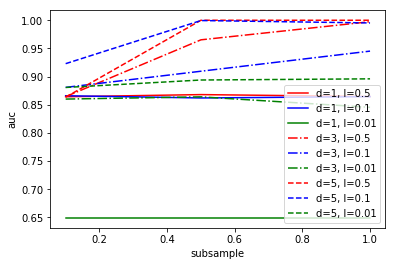

In [101]:
tipos = ['-', '-.', '--']
colors = ['r', 'b', 'g']
i = 0
j = 0
for d in max_depth:
    tipo = tipos[i]
    for l in learning_rate:
        aucs = [reform[(d, l ,s)] for s in subsample]
        plt.plot(subsample, aucs, linestyle=tipo, color = colors[j], label='d=%s, l=%s' % (d, l))
        j += 1
    i += 1
    j = 0
    
plt.xlabel('subsample')
plt.ylabel('auc')
plt.legend()

# Best Model

In [102]:
xgclf = XGBClassifier(max_depth=5, learning_rate=0.5, subsample=0.5, n_estimators=2118 ,n_jobs=-1)
xgclf.fit(X_train, y_train,verbose=100,early_stopping_rounds=50,eval_set=[(X_train,y_train),(X_val,y_val)])

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[0]	validation_0-error:0.062985	validation_1-error:0.06493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[100]	validation_0-error:0.054876	validation_1-error:0.055715
[200]	validation_0-error:0.048875	validation_1-error:0.050162
[300]	validation_0-error:0.043733	validation_1-error:0.044801
[400]	validation_0-error:0.039067	validation_1-error:0.039821
[500]	validation_0-error:0.034679	validation_1-error:0.035222
[600]	validation_0-error:0.030729	validation_1-error:0.030986
[700]	validation_0-error:0.027247	validation_1-error:0.027819
[800]	validation_0-error:0.023192	validation_1-error:0.023774
[900]	validation_0-error:0.020006	validation_1-error:0.020225
[1000]	validation_0-error:0.017201	validation_1-error:0.017802
[1100]	validation_0-error:0.014587	validation_1-error:0.014959
[1200]	validation_0-error:0.011983	validation_1-error:0.012135
[1300]	validation_0-error:0.00961

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=2118,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.5)

# Saving Model using Pickle


In [103]:
with open ('xgbrf.p', 'wb') as f:
    pickle.dump(xgclf, f)
    

with open('xgbrf.p', 'rb') as f:
    xgb_model = pickle.load(f)

# Score

In [104]:
ypred_test = xgb_model.predict(X_test)


score = roc_auc_score(y_test, ypred_test)
score

0.9903865910686571

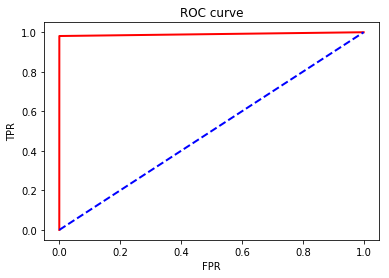

In [105]:
fpr, tpr,_= roc_curve(y_test, ypred_test)
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# Explainer using SHAP

In [106]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

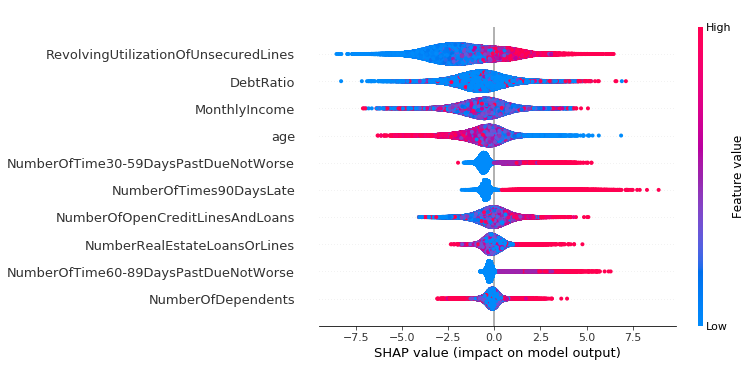

In [107]:
shap.summary_plot(shap_values, X)